In [ ]:
#!test ! -f "master.zip" && wget "https://github.com/karoldvl/ESC-50/archive/master.zip"

In [ ]:
#!unzip -qq master.zip

In [ ]:
#%cd ESC-50-master

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install PyAudio


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
libportaudiocpp0 is already the newest version (19.6.0-1).
portaudio19-dev is already the newest version (19.6.0-1).
libasound2-dev is already the newest version (1.1.3-5ubuntu0.6).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from csv import writer
import pickle
import pyaudio
#import winsound
import wave
import time
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import librosa
import cv2
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm, notebook
import IPython
import os
from google.colab import drive
from numba import cuda

In [ ]:
# import os
# os.environ['PYTORCH_CUDA_ALLOC_CONF']= 'garbage_collection_threshold:0.8'

In [ ]:
prefix= 'drive/Othercomputers/MyPC/R_D/'

In [ ]:
df = pd.read_csv(prefix + 'meta/esc50.csv')
df_extr = pd.read_csv( prefix + 'meta/audio_extr.csv')

In [ ]:
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-3000-E-10.wav,1,NaN,showering,NaN,NaN,NaN
1,1-3001-E-10.wav,1,NaN,showering,NaN,NaN,NaN
2,1-3002-E-10.wav,1,NaN,showering,NaN,NaN,NaN
3,1-3003-E-10.wav,1,NaN,showering,NaN,NaN,NaN
4,1-3004-E-10.wav,1,NaN,showering,NaN,NaN,NaN


In [ ]:
df_extr.head()

,filename,fold,target,category,esc10,src_file,take
0,6-100001-A-1.wav,6,NaN,toilet_flush,NaN,NaN,NaN
1,6-100002-A-1.wav,6,NaN,hands_washing,NaN,NaN,NaN
2,6-100003-A-1.wav,6,NaN,hands_washing,NaN,NaN,NaN
3,6-100004-A-1.wav,6,NaN,showering,NaN,NaN,NaN
4,6-100005-A-1.wav,6,NaN,showering,NaN,NaN,NaN


In [ ]:
df = df.drop(df[(df.category == "dog") | (df.category == "chirping_birds") | (df.category == "thunderstorm") | (df.category == "can_opening") 
                | (df.category == "crow") | (df.category == "clapping") | (df.category == "fireworks") | (df.category == "chainsaw")
                | (df.category == "airplane") | (df.category == "mouse_click") | (df.category == "train") | (df.category == "sheep") 
               | (df.category == "church_bells") | (df.category == "clock_alarm") | (df.category == "keyboard_typing") | (df.category == "wind") 
                | (df.category == "frog") | (df.category == "cow") | (df.category == "car_horn") | (df.category == "crackling_fire") 
                | (df.category == "helicopter") | (df.category == "engine") | (df.category == "pouring_water")  | (df.category == "engine")
               | (df.category == "drinking_sipping") | (df.category == "rain") | (df.category == "insects") | (df.category == "laughing") 
               | (df.category == "hen") | (df.category == "breathing") | (df.category == "crying_baby") | (df.category == "hand_saw")
               | (df.category == "coughing")| (df.category == "insects") | (df.category == "glass_breaking") | (df.category == "snoring")
               | (df.category == "pig") | (df.category == "clock_tick") | (df.category == "footsteps") | (df.category == "rooster")
               | (df.category == "sea_waves") | (df.category == "engine") | (df.category == "sneezing") | (df.category == "siren")
               | (df.category == "cat") | (df.category == "door_wood_creaks") | (df.category == "crickets") | (df.category == "engine")
               | (df.category == "door_wood_knock") | (df.category == "water_drops") | (df.category == "showering")].index)
df.reset_index(inplace = True)

In [ ]:
pd.set_option('display.max_rows', None)
print (df['category'])

0       vacuum_cleaner
1       vacuum_cleaner
2       brushing_teeth
3       brushing_teeth
4       vacuum_cleaner
5       vacuum_cleaner
6       vacuum_cleaner
7         toilet_flush
8      washing_machine
9      washing_machine
10     washing_machine
11     washing_machine
12     washing_machine
13        toilet_flush
14        toilet_flush
15     washing_machine
16     washing_machine
17      brushing_teeth
18        toilet_flush
19      vacuum_cleaner
20     washing_machine
21        toilet_flush
22        toilet_flush
23        toilet_flush
24        toilet_flush
25      brushing_teeth
26      brushing_teeth
27      vacuum_cleaner
28      brushing_teeth
29      brushing_teeth
30      brushing_teeth
31      vacuum_cleaner
32     washing_machine
33     washing_machine
34     washing_machine
35     washing_machine
36     washing_machine
37      vacuum_cleaner
38      vacuum_cleaner
39     washing_machine
40      vacuum_cleaner
41      vacuum_cleaner
42      vacuum_cleaner
43      vac

In [ ]:
df = df.drop(['index'], axis='columns') 
df

,filename,fold,target,category,esc10,src_file,take
0,1-100210-A-36.wav,1,36.0,vacuum_cleaner,False,100210.0,A
1,1-100210-B-36.wav,1,36.0,vacuum_cleaner,False,100210.0,B
2,1-17092-A-27.wav,1,27.0,brushing_teeth,False,17092.0,A
3,1-17092-B-27.wav,1,27.0,brushing_teeth,False,17092.0,B
4,1-19840-A-36.wav,1,36.0,vacuum_cleaner,False,19840.0,A
5,1-19872-A-36.wav,1,36.0,vacuum_cleaner,False,19872.0,A
6,1-19872-B-36.wav,1,36.0,vacuum_cleaner,False,19872.0,B
7,1-20736-A-18.wav,1,18.0,toilet_flush,False,20736.0,A
8,1-21896-A-35.wav,1,35.0,washing_machine,False,21896.0,A
9,1-23996-A-35.wav,1,35.0,washing_machine,False,23996.0,A


In [ ]:
df_extr = df_extr.drop(df_extr[(df_extr.category == "hands_washing") | (df_extr.category == "showering")].index)

In [ ]:
#if ok merge dataset
df= pd.concat([df, df_extr], ignore_index = True)
df.tail(10)

,filename,fold,target,category,esc10,src_file,take
171,6-100018-A-1.wav,6,NaN,brushing_teeth,NaN,NaN,NaN
172,6-100019-A-1.wav,6,NaN,washing_machine,NaN,NaN,NaN
173,6-100020-A-1.wav,6,NaN,washing_machine,NaN,NaN,NaN
174,6-100021-A-1.wav,6,NaN,toilet_flush,NaN,NaN,NaN
175,6-100024-A-1.wav,6,NaN,vacuum_cleaner,NaN,NaN,NaN
176,6-100025-A-1.wav,6,NaN,vacuum_cleaner,NaN,NaN,NaN
177,6-100026-A-1.wav,6,NaN,brushing_teeth,NaN,NaN,NaN
178,6-100027-A-1.wav,6,NaN,brushing_teeth,NaN,NaN,NaN
179,6-100028-A-1.wav,6,NaN,washing_machine,NaN,NaN,NaN
180,6-100029-A-1.wav,6,NaN,washing_machine,NaN,NaN,NaN


In [ ]:
print (df_extr['category'])

0        toilet_flush
5      vacuum_cleaner
6      vacuum_cleaner
7      brushing_teeth
8      brushing_teeth
9     washing_machine
10    washing_machine
11       toilet_flush
14     vacuum_cleaner
15     vacuum_cleaner
16     brushing_teeth
17     brushing_teeth
18    washing_machine
19    washing_machine
20       toilet_flush
23     vacuum_cleaner
24     vacuum_cleaner
25     brushing_teeth
26     brushing_teeth
27    washing_machine
28    washing_machine
Name: category, dtype: object


In [ ]:
train = df[df['fold']!= 6]
valid = df[df['fold']== 6]

In [ ]:
wav, sr = librosa.load(prefix + 'audio/1-20736-A-18.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 44100 and length of the audio is 5.0 seconds


In [ ]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)    
    return spec_scaled

In [ ]:
def spec_to_image_3d(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    # print (np.shape(spec_scaled))
    spec_scaled= cv2.cvtColor(spec_scaled,cv2.COLOR_GRAY2RGB)
    # print (np.shape(spec_scaled))
    return spec_scaled

In [ ]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(y= wav, sr=sr, n_fft=n_fft, hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

In [ ]:
class ESC50Data(Dataset):
    def __init__(self, base, df, in_col, out_col):
        self.df = df
        self.data = []
        self.temp = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        # print (np.shape(df))        
        self.categories = sorted(df[out_col].unique())
        # print (np.shape(self.categories))
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            file_path = os.path.join(base,row[in_col])
            mel= spec_to_image(get_melspectrogram_db(file_path))
            self.data.append(mel[np.newaxis,...])
            self.labels.append(self.c2i[row['category']])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
class ESC50Data_3d(Dataset):
    def __init__(self, base, df, in_col, out_col):
        self.df = df
        self.data = []
        self.temp = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        count= 0
        # print (np.shape(df))        
        self.categories = sorted(df[out_col].unique())
        # print (np.shape(self.categories))
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            file_path = os.path.join(base,row[in_col])
            # print (np.shape(spec_to_image_3d(get_melspectrogram_db(file_path))[...,0]))
            # self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
            mel= spec_to_image_3d(get_melspectrogram_db(file_path))
            mel_0d= mel[...,0]
            mel_1d= mel[...,1]
            mel_2d= mel[...,2]
            self.data.append(mel_0d[np.newaxis,...])
            self.data.append(mel_1d[np.newaxis,...])
            self.data.append(mel_2d[np.newaxis,...])
            self.labels.append(self.c2i[row['category']])
            count+= 1
        self.data= np.reshape(self.data, (count,3, 128, 431))
        
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

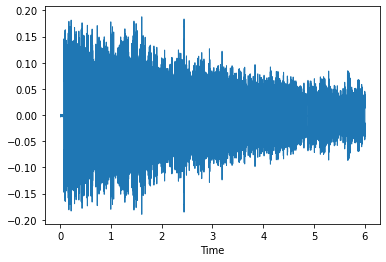

In [ ]:
filename = valid[valid['category']=='toilet_flush'].iloc[0]['filename']
wav, sr = librosa.load(prefix + 'audio/'+filename, sr=None)
librosa.display.waveshow(wav, sr= sr)

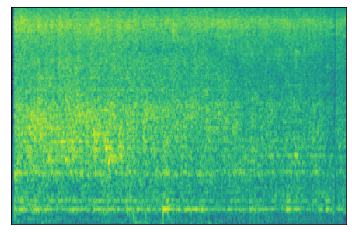

In [ ]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db(prefix + 'audio/'+filename, sr)), cmap='viridis')

In [ ]:
train_data = ESC50Data(prefix + 'audio', train, 'filename', 'category')

100%|██████████| 160/160 [00:04<00:00, 34.69it/s]


In [ ]:
print (np.shape(train_data.data))

(160, 1, 128, 431)


In [ ]:
train_data_3d = ESC50Data_3d(prefix + 'audio', train, 'filename', 'category')

100%|██████████| 160/160 [00:04<00:00, 34.15it/s]


In [ ]:
print (np.shape(train_data_3d.data))

(160, 3, 128, 431)


In [ ]:
valid_data = ESC50Data(prefix + 'audio', valid, 'filename', 'category')

100%|██████████| 21/21 [00:00<00:00, 34.83it/s]


In [ ]:
print (np.shape(valid_data.data))

(21, 1, 128, 431)


In [ ]:
valid_data_3d = ESC50Data_3d(prefix + 'audio', valid, 'filename', 'category')

100%|██████████| 21/21 [00:00<00:00, 36.07it/s]


In [ ]:
print (np.shape(valid_data_3d.data))

(21, 3, 128, 431)


In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)
train_loader_3d = DataLoader(train_data_3d, batch_size=32, shuffle=True)
valid_loader_3d = DataLoader(valid_data_3d, batch_size=32, shuffle=True)

In [ ]:
def save_ckp(state, is_best, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    # if it is a best model, min validation loss
    if is_best:
      torch.save(state, best_model_path)

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath, map_location=torch.device('cpu'))
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer

In [ ]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, best_model_path, change_lr=None):
    valid_loss_min= -1
    for epoch in tqdm(range(1,epochs+1)):
        model.train()
        batch_losses=[]
        if change_lr:
            optimizer = change_lr(optimizer, epoch)
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        train_losses.append(batch_losses)
        print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())      
            batch_losses.append(loss.item())
        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)

        checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss_min,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }

        if loss.item() <= valid_loss_min or valid_loss_min== -1:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  but not saving model (4C test)...'.format(valid_loss_min,loss.item()))
            # save checkpoint as best model
            # save_ckp(checkpoint, True, best_model_path)
            valid_loss_min = loss.item()
            
        print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')
    return model

In [ ]:
def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [ ]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

In [ ]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (torch.version.cuda)
print("Device", device)

Is the GPU available? True
11.3
Device cuda:0


In [ ]:
!nvidia-smi -L

GPU 0: A100-SXM4-40GB (UUID: GPU-5cd6ac0e-39e7-6a63-3c1f-e6a4903bd30b)


In [ ]:
def free_gpu_cache():
    print("Free GPU Memory...")                           
    torch.cuda.empty_cache()


In [ ]:
free_gpu_cache() 

Free GPU Memory...


In [ ]:
vgg_model_19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
#VGG19
from torchvision.models import vgg19, VGG19_Weights
weights = VGG19_Weights.DEFAULT
vgg_model_19 = vgg19(weights=weights)
# vgg_model_19 = vgg19()
# vgg_model_19.fc = nn.Linear(512,50)
# vgg_model_19.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_classes = 4
num_ftrs= 4096
vgg_model_19.classifier[6]= nn.Linear(num_ftrs, num_classes)
learning_rate = 2e-4
optimizer = optim.Adam(vgg_model_19.parameters(), lr=learning_rate)

In [ ]:
vgg_model_19 = vgg_model_19.to(device)
epochs = 100
loss_fn = nn.CrossEntropyLoss()
vgg_19_train_losses=[]
vgg_19_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%80==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

vgg_model_19 = train(vgg_model_19, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, vgg_19_train_losses, vgg_19_valid_losses, 'drive/Othercomputers/MyPC/R_D/models/vgg_19.pth', lr_decay)

  1%|          | 1/100 [00:03<05:52,  3.56s/it]

Epoch - 1 Train-Loss : 2.4004367113113405
Validation loss decreased (-1.000000 --> 1.283076).  but not saving model (4C test)...
Epoch - 1 Valid-Loss : 1.2830759286880493 Valid-Accuracy : 0.47619047619047616


  2%|▏         | 2/100 [00:04<02:50,  1.74s/it]

Epoch - 2 Train-Loss : 1.4861008882522584
Validation loss decreased (1.283076 --> 1.244344).  but not saving model (4C test)...
Epoch - 2 Valid-Loss : 1.2443437576293945 Valid-Accuracy : 0.42857142857142855


  3%|▎         | 3/100 [00:04<01:51,  1.15s/it]

Epoch - 3 Train-Loss : 1.604153299331665
Epoch - 3 Valid-Loss : 2.33362078666687 Valid-Accuracy : 0.2857142857142857


  4%|▍         | 4/100 [00:04<01:24,  1.14it/s]

Epoch - 4 Train-Loss : 1.5662302732467652
Epoch - 4 Valid-Loss : 1.382569670677185 Valid-Accuracy : 0.2857142857142857


  5%|▌         | 5/100 [00:05<01:09,  1.37it/s]

Epoch - 5 Train-Loss : 1.387125825881958
Epoch - 5 Valid-Loss : 1.3285984992980957 Valid-Accuracy : 0.5714285714285714


  6%|▌         | 6/100 [00:05<00:59,  1.57it/s]

Epoch - 6 Train-Loss : 1.4301754713058472
Epoch - 6 Valid-Loss : 1.3546209335327148 Valid-Accuracy : 0.2857142857142857


  7%|▋         | 7/100 [00:06<00:53,  1.72it/s]

Epoch - 7 Train-Loss : 1.2378997087478638
Validation loss decreased (1.244344 --> 1.143743).  but not saving model (4C test)...
Epoch - 7 Valid-Loss : 1.143742561340332 Valid-Accuracy : 0.5238095238095238


  8%|▊         | 8/100 [00:06<00:49,  1.84it/s]

Epoch - 8 Train-Loss : 0.8798731446266175
Epoch - 8 Valid-Loss : 2.8818461894989014 Valid-Accuracy : 0.3333333333333333


  9%|▉         | 9/100 [00:07<00:47,  1.93it/s]

Epoch - 9 Train-Loss : 1.6419146656990051
Epoch - 9 Valid-Loss : 1.4909495115280151 Valid-Accuracy : 0.19047619047619047


 10%|█         | 10/100 [00:07<00:44,  2.00it/s]

Epoch - 10 Train-Loss : 0.9700380325317383
Epoch - 10 Valid-Loss : 1.3556654453277588 Valid-Accuracy : 0.42857142857142855


 11%|█         | 11/100 [00:08<00:43,  2.05it/s]

Epoch - 11 Train-Loss : 0.8345614075660706
Epoch - 11 Valid-Loss : 1.264242172241211 Valid-Accuracy : 0.42857142857142855


 12%|█▏        | 12/100 [00:08<00:42,  2.09it/s]

Epoch - 12 Train-Loss : 0.6616318762302399
Epoch - 12 Valid-Loss : 1.4834654331207275 Valid-Accuracy : 0.42857142857142855


 13%|█▎        | 13/100 [00:09<00:41,  2.11it/s]

Epoch - 13 Train-Loss : 0.5067295551300048
Epoch - 13 Valid-Loss : 1.647560477256775 Valid-Accuracy : 0.47619047619047616


 14%|█▍        | 14/100 [00:09<00:40,  2.13it/s]

Epoch - 14 Train-Loss : 0.5029501616954803
Epoch - 14 Valid-Loss : 1.5285931825637817 Valid-Accuracy : 0.42857142857142855


 15%|█▌        | 15/100 [00:10<00:39,  2.14it/s]

Epoch - 15 Train-Loss : 0.4844638407230377
Epoch - 15 Valid-Loss : 1.9335435628890991 Valid-Accuracy : 0.42857142857142855


 16%|█▌        | 16/100 [00:10<00:39,  2.15it/s]

Epoch - 16 Train-Loss : 0.5334413826465607
Epoch - 16 Valid-Loss : 1.3549048900604248 Valid-Accuracy : 0.42857142857142855


 17%|█▋        | 17/100 [00:10<00:38,  2.16it/s]

Epoch - 17 Train-Loss : 0.5478628754615784
Epoch - 17 Valid-Loss : 1.334949254989624 Valid-Accuracy : 0.38095238095238093


 18%|█▊        | 18/100 [00:11<00:37,  2.16it/s]

Epoch - 18 Train-Loss : 0.8874706506729126
Validation loss decreased (1.143743 --> 1.027551).  but not saving model (4C test)...
Epoch - 18 Valid-Loss : 1.0275514125823975 Valid-Accuracy : 0.42857142857142855


 19%|█▉        | 19/100 [00:11<00:37,  2.17it/s]

Epoch - 19 Train-Loss : 0.4399345338344574
Epoch - 19 Valid-Loss : 1.4162472486495972 Valid-Accuracy : 0.5714285714285714


 20%|██        | 20/100 [00:12<00:36,  2.17it/s]

Epoch - 20 Train-Loss : 0.4255630671977997
Epoch - 20 Valid-Loss : 2.847547769546509 Valid-Accuracy : 0.47619047619047616


 21%|██        | 21/100 [00:12<00:36,  2.17it/s]

Epoch - 21 Train-Loss : 0.262871053814888
Epoch - 21 Valid-Loss : 1.5322587490081787 Valid-Accuracy : 0.5238095238095238


 22%|██▏       | 22/100 [00:13<00:35,  2.17it/s]

Epoch - 22 Train-Loss : 0.21638476848602295
Validation loss decreased (1.027551 --> 0.693257).  but not saving model (4C test)...
Epoch - 22 Valid-Loss : 0.6932570934295654 Valid-Accuracy : 0.7619047619047619


 23%|██▎       | 23/100 [00:13<00:35,  2.17it/s]

Epoch - 23 Train-Loss : 0.32469695061445236
Epoch - 23 Valid-Loss : 1.2227492332458496 Valid-Accuracy : 0.5238095238095238


 24%|██▍       | 24/100 [00:14<00:34,  2.17it/s]

Epoch - 24 Train-Loss : 0.21081011593341828
Validation loss decreased (0.693257 --> 0.687434).  but not saving model (4C test)...
Epoch - 24 Valid-Loss : 0.6874340772628784 Valid-Accuracy : 0.7142857142857143


 25%|██▌       | 25/100 [00:14<00:34,  2.17it/s]

Epoch - 25 Train-Loss : 0.14767799377441407
Epoch - 25 Valid-Loss : 2.7167305946350098 Valid-Accuracy : 0.5238095238095238


 26%|██▌       | 26/100 [00:15<00:34,  2.17it/s]

Epoch - 26 Train-Loss : 0.16408840343356132
Epoch - 26 Valid-Loss : 1.9726858139038086 Valid-Accuracy : 0.7619047619047619


 27%|██▋       | 27/100 [00:15<00:33,  2.17it/s]

Epoch - 27 Train-Loss : 0.09143982082605362
Epoch - 27 Valid-Loss : 0.8935517072677612 Valid-Accuracy : 0.7142857142857143


 28%|██▊       | 28/100 [00:15<00:33,  2.17it/s]

Epoch - 28 Train-Loss : 0.04788964008912444
Epoch - 28 Valid-Loss : 1.8720821142196655 Valid-Accuracy : 0.6666666666666666


 29%|██▉       | 29/100 [00:16<00:32,  2.17it/s]

Epoch - 29 Train-Loss : 0.02515260875370586
Epoch - 29 Valid-Loss : 2.1804394721984863 Valid-Accuracy : 0.5714285714285714


 30%|███       | 30/100 [00:16<00:32,  2.17it/s]

Epoch - 30 Train-Loss : 0.04166866647501592
Epoch - 30 Valid-Loss : 5.11545467376709 Valid-Accuracy : 0.5714285714285714


 31%|███       | 31/100 [00:17<00:31,  2.17it/s]

Epoch - 31 Train-Loss : 0.009158840939176117
Epoch - 31 Valid-Loss : 4.989157676696777 Valid-Accuracy : 0.6666666666666666


 32%|███▏      | 32/100 [00:17<00:31,  2.17it/s]

Epoch - 32 Train-Loss : 0.12496380538352696
Epoch - 32 Valid-Loss : 7.444474220275879 Valid-Accuracy : 0.6190476190476191


 33%|███▎      | 33/100 [00:18<00:30,  2.17it/s]

Epoch - 33 Train-Loss : 0.8573204457759858
Epoch - 33 Valid-Loss : 1.8890897035598755 Valid-Accuracy : 0.47619047619047616


 34%|███▍      | 34/100 [00:18<00:30,  2.17it/s]

Epoch - 34 Train-Loss : 0.27669263780117037
Epoch - 34 Valid-Loss : 1.5228228569030762 Valid-Accuracy : 0.6190476190476191


 35%|███▌      | 35/100 [00:19<00:29,  2.17it/s]

Epoch - 35 Train-Loss : 0.1530999019742012
Epoch - 35 Valid-Loss : 3.126328945159912 Valid-Accuracy : 0.6190476190476191


 36%|███▌      | 36/100 [00:19<00:29,  2.17it/s]

Epoch - 36 Train-Loss : 0.0646119481883943
Epoch - 36 Valid-Loss : 4.785265922546387 Valid-Accuracy : 0.6666666666666666


 37%|███▋      | 37/100 [00:20<00:29,  2.17it/s]

Epoch - 37 Train-Loss : 0.2182394782314077
Epoch - 37 Valid-Loss : 1.5818933248519897 Valid-Accuracy : 0.7142857142857143


 38%|███▊      | 38/100 [00:20<00:28,  2.17it/s]

Epoch - 38 Train-Loss : 0.3002939745783806
Epoch - 38 Valid-Loss : 1.151615858078003 Valid-Accuracy : 0.5714285714285714


 39%|███▉      | 39/100 [00:21<00:28,  2.17it/s]

Epoch - 39 Train-Loss : 0.1870221458375454
Epoch - 39 Valid-Loss : 1.5248968601226807 Valid-Accuracy : 0.6190476190476191


 40%|████      | 40/100 [00:21<00:27,  2.17it/s]

Epoch - 40 Train-Loss : 0.08958017490804196
Epoch - 40 Valid-Loss : 4.283886909484863 Valid-Accuracy : 0.5238095238095238


 41%|████      | 41/100 [00:21<00:27,  2.17it/s]

Epoch - 41 Train-Loss : 0.01767967964115087
Epoch - 41 Valid-Loss : 7.099917411804199 Valid-Accuracy : 0.47619047619047616


 42%|████▏     | 42/100 [00:22<00:26,  2.17it/s]

Epoch - 42 Train-Loss : 0.046936847383040006
Epoch - 42 Valid-Loss : 7.310832977294922 Valid-Accuracy : 0.6190476190476191


 43%|████▎     | 43/100 [00:22<00:26,  2.17it/s]

Epoch - 43 Train-Loss : 0.16054205931723117
Epoch - 43 Valid-Loss : 22.973270416259766 Valid-Accuracy : 0.47619047619047616


 44%|████▍     | 44/100 [00:23<00:25,  2.17it/s]

Epoch - 44 Train-Loss : 0.2278258264064789
Epoch - 44 Valid-Loss : 1.896446943283081 Valid-Accuracy : 0.6190476190476191


 45%|████▌     | 45/100 [00:23<00:25,  2.17it/s]

Epoch - 45 Train-Loss : 0.4204879254102707
Epoch - 45 Valid-Loss : 0.6979016065597534 Valid-Accuracy : 0.8095238095238095


 46%|████▌     | 46/100 [00:24<00:24,  2.17it/s]

Epoch - 46 Train-Loss : 0.1855236455798149
Epoch - 46 Valid-Loss : 1.3839070796966553 Valid-Accuracy : 0.6666666666666666


 47%|████▋     | 47/100 [00:24<00:24,  2.17it/s]

Epoch - 47 Train-Loss : 0.1220782034099102
Epoch - 47 Valid-Loss : 1.409117341041565 Valid-Accuracy : 0.6190476190476191


 48%|████▊     | 48/100 [00:25<00:24,  2.16it/s]

Epoch - 48 Train-Loss : 0.3962075373157859
Epoch - 48 Valid-Loss : 1.8052805662155151 Valid-Accuracy : 0.7142857142857143


 49%|████▉     | 49/100 [00:25<00:23,  2.17it/s]

Epoch - 49 Train-Loss : 0.23078153729438783
Epoch - 49 Valid-Loss : 0.9626062512397766 Valid-Accuracy : 0.5714285714285714


 50%|█████     | 50/100 [00:26<00:23,  2.17it/s]

Epoch - 50 Train-Loss : 0.13892550840973855
Epoch - 50 Valid-Loss : 0.944764256477356 Valid-Accuracy : 0.6666666666666666


 51%|█████     | 51/100 [00:26<00:22,  2.17it/s]

Epoch - 51 Train-Loss : 0.04280567839741707
Epoch - 51 Valid-Loss : 1.6419143676757812 Valid-Accuracy : 0.6190476190476191


 52%|█████▏    | 52/100 [00:27<00:22,  2.17it/s]

Epoch - 52 Train-Loss : 0.010867241711821407
Epoch - 52 Valid-Loss : 2.989804983139038 Valid-Accuracy : 0.6190476190476191


 53%|█████▎    | 53/100 [00:27<00:21,  2.17it/s]

Epoch - 53 Train-Loss : 0.009028494336598669
Epoch - 53 Valid-Loss : 4.159829616546631 Valid-Accuracy : 0.6190476190476191


 54%|█████▍    | 54/100 [00:27<00:21,  2.17it/s]

Epoch - 54 Train-Loss : 0.004128635664574176
Epoch - 54 Valid-Loss : 5.240222930908203 Valid-Accuracy : 0.6190476190476191


 55%|█████▌    | 55/100 [00:28<00:20,  2.18it/s]

Epoch - 55 Train-Loss : 0.005288015326732421
Epoch - 55 Valid-Loss : 5.778314113616943 Valid-Accuracy : 0.5714285714285714


 56%|█████▌    | 56/100 [00:28<00:20,  2.18it/s]

Epoch - 56 Train-Loss : 0.0005894868460927683
Epoch - 56 Valid-Loss : 5.717578887939453 Valid-Accuracy : 0.5714285714285714


 57%|█████▋    | 57/100 [00:29<00:19,  2.18it/s]

Epoch - 57 Train-Loss : 9.192435332465721e-05
Epoch - 57 Valid-Loss : 5.7848310470581055 Valid-Accuracy : 0.6666666666666666


 58%|█████▊    | 58/100 [00:29<00:19,  2.18it/s]

Epoch - 58 Train-Loss : 0.000866205328463776
Epoch - 58 Valid-Loss : 5.98311185836792 Valid-Accuracy : 0.6666666666666666


 59%|█████▉    | 59/100 [00:30<00:18,  2.18it/s]

Epoch - 59 Train-Loss : 0.00036665930560939584
Epoch - 59 Valid-Loss : 6.073795795440674 Valid-Accuracy : 0.6666666666666666


 60%|██████    | 60/100 [00:30<00:18,  2.18it/s]

Epoch - 60 Train-Loss : 0.00013579284749312137
Epoch - 60 Valid-Loss : 6.111559867858887 Valid-Accuracy : 0.6666666666666666


 61%|██████    | 61/100 [00:31<00:17,  2.18it/s]

Epoch - 61 Train-Loss : 0.000587065004399534
Epoch - 61 Valid-Loss : 6.097686767578125 Valid-Accuracy : 0.6666666666666666


 62%|██████▏   | 62/100 [00:31<00:17,  2.18it/s]

Epoch - 62 Train-Loss : 7.188285048655984e-05
Epoch - 62 Valid-Loss : 6.022594451904297 Valid-Accuracy : 0.6666666666666666


 63%|██████▎   | 63/100 [00:32<00:16,  2.18it/s]

Epoch - 63 Train-Loss : 6.36209673521293e-06
Epoch - 63 Valid-Loss : 5.9922966957092285 Valid-Accuracy : 0.6190476190476191


 64%|██████▍   | 64/100 [00:32<00:16,  2.18it/s]

Epoch - 64 Train-Loss : 9.901722462828389e-05
Epoch - 64 Valid-Loss : 5.987351894378662 Valid-Accuracy : 0.6190476190476191


 65%|██████▌   | 65/100 [00:33<00:16,  2.18it/s]

Epoch - 65 Train-Loss : 9.419516783992777e-06
Epoch - 65 Valid-Loss : 5.990594863891602 Valid-Accuracy : 0.6190476190476191


 66%|██████▌   | 66/100 [00:33<00:15,  2.18it/s]

Epoch - 66 Train-Loss : 2.846101209819096e-07
Epoch - 66 Valid-Loss : 6.0225677490234375 Valid-Accuracy : 0.6190476190476191


 67%|██████▋   | 67/100 [00:33<00:15,  2.18it/s]

Epoch - 67 Train-Loss : 3.6776015931661022e-06
Epoch - 67 Valid-Loss : 6.089673042297363 Valid-Accuracy : 0.6190476190476191


 68%|██████▊   | 68/100 [00:34<00:14,  2.18it/s]

Epoch - 68 Train-Loss : 1.6970477844324706e-06
Epoch - 68 Valid-Loss : 6.293528079986572 Valid-Accuracy : 0.6190476190476191


 69%|██████▉   | 69/100 [00:34<00:14,  2.18it/s]

Epoch - 69 Train-Loss : 9.704324422399324e-06
Epoch - 69 Valid-Loss : 6.482212066650391 Valid-Accuracy : 0.6190476190476191


 70%|███████   | 70/100 [00:35<00:13,  2.18it/s]

Epoch - 70 Train-Loss : 2.2947581364007873e-07
Epoch - 70 Valid-Loss : 6.592777729034424 Valid-Accuracy : 0.6190476190476191


 71%|███████   | 71/100 [00:35<00:13,  2.18it/s]

Epoch - 71 Train-Loss : 6.042238467340866e-07
Epoch - 71 Valid-Loss : 6.6709885597229 Valid-Accuracy : 0.6190476190476191


 72%|███████▏  | 72/100 [00:36<00:12,  2.18it/s]

Epoch - 72 Train-Loss : 2.905178939727193e-06
Epoch - 72 Valid-Loss : 6.752732753753662 Valid-Accuracy : 0.6190476190476191


 73%|███████▎  | 73/100 [00:36<00:12,  2.18it/s]

Epoch - 73 Train-Loss : 1.665767891267933e-06
Epoch - 73 Valid-Loss : 6.857415199279785 Valid-Accuracy : 0.6190476190476191


 74%|███████▍  | 74/100 [00:37<00:11,  2.18it/s]

Epoch - 74 Train-Loss : 7.941965940005958e-07
Epoch - 74 Valid-Loss : 6.943416595458984 Valid-Accuracy : 0.6190476190476191


 75%|███████▌  | 75/100 [00:37<00:11,  2.18it/s]

Epoch - 75 Train-Loss : 8.076176342797226e-07
Epoch - 75 Valid-Loss : 6.978044033050537 Valid-Accuracy : 0.6190476190476191


 76%|███████▌  | 76/100 [00:38<00:11,  2.18it/s]

Epoch - 76 Train-Loss : 2.249739890203273e-06
Epoch - 76 Valid-Loss : 7.005424976348877 Valid-Accuracy : 0.6190476190476191


 77%|███████▋  | 77/100 [00:38<00:10,  2.18it/s]

Epoch - 77 Train-Loss : 3.956204065680424e-07
Epoch - 77 Valid-Loss : 7.049121856689453 Valid-Accuracy : 0.6190476190476191


 78%|███████▊  | 78/100 [00:38<00:10,  2.18it/s]

Epoch - 78 Train-Loss : 5.207824869568611e-07
Epoch - 78 Valid-Loss : 7.100545883178711 Valid-Accuracy : 0.6190476190476191


 79%|███████▉  | 79/100 [00:39<00:09,  2.18it/s]

Epoch - 79 Train-Loss : 1.6838225036508447e-07
Epoch - 79 Valid-Loss : 7.147581577301025 Valid-Accuracy : 0.6190476190476191
Changed learning rate to 2e-12


 80%|████████  | 80/100 [00:39<00:09,  2.18it/s]

Epoch - 80 Train-Loss : 6.317912535802605e-07
Epoch - 80 Valid-Loss : 7.147581577301025 Valid-Accuracy : 0.6190476190476191


 81%|████████  | 81/100 [00:40<00:08,  2.18it/s]

Epoch - 81 Train-Loss : 1.4691425177737472e-06
Epoch - 81 Valid-Loss : 7.147581577301025 Valid-Accuracy : 0.6190476190476191


 82%|████████▏ | 82/100 [00:40<00:08,  2.18it/s]

Epoch - 82 Train-Loss : 3.6805535597039807e-07
Epoch - 82 Valid-Loss : 7.147581577301025 Valid-Accuracy : 0.6190476190476191


 83%|████████▎ | 83/100 [00:41<00:07,  2.18it/s]

Epoch - 83 Train-Loss : 1.8626325277715238e-07
Epoch - 83 Valid-Loss : 7.147581577301025 Valid-Accuracy : 0.6190476190476191


 84%|████████▍ | 84/100 [00:41<00:07,  2.18it/s]

Epoch - 84 Train-Loss : 2.4512162846157535e-07
Epoch - 84 Valid-Loss : 7.147582054138184 Valid-Accuracy : 0.6190476190476191


 85%|████████▌ | 85/100 [00:42<00:06,  2.18it/s]

Epoch - 85 Train-Loss : 3.5017165198603097e-07
Epoch - 85 Valid-Loss : 7.147582054138184 Valid-Accuracy : 0.6190476190476191


 86%|████████▌ | 86/100 [00:42<00:06,  2.18it/s]

Epoch - 86 Train-Loss : 3.0696108552774606e-07
Epoch - 86 Valid-Loss : 7.147582054138184 Valid-Accuracy : 0.6190476190476191


 87%|████████▋ | 87/100 [00:43<00:05,  2.18it/s]

Epoch - 87 Train-Loss : 3.8518802867315573e-07
Epoch - 87 Valid-Loss : 7.147581577301025 Valid-Accuracy : 0.6190476190476191


 88%|████████▊ | 88/100 [00:43<00:05,  2.18it/s]

Epoch - 88 Train-Loss : 2.1979106885616772e-07
Epoch - 88 Valid-Loss : 7.147581577301025 Valid-Accuracy : 0.6190476190476191


 89%|████████▉ | 89/100 [00:44<00:05,  2.18it/s]

Epoch - 89 Train-Loss : 9.98375355720782e-08
Epoch - 89 Valid-Loss : 7.147581577301025 Valid-Accuracy : 0.6190476190476191


 90%|█████████ | 90/100 [00:44<00:04,  2.18it/s]

Epoch - 90 Train-Loss : 4.097815473613764e-08
Epoch - 90 Valid-Loss : 7.147582054138184 Valid-Accuracy : 0.6190476190476191


 91%|█████████ | 91/100 [00:44<00:04,  2.18it/s]

Epoch - 91 Train-Loss : 1.2516916427784964e-07
Epoch - 91 Valid-Loss : 7.147581577301025 Valid-Accuracy : 0.6190476190476191


 92%|█████████▏| 92/100 [00:45<00:03,  2.18it/s]

Epoch - 92 Train-Loss : 1.9296861903939088e-07
Epoch - 92 Valid-Loss : 7.147581577301025 Valid-Accuracy : 0.6190476190476191


 93%|█████████▎| 93/100 [00:45<00:03,  2.18it/s]

Epoch - 93 Train-Loss : 5.7674445997690785e-06
Epoch - 93 Valid-Loss : 7.147581577301025 Valid-Accuracy : 0.6190476190476191


 94%|█████████▍| 94/100 [00:46<00:02,  2.18it/s]

Epoch - 94 Train-Loss : 2.764136326049993e-07
Epoch - 94 Valid-Loss : 7.147581577301025 Valid-Accuracy : 0.6190476190476191


 95%|█████████▌| 95/100 [00:46<00:02,  2.18it/s]

Epoch - 95 Train-Loss : 1.788129039947961e-07
Epoch - 95 Valid-Loss : 7.147582054138184 Valid-Accuracy : 0.6190476190476191


 96%|█████████▌| 96/100 [00:47<00:01,  2.18it/s]

Epoch - 96 Train-Loss : 5.349419598843496e-07
Epoch - 96 Valid-Loss : 7.147580623626709 Valid-Accuracy : 0.6190476190476191


 97%|█████████▋| 97/100 [00:47<00:01,  2.18it/s]

Epoch - 97 Train-Loss : 4.999207508404879e-07
Epoch - 97 Valid-Loss : 7.147581577301025 Valid-Accuracy : 0.6190476190476191


 98%|█████████▊| 98/100 [00:48<00:00,  2.18it/s]

Epoch - 98 Train-Loss : 7.897602358752919e-08
Epoch - 98 Valid-Loss : 7.147581577301025 Valid-Accuracy : 0.6190476190476191


 99%|█████████▉| 99/100 [00:48<00:00,  2.18it/s]

Epoch - 99 Train-Loss : 8.39644576444698e-07
Epoch - 99 Valid-Loss : 7.147581577301025 Valid-Accuracy : 0.6190476190476191


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]

Epoch - 100 Train-Loss : 1.3425269902000992e-06
Epoch - 100 Valid-Loss : 7.147581577301025 Valid-Accuracy : 0.6190476190476191


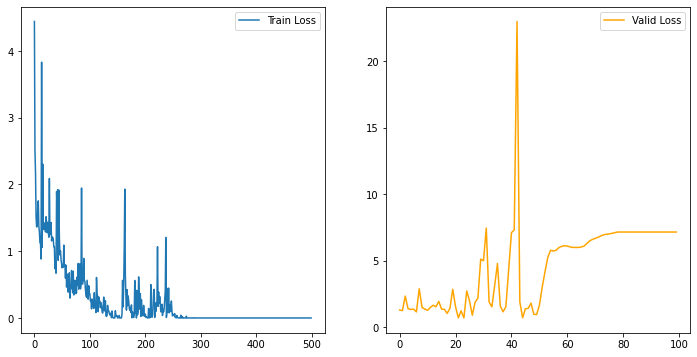

In [ ]:
tl = np.asarray(vgg_19_train_losses).ravel()
vl = np.asarray(vgg_19_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

In [ ]:
alexnet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#AlexNet
from torchvision.models import alexnet, AlexNet_Weights
weights = AlexNet_Weights.DEFAULT
alexnet_model = alexnet()
#alexnet_model = alexnet()
# alexnet_model.fc = nn.Linear(512,50)
# alexnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_classes = 4
num_ftrs= 4096
alexnet_model.classifier[6]= nn.Linear(num_ftrs, num_classes)
learning_rate = 2e-4
optimizer = optim.Adam(alexnet_model.parameters(), lr=learning_rate)

In [ ]:
alexnet_model = alexnet_model.to(device)
epochs = 400
loss_fn = nn.CrossEntropyLoss()
alexnet_train_losses=[]
alexnet_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%400==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

alexnet_model = train(alexnet_model, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, alexnet_train_losses, alexnet_valid_losses, 'drive/Othercomputers/MyPC/R_D/models/alexnet.pth', lr_decay)

  0%|          | 2/400 [00:00<00:34, 11.46it/s]

Epoch - 1 Train-Loss : 3.048919129371643
Validation loss decreased (-1.000000 --> 1.393333).  but not saving model (4C test)...
Epoch - 1 Valid-Loss : 1.393333077430725 Valid-Accuracy : 0.2857142857142857
Epoch - 2 Train-Loss : 1.3880582332611084
Validation loss decreased (1.393333 --> 1.359268).  but not saving model (4C test)...
Epoch - 2 Valid-Loss : 1.3592681884765625 Valid-Accuracy : 0.2857142857142857
Epoch - 3 Train-Loss : 1.3593339204788208
Validation loss decreased (1.359268 --> 1.319413).  but not saving model (4C test)...
Epoch - 3 Valid-Loss : 1.3194125890731812 Valid-Accuracy : 0.42857142857142855


  2%|▏         | 6/400 [00:00<00:33, 11.85it/s]

Epoch - 4 Train-Loss : 1.2117967367172242
Validation loss decreased (1.319413 --> 1.145433).  but not saving model (4C test)...
Epoch - 4 Valid-Loss : 1.1454333066940308 Valid-Accuracy : 0.47619047619047616
Epoch - 5 Train-Loss : 1.3906731605529785
Epoch - 5 Valid-Loss : 1.5281473398208618 Valid-Accuracy : 0.2857142857142857
Epoch - 6 Train-Loss : 1.1525423407554627
Validation loss decreased (1.145433 --> 1.084216).  but not saving model (4C test)...
Epoch - 6 Valid-Loss : 1.0842163562774658 Valid-Accuracy : 0.5238095238095238


  2%|▏         | 8/400 [00:00<00:32, 11.91it/s]

Epoch - 7 Train-Loss : 1.3313927888870238
Epoch - 7 Valid-Loss : 1.500370979309082 Valid-Accuracy : 0.19047619047619047
Epoch - 8 Train-Loss : 1.2811044692993163
Epoch - 8 Valid-Loss : 1.3866924047470093 Valid-Accuracy : 0.19047619047619047
Epoch - 9 Train-Loss : 1.0981697916984559
Epoch - 9 Valid-Loss : 1.177510142326355 Valid-Accuracy : 0.6666666666666666


  3%|▎         | 12/400 [00:01<00:32, 11.97it/s]

Epoch - 10 Train-Loss : 0.9942930579185486
Epoch - 10 Valid-Loss : 1.352774739265442 Valid-Accuracy : 0.47619047619047616
Epoch - 11 Train-Loss : 0.8596586346626282
Epoch - 11 Valid-Loss : 1.1136143207550049 Valid-Accuracy : 0.42857142857142855
Epoch - 12 Train-Loss : 0.7004313468933105
Validation loss decreased (1.084216 --> 0.917615).  but not saving model (4C test)...
Epoch - 12 Valid-Loss : 0.9176148176193237 Valid-Accuracy : 0.6190476190476191


  4%|▎         | 14/400 [00:01<00:32, 11.95it/s]

Epoch - 13 Train-Loss : 0.5866302073001861
Validation loss decreased (0.917615 --> 0.868611).  but not saving model (4C test)...
Epoch - 13 Valid-Loss : 0.8686113953590393 Valid-Accuracy : 0.6666666666666666
Epoch - 14 Train-Loss : 0.5189188778400421
Validation loss decreased (0.868611 --> 0.718908).  but not saving model (4C test)...
Epoch - 14 Valid-Loss : 0.7189077138900757 Valid-Accuracy : 0.6666666666666666
Epoch - 15 Train-Loss : 0.4842203438282013
Epoch - 15 Valid-Loss : 1.132678747177124 Valid-Accuracy : 0.5714285714285714


  4%|▍         | 18/400 [00:01<00:32, 11.93it/s]

Epoch - 16 Train-Loss : 0.387355238199234
Epoch - 16 Valid-Loss : 0.8218365907669067 Valid-Accuracy : 0.6666666666666666
Epoch - 17 Train-Loss : 0.4976335048675537
Epoch - 17 Valid-Loss : 2.151723623275757 Valid-Accuracy : 0.5238095238095238
Epoch - 18 Train-Loss : 0.7306679904460907
Epoch - 18 Valid-Loss : 1.2671754360198975 Valid-Accuracy : 0.42857142857142855


  5%|▌         | 20/400 [00:01<00:31, 11.91it/s]

Epoch - 19 Train-Loss : 0.5946786999702454
Epoch - 19 Valid-Loss : 0.9967328310012817 Valid-Accuracy : 0.5714285714285714
Epoch - 20 Train-Loss : 0.5063296973705291
Epoch - 20 Valid-Loss : 0.9280824065208435 Valid-Accuracy : 0.7619047619047619
Epoch - 21 Train-Loss : 0.37548072934150695
Validation loss decreased (0.718908 --> 0.656706).  but not saving model (4C test)...
Epoch - 21 Valid-Loss : 0.6567056179046631 Valid-Accuracy : 0.7142857142857143


  6%|▌         | 24/400 [00:02<00:31, 11.99it/s]

Epoch - 22 Train-Loss : 0.309377321600914
Epoch - 22 Valid-Loss : 0.6935957074165344 Valid-Accuracy : 0.7142857142857143
Epoch - 23 Train-Loss : 0.30233036875724795
Validation loss decreased (0.656706 --> 0.533995).  but not saving model (4C test)...
Epoch - 23 Valid-Loss : 0.5339951515197754 Valid-Accuracy : 0.7619047619047619
Epoch - 24 Train-Loss : 0.20845194309949874
Epoch - 24 Valid-Loss : 1.1234698295593262 Valid-Accuracy : 0.6190476190476191


  6%|▋         | 26/400 [00:02<00:31, 12.02it/s]

Epoch - 25 Train-Loss : 0.14666489288210868
Epoch - 25 Valid-Loss : 1.04464590549469 Valid-Accuracy : 0.6666666666666666
Epoch - 26 Train-Loss : 0.3383420296013355
Epoch - 26 Valid-Loss : 2.800748825073242 Valid-Accuracy : 0.42857142857142855
Epoch - 27 Train-Loss : 0.7597358644008636
Epoch - 27 Valid-Loss : 2.0245113372802734 Valid-Accuracy : 0.3333333333333333


  8%|▊         | 30/400 [00:02<00:30, 12.06it/s]

Epoch - 28 Train-Loss : 0.6574373841285706
Epoch - 28 Valid-Loss : 1.1234968900680542 Valid-Accuracy : 0.6190476190476191
Epoch - 29 Train-Loss : 0.6586927771568298
Epoch - 29 Valid-Loss : 1.0028173923492432 Valid-Accuracy : 0.6666666666666666
Epoch - 30 Train-Loss : 0.4906053125858307
Epoch - 30 Valid-Loss : 0.8004982471466064 Valid-Accuracy : 0.7142857142857143


  8%|▊         | 32/400 [00:02<00:30, 12.00it/s]

Epoch - 31 Train-Loss : 0.36352218985557555
Epoch - 31 Valid-Loss : 0.5709537267684937 Valid-Accuracy : 0.8095238095238095
Epoch - 32 Train-Loss : 0.33331298828125
Epoch - 32 Valid-Loss : 0.6982759833335876 Valid-Accuracy : 0.7142857142857143
Epoch - 33 Train-Loss : 0.26406067311763765
Epoch - 33 Valid-Loss : 0.7464603781700134 Valid-Accuracy : 0.7142857142857143


  9%|▉         | 36/400 [00:03<00:30, 12.09it/s]

Epoch - 34 Train-Loss : 0.20083319991827012
Epoch - 34 Valid-Loss : 0.8691994547843933 Valid-Accuracy : 0.7142857142857143
Epoch - 35 Train-Loss : 0.18498966097831726
Epoch - 35 Valid-Loss : 0.8417140245437622 Valid-Accuracy : 0.7619047619047619
Epoch - 36 Train-Loss : 0.39290404319763184
Epoch - 36 Valid-Loss : 2.7213406562805176 Valid-Accuracy : 0.5714285714285714


 10%|▉         | 38/400 [00:03<00:29, 12.10it/s]

Epoch - 37 Train-Loss : 0.4980919599533081
Epoch - 37 Valid-Loss : 0.6094366312026978 Valid-Accuracy : 0.8571428571428571
Epoch - 38 Train-Loss : 0.1733900085091591
Epoch - 38 Valid-Loss : 1.5194379091262817 Valid-Accuracy : 0.42857142857142855
Epoch - 39 Train-Loss : 0.22912128418684005
Epoch - 39 Valid-Loss : 0.8819677233695984 Valid-Accuracy : 0.6190476190476191


 10%|█         | 42/400 [00:03<00:29, 12.09it/s]

Epoch - 40 Train-Loss : 0.1747695878148079
Epoch - 40 Valid-Loss : 1.515716314315796 Valid-Accuracy : 0.5714285714285714
Epoch - 41 Train-Loss : 0.16400397792458535
Epoch - 41 Valid-Loss : 1.7765485048294067 Valid-Accuracy : 0.38095238095238093
Epoch - 42 Train-Loss : 0.24097829163074494
Epoch - 42 Valid-Loss : 0.8681381940841675 Valid-Accuracy : 0.8095238095238095


 11%|█         | 44/400 [00:03<00:29, 12.04it/s]

Epoch - 43 Train-Loss : 0.09834699034690857
Epoch - 43 Valid-Loss : 1.8801727294921875 Valid-Accuracy : 0.6666666666666666
Epoch - 44 Train-Loss : 0.08974644318222999
Epoch - 44 Valid-Loss : 0.9697532653808594 Valid-Accuracy : 0.6666666666666666
Epoch - 45 Train-Loss : 0.08163990899920463
Epoch - 45 Valid-Loss : 1.5110517740249634 Valid-Accuracy : 0.6666666666666666


 12%|█▏        | 48/400 [00:04<00:29, 12.03it/s]

Epoch - 46 Train-Loss : 0.045435817912220955
Epoch - 46 Valid-Loss : 1.9247468709945679 Valid-Accuracy : 0.6666666666666666
Epoch - 47 Train-Loss : 0.02195101473480463
Epoch - 47 Valid-Loss : 1.9738460779190063 Valid-Accuracy : 0.6666666666666666
Epoch - 48 Train-Loss : 0.005655919131822884
Epoch - 48 Valid-Loss : 2.2467639446258545 Valid-Accuracy : 0.7142857142857143


 12%|█▎        | 50/400 [00:04<00:29, 12.04it/s]

Epoch - 49 Train-Loss : 0.009012584667652845
Epoch - 49 Valid-Loss : 2.4706177711486816 Valid-Accuracy : 0.7142857142857143
Epoch - 50 Train-Loss : 0.0042937177699059245
Epoch - 50 Valid-Loss : 2.127577543258667 Valid-Accuracy : 0.6666666666666666
Epoch - 51 Train-Loss : 0.0071037433110177515
Epoch - 51 Valid-Loss : 3.253873825073242 Valid-Accuracy : 0.7142857142857143


 14%|█▎        | 54/400 [00:04<00:28, 12.05it/s]

Epoch - 52 Train-Loss : 0.03686639124061912
Epoch - 52 Valid-Loss : 3.7968616485595703 Valid-Accuracy : 0.6666666666666666
Epoch - 53 Train-Loss : 0.11746588870882987
Epoch - 53 Valid-Loss : 2.18566632270813 Valid-Accuracy : 0.5714285714285714
Epoch - 54 Train-Loss : 0.28206442594528197
Epoch - 54 Valid-Loss : 1.4431949853897095 Valid-Accuracy : 0.6190476190476191


 14%|█▍        | 56/400 [00:04<00:28, 12.06it/s]

Epoch - 55 Train-Loss : 0.1002162128686905
Epoch - 55 Valid-Loss : 1.662981629371643 Valid-Accuracy : 0.5714285714285714
Epoch - 56 Train-Loss : 0.09690091945230961
Epoch - 56 Valid-Loss : 2.3136017322540283 Valid-Accuracy : 0.5714285714285714
Epoch - 57 Train-Loss : 0.1475234866142273
Epoch - 57 Valid-Loss : 1.597123622894287 Valid-Accuracy : 0.5714285714285714


 15%|█▌        | 60/400 [00:04<00:28, 12.06it/s]

Epoch - 58 Train-Loss : 0.10093009024858475
Epoch - 58 Valid-Loss : 1.4807016849517822 Valid-Accuracy : 0.6190476190476191
Epoch - 59 Train-Loss : 0.07141569778323173
Epoch - 59 Valid-Loss : 1.6619651317596436 Valid-Accuracy : 0.5714285714285714
Epoch - 60 Train-Loss : 0.047972111217677596
Epoch - 60 Valid-Loss : 0.8622546195983887 Valid-Accuracy : 0.8571428571428571


 16%|█▌        | 62/400 [00:05<00:28, 12.00it/s]

Epoch - 61 Train-Loss : 0.05616147937253117
Epoch - 61 Valid-Loss : 1.9656181335449219 Valid-Accuracy : 0.5714285714285714
Epoch - 62 Train-Loss : 0.03380876705050469
Epoch - 62 Valid-Loss : 2.5657265186309814 Valid-Accuracy : 0.5238095238095238
Epoch - 63 Train-Loss : 0.04684323996771127
Epoch - 63 Valid-Loss : 1.531374216079712 Valid-Accuracy : 0.6190476190476191


 16%|█▋        | 66/400 [00:05<00:27, 12.01it/s]

Epoch - 64 Train-Loss : 0.08402771174442022
Epoch - 64 Valid-Loss : 2.36445951461792 Valid-Accuracy : 0.6190476190476191
Epoch - 65 Train-Loss : 0.08194080945104361
Epoch - 65 Valid-Loss : 1.9965713024139404 Valid-Accuracy : 0.5238095238095238
Epoch - 66 Train-Loss : 0.030017908848822116
Epoch - 66 Valid-Loss : 1.4243396520614624 Valid-Accuracy : 0.5714285714285714


 17%|█▋        | 68/400 [00:05<00:27, 12.01it/s]

Epoch - 67 Train-Loss : 0.024255908280611038
Epoch - 67 Valid-Loss : 1.8137661218643188 Valid-Accuracy : 0.6190476190476191
Epoch - 68 Train-Loss : 0.020566657511517407
Epoch - 68 Valid-Loss : 2.5117604732513428 Valid-Accuracy : 0.6666666666666666
Epoch - 69 Train-Loss : 0.3519589108414948
Epoch - 69 Valid-Loss : 2.0816845893859863 Valid-Accuracy : 0.38095238095238093


 18%|█▊        | 72/400 [00:06<00:27, 12.02it/s]

Epoch - 70 Train-Loss : 0.217174032330513
Epoch - 70 Valid-Loss : 0.5931497812271118 Valid-Accuracy : 0.7619047619047619
Epoch - 71 Train-Loss : 0.09302044063806533
Epoch - 71 Valid-Loss : 0.7863796949386597 Valid-Accuracy : 0.6190476190476191
Epoch - 72 Train-Loss : 0.08994123935699463
Epoch - 72 Valid-Loss : 0.9869504570960999 Valid-Accuracy : 0.7142857142857143


 18%|█▊        | 74/400 [00:06<00:27, 12.02it/s]

Epoch - 73 Train-Loss : 0.039257127046585086
Epoch - 73 Valid-Loss : 1.1058827638626099 Valid-Accuracy : 0.6190476190476191
Epoch - 74 Train-Loss : 0.017406450305134057
Epoch - 74 Valid-Loss : 2.31946063041687 Valid-Accuracy : 0.6190476190476191
Epoch - 75 Train-Loss : 0.006243841000832617
Epoch - 75 Valid-Loss : 3.2170214653015137 Valid-Accuracy : 0.5714285714285714


 20%|█▉        | 78/400 [00:06<00:26, 11.98it/s]

Epoch - 76 Train-Loss : 0.02421082123182714
Epoch - 76 Valid-Loss : 3.230044364929199 Valid-Accuracy : 0.5714285714285714
Epoch - 77 Train-Loss : 0.021763439435744658
Epoch - 77 Valid-Loss : 2.6703712940216064 Valid-Accuracy : 0.5714285714285714
Epoch - 78 Train-Loss : 0.0045419548754580315
Epoch - 78 Valid-Loss : 2.114711284637451 Valid-Accuracy : 0.5714285714285714


 20%|██        | 80/400 [00:06<00:26, 11.92it/s]

Epoch - 79 Train-Loss : 0.0038862525252625346
Epoch - 79 Valid-Loss : 1.9529235363006592 Valid-Accuracy : 0.5714285714285714
Epoch - 80 Train-Loss : 0.003309689706657082
Epoch - 80 Valid-Loss : 2.8857321739196777 Valid-Accuracy : 0.5714285714285714
Epoch - 81 Train-Loss : 0.007557316029851791
Epoch - 81 Valid-Loss : 1.7002356052398682 Valid-Accuracy : 0.7142857142857143


 21%|██        | 84/400 [00:07<00:26, 11.99it/s]

Epoch - 82 Train-Loss : 0.023811837111134083
Epoch - 82 Valid-Loss : 2.347360610961914 Valid-Accuracy : 0.6190476190476191
Epoch - 83 Train-Loss : 0.029581876145675777
Epoch - 83 Valid-Loss : 2.089940309524536 Valid-Accuracy : 0.5714285714285714
Epoch - 84 Train-Loss : 0.04306109235621989
Epoch - 84 Valid-Loss : 1.317320704460144 Valid-Accuracy : 0.6666666666666666


 22%|██▏       | 86/400 [00:07<00:26, 12.01it/s]

Epoch - 85 Train-Loss : 0.03990576136857271
Epoch - 85 Valid-Loss : 3.696923017501831 Valid-Accuracy : 0.5714285714285714
Epoch - 86 Train-Loss : 0.014341766107827425
Epoch - 86 Valid-Loss : 3.0929274559020996 Valid-Accuracy : 0.6190476190476191
Epoch - 87 Train-Loss : 0.006103845109464601
Epoch - 87 Valid-Loss : 3.66449236869812 Valid-Accuracy : 0.5238095238095238


 22%|██▎       | 90/400 [00:07<00:25, 12.05it/s]

Epoch - 88 Train-Loss : 0.010856260178843512
Epoch - 88 Valid-Loss : 4.2870774269104 Valid-Accuracy : 0.6666666666666666
Epoch - 89 Train-Loss : 0.03773198933340609
Epoch - 89 Valid-Loss : 3.882736921310425 Valid-Accuracy : 0.5238095238095238
Epoch - 90 Train-Loss : 0.02102338271215558
Epoch - 90 Valid-Loss : 1.671308994293213 Valid-Accuracy : 0.5714285714285714


 23%|██▎       | 92/400 [00:07<00:25, 12.00it/s]

Epoch - 91 Train-Loss : 0.033695445768535136
Epoch - 91 Valid-Loss : 3.7963263988494873 Valid-Accuracy : 0.5238095238095238
Epoch - 92 Train-Loss : 0.00929438608000055
Epoch - 92 Valid-Loss : 3.5934031009674072 Valid-Accuracy : 0.5714285714285714
Epoch - 93 Train-Loss : 0.06738917313632556
Epoch - 93 Valid-Loss : 4.248754501342773 Valid-Accuracy : 0.5714285714285714


 24%|██▍       | 96/400 [00:08<00:25, 12.03it/s]

Epoch - 94 Train-Loss : 0.06627647271379829
Epoch - 94 Valid-Loss : 2.4298977851867676 Valid-Accuracy : 0.7142857142857143
Epoch - 95 Train-Loss : 0.10034042528131977
Epoch - 95 Valid-Loss : 2.329904079437256 Valid-Accuracy : 0.6190476190476191
Epoch - 96 Train-Loss : 0.14643382434733213
Epoch - 96 Valid-Loss : 2.115384817123413 Valid-Accuracy : 0.6666666666666666


 24%|██▍       | 98/400 [00:08<00:25, 12.05it/s]

Epoch - 97 Train-Loss : 0.4289429131895304
Epoch - 97 Valid-Loss : 1.2121785879135132 Valid-Accuracy : 0.47619047619047616
Epoch - 98 Train-Loss : 0.48011297583580015
Epoch - 98 Valid-Loss : 1.5191048383712769 Valid-Accuracy : 0.5714285714285714
Epoch - 99 Train-Loss : 0.22486925572156907
Epoch - 99 Valid-Loss : 1.8175607919692993 Valid-Accuracy : 0.5714285714285714


 26%|██▌       | 102/400 [00:08<00:24, 12.09it/s]

Epoch - 100 Train-Loss : 0.14197908341884613
Epoch - 100 Valid-Loss : 1.0389978885650635 Valid-Accuracy : 0.6190476190476191
Epoch - 101 Train-Loss : 0.09403030313551426
Epoch - 101 Valid-Loss : 3.68803334236145 Valid-Accuracy : 0.38095238095238093
Epoch - 102 Train-Loss : 0.19138368368148803
Epoch - 102 Valid-Loss : 2.973565101623535 Valid-Accuracy : 0.5714285714285714


 26%|██▌       | 104/400 [00:08<00:24, 12.02it/s]

Epoch - 103 Train-Loss : 0.2474050734192133
Epoch - 103 Valid-Loss : 3.4316012859344482 Valid-Accuracy : 0.6190476190476191
Epoch - 104 Train-Loss : 0.1239574532955885
Epoch - 104 Valid-Loss : 1.7391225099563599 Valid-Accuracy : 0.7142857142857143
Epoch - 105 Train-Loss : 0.20372583027929067
Epoch - 105 Valid-Loss : 2.1808834075927734 Valid-Accuracy : 0.5714285714285714


 27%|██▋       | 108/400 [00:08<00:24, 12.02it/s]

Epoch - 106 Train-Loss : 0.26781589947640894
Epoch - 106 Valid-Loss : 1.7444902658462524 Valid-Accuracy : 0.5714285714285714
Epoch - 107 Train-Loss : 0.16220336966216564
Epoch - 107 Valid-Loss : 2.0311038494110107 Valid-Accuracy : 0.5714285714285714
Epoch - 108 Train-Loss : 0.09758302755653858
Epoch - 108 Valid-Loss : 3.315213918685913 Valid-Accuracy : 0.6666666666666666


 28%|██▊       | 110/400 [00:09<00:24, 12.02it/s]

Epoch - 109 Train-Loss : 0.05364027791656554
Epoch - 109 Valid-Loss : 2.7031636238098145 Valid-Accuracy : 0.7142857142857143
Epoch - 110 Train-Loss : 0.03797889484558255
Epoch - 110 Valid-Loss : 3.0060744285583496 Valid-Accuracy : 0.6190476190476191
Epoch - 111 Train-Loss : 0.03755108965560794
Epoch - 111 Valid-Loss : 2.1717026233673096 Valid-Accuracy : 0.8095238095238095


 28%|██▊       | 114/400 [00:09<00:23, 11.96it/s]

Epoch - 112 Train-Loss : 0.018853668123483658
Epoch - 112 Valid-Loss : 2.1593666076660156 Valid-Accuracy : 0.7619047619047619
Epoch - 113 Train-Loss : 0.007806493761017918
Epoch - 113 Valid-Loss : 2.6209983825683594 Valid-Accuracy : 0.7142857142857143
Epoch - 114 Train-Loss : 0.005736997863277793
Epoch - 114 Valid-Loss : 2.833836793899536 Valid-Accuracy : 0.7142857142857143


 29%|██▉       | 116/400 [00:09<00:23, 11.96it/s]

Epoch - 115 Train-Loss : 0.013821398711297662
Epoch - 115 Valid-Loss : 2.918424129486084 Valid-Accuracy : 0.7142857142857143
Epoch - 116 Train-Loss : 0.0006470038802945055
Epoch - 116 Valid-Loss : 3.3732340335845947 Valid-Accuracy : 0.7142857142857143
Epoch - 117 Train-Loss : 0.0033406642149202527
Epoch - 117 Valid-Loss : 3.8633763790130615 Valid-Accuracy : 0.7142857142857143


 30%|███       | 120/400 [00:10<00:23, 11.79it/s]

Epoch - 118 Train-Loss : 0.0012612904363777488
Epoch - 118 Valid-Loss : 4.167377948760986 Valid-Accuracy : 0.6190476190476191
Epoch - 119 Train-Loss : 0.0003990118195360992
Epoch - 119 Valid-Loss : 4.489396095275879 Valid-Accuracy : 0.6190476190476191
Epoch - 120 Train-Loss : 0.0005825305051985197
Epoch - 120 Valid-Loss : 4.612120628356934 Valid-Accuracy : 0.6190476190476191


 30%|███       | 122/400 [00:10<00:23, 11.86it/s]

Epoch - 121 Train-Loss : 0.00036091131987632253
Epoch - 121 Valid-Loss : 4.594912528991699 Valid-Accuracy : 0.6190476190476191
Epoch - 122 Train-Loss : 0.0002682962440303527
Epoch - 122 Valid-Loss : 4.538493633270264 Valid-Accuracy : 0.6190476190476191
Epoch - 123 Train-Loss : 0.00013162012091925135
Epoch - 123 Valid-Loss : 4.483479022979736 Valid-Accuracy : 0.6190476190476191


 32%|███▏      | 126/400 [00:10<00:22, 11.95it/s]

Epoch - 124 Train-Loss : 0.0022627336518780796
Epoch - 124 Valid-Loss : 4.142695426940918 Valid-Accuracy : 0.7142857142857143
Epoch - 125 Train-Loss : 0.00022801077902840917
Epoch - 125 Valid-Loss : 3.9932985305786133 Valid-Accuracy : 0.7142857142857143
Epoch - 126 Train-Loss : 0.0012402194304740987
Epoch - 126 Valid-Loss : 3.7403564453125 Valid-Accuracy : 0.7142857142857143


 32%|███▏      | 128/400 [00:10<00:22, 11.93it/s]

Epoch - 127 Train-Loss : 0.0003962485141528305
Epoch - 127 Valid-Loss : 3.5651724338531494 Valid-Accuracy : 0.7142857142857143
Epoch - 128 Train-Loss : 6.688407011097297e-05
Epoch - 128 Valid-Loss : 3.466810941696167 Valid-Accuracy : 0.7142857142857143
Epoch - 129 Train-Loss : 0.0001717584747893852
Epoch - 129 Valid-Loss : 3.415822744369507 Valid-Accuracy : 0.7142857142857143


 33%|███▎      | 132/400 [00:11<00:22, 11.99it/s]

Epoch - 130 Train-Loss : 0.00012435849639587105
Epoch - 130 Valid-Loss : 3.3982813358306885 Valid-Accuracy : 0.7142857142857143
Epoch - 131 Train-Loss : 5.693536295439117e-05
Epoch - 131 Valid-Loss : 3.3994932174682617 Valid-Accuracy : 0.7142857142857143
Epoch - 132 Train-Loss : 0.0001013530811178498
Epoch - 132 Valid-Loss : 3.4154460430145264 Valid-Accuracy : 0.7142857142857143


 34%|███▎      | 134/400 [00:11<00:22, 12.00it/s]

Epoch - 133 Train-Loss : 6.210056744748726e-05
Epoch - 133 Valid-Loss : 3.4434781074523926 Valid-Accuracy : 0.7142857142857143
Epoch - 134 Train-Loss : 0.00017921665248650244
Epoch - 134 Valid-Loss : 3.481398105621338 Valid-Accuracy : 0.7142857142857143
Epoch - 135 Train-Loss : 8.237298898166046e-05
Epoch - 135 Valid-Loss : 3.5121006965637207 Valid-Accuracy : 0.7142857142857143


 34%|███▍      | 138/400 [00:11<00:21, 12.04it/s]

Epoch - 136 Train-Loss : 3.7992904617567545e-05
Epoch - 136 Valid-Loss : 3.540797233581543 Valid-Accuracy : 0.7142857142857143
Epoch - 137 Train-Loss : 4.192713495285716e-05
Epoch - 137 Valid-Loss : 3.564164400100708 Valid-Accuracy : 0.7142857142857143
Epoch - 138 Train-Loss : 2.7186345664631518e-05
Epoch - 138 Valid-Loss : 3.580899238586426 Valid-Accuracy : 0.7142857142857143


 35%|███▌      | 140/400 [00:11<00:21, 12.05it/s]

Epoch - 139 Train-Loss : 0.00014877398098178674
Epoch - 139 Valid-Loss : 3.6051290035247803 Valid-Accuracy : 0.7142857142857143
Epoch - 140 Train-Loss : 1.8247710067953447e-05
Epoch - 140 Valid-Loss : 3.6344990730285645 Valid-Accuracy : 0.7142857142857143
Epoch - 141 Train-Loss : 5.772939712187508e-05
Epoch - 141 Valid-Loss : 3.6604719161987305 Valid-Accuracy : 0.7142857142857143


 36%|███▌      | 144/400 [00:12<00:21, 12.07it/s]

Epoch - 142 Train-Loss : 2.8501884116849396e-05
Epoch - 142 Valid-Loss : 3.6782171726226807 Valid-Accuracy : 0.7142857142857143
Epoch - 143 Train-Loss : 2.848211988748517e-05
Epoch - 143 Valid-Loss : 3.696392297744751 Valid-Accuracy : 0.7142857142857143
Epoch - 144 Train-Loss : 4.591497327055549e-05
Epoch - 144 Valid-Loss : 3.714231491088867 Valid-Accuracy : 0.7142857142857143


 36%|███▋      | 146/400 [00:12<00:21, 12.08it/s]

Epoch - 145 Train-Loss : 0.00011845463068311801
Epoch - 145 Valid-Loss : 3.777216911315918 Valid-Accuracy : 0.7142857142857143
Epoch - 146 Train-Loss : 3.1875242393653024e-05
Epoch - 146 Valid-Loss : 3.8332650661468506 Valid-Accuracy : 0.7142857142857143
Epoch - 147 Train-Loss : 4.938830920764303e-05
Epoch - 147 Valid-Loss : 3.8711354732513428 Valid-Accuracy : 0.7142857142857143


 38%|███▊      | 150/400 [00:12<00:20, 12.05it/s]

Epoch - 148 Train-Loss : 2.1480414216057397e-05
Epoch - 148 Valid-Loss : 3.8939595222473145 Valid-Accuracy : 0.7142857142857143
Epoch - 149 Train-Loss : 5.168028001207858e-05
Epoch - 149 Valid-Loss : 3.9142401218414307 Valid-Accuracy : 0.7142857142857143
Epoch - 150 Train-Loss : 2.2811984172221857e-05
Epoch - 150 Valid-Loss : 3.9264094829559326 Valid-Accuracy : 0.7142857142857143


 38%|███▊      | 152/400 [00:12<00:20, 12.02it/s]

Epoch - 151 Train-Loss : 4.392119062686106e-05
Epoch - 151 Valid-Loss : 3.937601089477539 Valid-Accuracy : 0.7142857142857143
Epoch - 152 Train-Loss : 2.3450565822713543e-05
Epoch - 152 Valid-Loss : 3.9482829570770264 Valid-Accuracy : 0.7142857142857143
Epoch - 153 Train-Loss : 1.910377759486437e-05
Epoch - 153 Valid-Loss : 3.9585330486297607 Valid-Accuracy : 0.7142857142857143


 39%|███▉      | 156/400 [00:13<00:20, 11.98it/s]

Epoch - 154 Train-Loss : 2.6909488269666326e-05
Epoch - 154 Valid-Loss : 3.967337131500244 Valid-Accuracy : 0.7142857142857143
Epoch - 155 Train-Loss : 3.0398437775147614e-05
Epoch - 155 Valid-Loss : 3.9661738872528076 Valid-Accuracy : 0.7142857142857143
Epoch - 156 Train-Loss : 2.892407173931133e-05
Epoch - 156 Valid-Loss : 3.967047929763794 Valid-Accuracy : 0.7142857142857143


 40%|███▉      | 158/400 [00:13<00:20, 11.96it/s]

Epoch - 157 Train-Loss : 2.344435197301209e-05
Epoch - 157 Valid-Loss : 3.968410015106201 Valid-Accuracy : 0.7142857142857143
Epoch - 158 Train-Loss : 1.0651426191543577e-05
Epoch - 158 Valid-Loss : 3.970973491668701 Valid-Accuracy : 0.7142857142857143
Epoch - 159 Train-Loss : 5.890807915420737e-05
Epoch - 159 Valid-Loss : 3.98149037361145 Valid-Accuracy : 0.7142857142857143


 40%|████      | 162/400 [00:13<00:19, 11.98it/s]

Epoch - 160 Train-Loss : 1.3590517119155265e-05
Epoch - 160 Valid-Loss : 3.9846365451812744 Valid-Accuracy : 0.7142857142857143
Epoch - 161 Train-Loss : 1.640173809391854e-05
Epoch - 161 Valid-Loss : 3.991865634918213 Valid-Accuracy : 0.7142857142857143
Epoch - 162 Train-Loss : 4.308411280362634e-05
Epoch - 162 Valid-Loss : 4.00390100479126 Valid-Accuracy : 0.7142857142857143


 41%|████      | 164/400 [00:13<00:19, 11.95it/s]

Epoch - 163 Train-Loss : 1.7719221159495645e-05
Epoch - 163 Valid-Loss : 4.0144877433776855 Valid-Accuracy : 0.7142857142857143
Epoch - 164 Train-Loss : 2.5684696129246732e-05
Epoch - 164 Valid-Loss : 4.025198936462402 Valid-Accuracy : 0.7142857142857143
Epoch - 165 Train-Loss : 1.4085697489463201e-05
Epoch - 165 Valid-Loss : 4.033085346221924 Valid-Accuracy : 0.7142857142857143


 42%|████▏     | 168/400 [00:14<00:19, 11.96it/s]

Epoch - 166 Train-Loss : 4.9086130820796826e-05
Epoch - 166 Valid-Loss : 4.039403915405273 Valid-Accuracy : 0.7142857142857143
Epoch - 167 Train-Loss : 2.1953113946437953e-05
Epoch - 167 Valid-Loss : 4.040509223937988 Valid-Accuracy : 0.7142857142857143
Epoch - 168 Train-Loss : 1.3845714556737221e-05
Epoch - 168 Valid-Loss : 4.045493125915527 Valid-Accuracy : 0.7142857142857143


 42%|████▎     | 170/400 [00:14<00:19, 11.91it/s]

Epoch - 169 Train-Loss : 8.271270226032357e-05
Epoch - 169 Valid-Loss : 4.050145626068115 Valid-Accuracy : 0.7142857142857143
Epoch - 170 Train-Loss : 8.59002493598382e-06
Epoch - 170 Valid-Loss : 4.056460380554199 Valid-Accuracy : 0.7142857142857143
Epoch - 171 Train-Loss : 8.115399714370141e-06
Epoch - 171 Valid-Loss : 4.060910701751709 Valid-Accuracy : 0.7142857142857143


 44%|████▎     | 174/400 [00:14<00:19, 11.74it/s]

Epoch - 172 Train-Loss : 1.483897798379985e-05
Epoch - 172 Valid-Loss : 4.073644161224365 Valid-Accuracy : 0.7142857142857143
Epoch - 173 Train-Loss : 1.7039778185790055e-05
Epoch - 173 Valid-Loss : 4.084100246429443 Valid-Accuracy : 0.7142857142857143
Epoch - 174 Train-Loss : 8.888197044143453e-06
Epoch - 174 Valid-Loss : 4.089906215667725 Valid-Accuracy : 0.7142857142857143


 44%|████▍     | 176/400 [00:14<00:19, 11.72it/s]

Epoch - 175 Train-Loss : 9.479556081259943e-06
Epoch - 175 Valid-Loss : 4.094187259674072 Valid-Accuracy : 0.7142857142857143
Epoch - 176 Train-Loss : 0.0001425125911282521
Epoch - 176 Valid-Loss : 4.097829341888428 Valid-Accuracy : 0.7142857142857143
Epoch - 177 Train-Loss : 7.684874299229705e-06
Epoch - 177 Valid-Loss : 4.096931457519531 Valid-Accuracy : 0.7142857142857143


 45%|████▌     | 180/400 [00:15<00:18, 11.76it/s]

Epoch - 178 Train-Loss : 1.0457906137162354e-05
Epoch - 178 Valid-Loss : 4.0983099937438965 Valid-Accuracy : 0.7142857142857143
Epoch - 179 Train-Loss : 8.085484159892075e-06
Epoch - 179 Valid-Loss : 4.103456974029541 Valid-Accuracy : 0.7142857142857143
Epoch - 180 Train-Loss : 5.395399466578965e-06
Epoch - 180 Valid-Loss : 4.107956409454346 Valid-Accuracy : 0.7142857142857143


 46%|████▌     | 182/400 [00:15<00:18, 11.63it/s]

Epoch - 181 Train-Loss : 1.2328810453254845e-05
Epoch - 181 Valid-Loss : 4.112368106842041 Valid-Accuracy : 0.7142857142857143
Epoch - 182 Train-Loss : 9.699799375084694e-06
Epoch - 182 Valid-Loss : 4.116390228271484 Valid-Accuracy : 0.7142857142857143
Epoch - 183 Train-Loss : 9.292705999541796e-06
Epoch - 183 Valid-Loss : 4.125704765319824 Valid-Accuracy : 0.7142857142857143


 46%|████▋     | 186/400 [00:15<00:18, 11.61it/s]

Epoch - 184 Train-Loss : 8.978071855381132e-06
Epoch - 184 Valid-Loss : 4.134950160980225 Valid-Accuracy : 0.7142857142857143
Epoch - 185 Train-Loss : 1.3478227492669248e-05
Epoch - 185 Valid-Loss : 4.143784046173096 Valid-Accuracy : 0.7142857142857143
Epoch - 186 Train-Loss : 2.182522175644408e-05
Epoch - 186 Valid-Loss : 4.157721519470215 Valid-Accuracy : 0.7142857142857143


 47%|████▋     | 188/400 [00:15<00:18, 11.67it/s]

Epoch - 187 Train-Loss : 4.94316152526153e-06
Epoch - 187 Valid-Loss : 4.169448375701904 Valid-Accuracy : 0.7142857142857143
Epoch - 188 Train-Loss : 1.2516816696006572e-05
Epoch - 188 Valid-Loss : 4.181222438812256 Valid-Accuracy : 0.7142857142857143
Epoch - 189 Train-Loss : 1.3168343230063329e-05
Epoch - 189 Valid-Loss : 4.189447402954102 Valid-Accuracy : 0.7142857142857143


 48%|████▊     | 192/400 [00:16<00:18, 11.48it/s]

Epoch - 190 Train-Loss : 8.734720768188709e-06
Epoch - 190 Valid-Loss : 4.197198390960693 Valid-Accuracy : 0.7142857142857143
Epoch - 191 Train-Loss : 1.6651832083880436e-05
Epoch - 191 Valid-Loss : 4.20081090927124 Valid-Accuracy : 0.7142857142857143
Epoch - 192 Train-Loss : 6.623066724387172e-06
Epoch - 192 Valid-Loss : 4.203875541687012 Valid-Accuracy : 0.7142857142857143


 48%|████▊     | 194/400 [00:16<00:17, 11.55it/s]

Epoch - 193 Train-Loss : 7.10417748450709e-06
Epoch - 193 Valid-Loss : 4.21071195602417 Valid-Accuracy : 0.7142857142857143
Epoch - 194 Train-Loss : 6.362452995745116e-06
Epoch - 194 Valid-Loss : 4.216825008392334 Valid-Accuracy : 0.7142857142857143
Epoch - 195 Train-Loss : 1.9913480946343044e-05
Epoch - 195 Valid-Loss : 4.219734191894531 Valid-Accuracy : 0.7142857142857143


 50%|████▉     | 198/400 [00:16<00:17, 11.65it/s]

Epoch - 196 Train-Loss : 1.464800391204335e-05
Epoch - 196 Valid-Loss : 4.219899654388428 Valid-Accuracy : 0.7142857142857143
Epoch - 197 Train-Loss : 1.6828108982736012e-05
Epoch - 197 Valid-Loss : 4.223111629486084 Valid-Accuracy : 0.7142857142857143
Epoch - 198 Train-Loss : 1.4693208754579246e-05
Epoch - 198 Valid-Loss : 4.225274085998535 Valid-Accuracy : 0.7142857142857143


 50%|█████     | 200/400 [00:16<00:17, 11.66it/s]

Epoch - 199 Train-Loss : 1.5712246295152e-05
Epoch - 199 Valid-Loss : 4.23131799697876 Valid-Accuracy : 0.7142857142857143
Epoch - 200 Train-Loss : 1.6815283504456602e-05
Epoch - 200 Valid-Loss : 4.241465091705322 Valid-Accuracy : 0.7142857142857143
Epoch - 201 Train-Loss : 1.378406282128708e-05
Epoch - 201 Valid-Loss : 4.253262042999268 Valid-Accuracy : 0.7142857142857143


 51%|█████     | 204/400 [00:17<00:16, 11.74it/s]

Epoch - 202 Train-Loss : 6.446284305638983e-06
Epoch - 202 Valid-Loss : 4.261867523193359 Valid-Accuracy : 0.7142857142857143
Epoch - 203 Train-Loss : 7.2287521561520405e-06
Epoch - 203 Valid-Loss : 4.270186901092529 Valid-Accuracy : 0.7142857142857143
Epoch - 204 Train-Loss : 1.1325626473990269e-05
Epoch - 204 Valid-Loss : 4.276976108551025 Valid-Accuracy : 0.7142857142857143


 52%|█████▏    | 206/400 [00:17<00:16, 11.73it/s]

Epoch - 205 Train-Loss : 1.0799357369251084e-05
Epoch - 205 Valid-Loss : 4.279866695404053 Valid-Accuracy : 0.7142857142857143
Epoch - 206 Train-Loss : 4.589434320223518e-06
Epoch - 206 Valid-Loss : 4.2816877365112305 Valid-Accuracy : 0.7142857142857143
Epoch - 207 Train-Loss : 3.22826425644962e-06
Epoch - 207 Valid-Loss : 4.283946990966797 Valid-Accuracy : 0.7142857142857143


 52%|█████▎    | 210/400 [00:17<00:16, 11.72it/s]

Epoch - 208 Train-Loss : 1.651962804771756e-05
Epoch - 208 Valid-Loss : 4.293254852294922 Valid-Accuracy : 0.7142857142857143
Epoch - 209 Train-Loss : 3.322103702885215e-06
Epoch - 209 Valid-Loss : 4.300748348236084 Valid-Accuracy : 0.7142857142857143
Epoch - 210 Train-Loss : 1.126738725361065e-05
Epoch - 210 Valid-Loss : 4.308940410614014 Valid-Accuracy : 0.7142857142857143


 53%|█████▎    | 212/400 [00:17<00:16, 11.69it/s]

Epoch - 211 Train-Loss : 8.199634658012656e-06
Epoch - 211 Valid-Loss : 4.318934917449951 Valid-Accuracy : 0.7142857142857143
Epoch - 212 Train-Loss : 1.1728634854080156e-05
Epoch - 212 Valid-Loss : 4.328969478607178 Valid-Accuracy : 0.7142857142857143
Epoch - 213 Train-Loss : 2.6590572247187082e-06
Epoch - 213 Valid-Loss : 4.336849212646484 Valid-Accuracy : 0.7142857142857143


 54%|█████▍    | 216/400 [00:18<00:15, 11.75it/s]

Epoch - 214 Train-Loss : 1.981154787245032e-05
Epoch - 214 Valid-Loss : 4.344266891479492 Valid-Accuracy : 0.7142857142857143
Epoch - 215 Train-Loss : 3.2773827399523724e-06
Epoch - 215 Valid-Loss : 4.3507795333862305 Valid-Accuracy : 0.7142857142857143
Epoch - 216 Train-Loss : 5.251486766155722e-06
Epoch - 216 Valid-Loss : 4.3543009757995605 Valid-Accuracy : 0.7142857142857143


 55%|█████▍    | 218/400 [00:18<00:15, 11.83it/s]

Epoch - 217 Train-Loss : 9.911504446336038e-06
Epoch - 217 Valid-Loss : 4.358783721923828 Valid-Accuracy : 0.7142857142857143
Epoch - 218 Train-Loss : 3.8048022588554888e-06
Epoch - 218 Valid-Loss : 4.3651251792907715 Valid-Accuracy : 0.7142857142857143
Epoch - 219 Train-Loss : 5.522326227946906e-06
Epoch - 219 Valid-Loss : 4.370089054107666 Valid-Accuracy : 0.7142857142857143


 56%|█████▌    | 222/400 [00:18<00:15, 11.85it/s]

Epoch - 220 Train-Loss : 5.951597029252298e-06
Epoch - 220 Valid-Loss : 4.375130653381348 Valid-Accuracy : 0.7142857142857143
Epoch - 221 Train-Loss : 1.6733759139242465e-06
Epoch - 221 Valid-Loss : 4.378478050231934 Valid-Accuracy : 0.7142857142857143
Epoch - 222 Train-Loss : 3.5351794394955504e-06
Epoch - 222 Valid-Loss : 4.381710052490234 Valid-Accuracy : 0.7142857142857143


 56%|█████▌    | 224/400 [00:18<00:14, 11.90it/s]

Epoch - 223 Train-Loss : 3.626097782216675e-06
Epoch - 223 Valid-Loss : 4.3855695724487305 Valid-Accuracy : 0.7142857142857143
Epoch - 224 Train-Loss : 4.716665807791287e-06
Epoch - 224 Valid-Loss : 4.38990592956543 Valid-Accuracy : 0.7142857142857143
Epoch - 225 Train-Loss : 1.1604005089793646e-05
Epoch - 225 Valid-Loss : 4.395376205444336 Valid-Accuracy : 0.7142857142857143


 57%|█████▋    | 228/400 [00:19<00:14, 11.85it/s]

Epoch - 226 Train-Loss : 5.573886630827473e-06
Epoch - 226 Valid-Loss : 4.405057430267334 Valid-Accuracy : 0.7142857142857143
Epoch - 227 Train-Loss : 5.985112636608392e-06
Epoch - 227 Valid-Loss : 4.412629127502441 Valid-Accuracy : 0.7142857142857143
Epoch - 228 Train-Loss : 5.813721054437338e-06
Epoch - 228 Valid-Loss : 4.417648792266846 Valid-Accuracy : 0.7142857142857143


 57%|█████▊    | 230/400 [00:19<00:14, 11.92it/s]

Epoch - 229 Train-Loss : 7.259320500452304e-06
Epoch - 229 Valid-Loss : 4.424223899841309 Valid-Accuracy : 0.7142857142857143
Epoch - 230 Train-Loss : 1.254665033911806e-06
Epoch - 230 Valid-Loss : 4.429670810699463 Valid-Accuracy : 0.7142857142857143
Epoch - 231 Train-Loss : 1.8755760589783676e-05
Epoch - 231 Valid-Loss : 4.433712005615234 Valid-Accuracy : 0.7142857142857143


 58%|█████▊    | 234/400 [00:19<00:13, 11.88it/s]

Epoch - 232 Train-Loss : 0.00011046093120512524
Epoch - 232 Valid-Loss : 4.36655855178833 Valid-Accuracy : 0.7142857142857143
Epoch - 233 Train-Loss : 4.07232212182862e-06
Epoch - 233 Valid-Loss : 4.332019329071045 Valid-Accuracy : 0.7142857142857143
Epoch - 234 Train-Loss : 5.2701320328196745e-06
Epoch - 234 Valid-Loss : 4.316501617431641 Valid-Accuracy : 0.7142857142857143


 59%|█████▉    | 236/400 [00:19<00:13, 11.89it/s]

Epoch - 235 Train-Loss : 1.0176958198826469e-05
Epoch - 235 Valid-Loss : 4.313446044921875 Valid-Accuracy : 0.7142857142857143
Epoch - 236 Train-Loss : 9.896153937916096e-06
Epoch - 236 Valid-Loss : 4.317677974700928 Valid-Accuracy : 0.7142857142857143
Epoch - 237 Train-Loss : 7.769573176119594e-06
Epoch - 237 Valid-Loss : 4.33812952041626 Valid-Accuracy : 0.7142857142857143


 60%|██████    | 240/400 [00:20<00:13, 11.98it/s]

Epoch - 238 Train-Loss : 3.5878437529390793e-06
Epoch - 238 Valid-Loss : 4.355524063110352 Valid-Accuracy : 0.7142857142857143
Epoch - 239 Train-Loss : 5.666378183377674e-06
Epoch - 239 Valid-Loss : 4.372763633728027 Valid-Accuracy : 0.7142857142857143
Epoch - 240 Train-Loss : 3.12442383801681e-05
Epoch - 240 Valid-Loss : 4.38590145111084 Valid-Accuracy : 0.7142857142857143


 60%|██████    | 242/400 [00:20<00:13, 12.02it/s]

Epoch - 241 Train-Loss : 1.2220900498505215e-05
Epoch - 241 Valid-Loss : 4.398343563079834 Valid-Accuracy : 0.7142857142857143
Epoch - 242 Train-Loss : 1.160357738285711e-05
Epoch - 242 Valid-Loss : 4.405840873718262 Valid-Accuracy : 0.7142857142857143
Epoch - 243 Train-Loss : 2.8013418159389403e-05
Epoch - 243 Valid-Loss : 4.41232967376709 Valid-Accuracy : 0.7142857142857143


 62%|██████▏   | 246/400 [00:20<00:12, 12.02it/s]

Epoch - 244 Train-Loss : 4.5642850705007734e-05
Epoch - 244 Valid-Loss : 4.435141563415527 Valid-Accuracy : 0.7142857142857143
Epoch - 245 Train-Loss : 3.993285781689338e-06
Epoch - 245 Valid-Loss : 4.454452991485596 Valid-Accuracy : 0.7142857142857143
Epoch - 246 Train-Loss : 5.585362214333145e-06
Epoch - 246 Valid-Loss : 4.466640949249268 Valid-Accuracy : 0.7142857142857143


 62%|██████▏   | 248/400 [00:20<00:12, 12.00it/s]

Epoch - 247 Train-Loss : 1.1142051903334504e-05
Epoch - 247 Valid-Loss : 4.4817633628845215 Valid-Accuracy : 0.7142857142857143
Epoch - 248 Train-Loss : 2.053316239880587e-06
Epoch - 248 Valid-Loss : 4.492310047149658 Valid-Accuracy : 0.7142857142857143
Epoch - 249 Train-Loss : 3.451644204233162e-06
Epoch - 249 Valid-Loss : 4.50037145614624 Valid-Accuracy : 0.7142857142857143


 63%|██████▎   | 252/400 [00:21<00:12, 11.94it/s]

Epoch - 250 Train-Loss : 3.0881733664500643e-06
Epoch - 250 Valid-Loss : 4.506556034088135 Valid-Accuracy : 0.7142857142857143
Epoch - 251 Train-Loss : 3.69793098457194e-05
Epoch - 251 Valid-Loss : 4.538297176361084 Valid-Accuracy : 0.7142857142857143
Epoch - 252 Train-Loss : 4.930429611249565e-06
Epoch - 252 Valid-Loss : 4.561767101287842 Valid-Accuracy : 0.7142857142857143


 64%|██████▎   | 254/400 [00:21<00:12, 11.99it/s]

Epoch - 253 Train-Loss : 2.8773114280511438e-06
Epoch - 253 Valid-Loss : 4.576880931854248 Valid-Accuracy : 0.7142857142857143
Epoch - 254 Train-Loss : 9.132153996915804e-06
Epoch - 254 Valid-Loss : 4.592173099517822 Valid-Accuracy : 0.7142857142857143
Epoch - 255 Train-Loss : 2.9831101301169837e-06
Epoch - 255 Valid-Loss : 4.604216575622559 Valid-Accuracy : 0.7142857142857143


 64%|██████▍   | 258/400 [00:21<00:11, 12.03it/s]

Epoch - 256 Train-Loss : 5.356251756438724e-06
Epoch - 256 Valid-Loss : 4.6129865646362305 Valid-Accuracy : 0.7142857142857143
Epoch - 257 Train-Loss : 3.428610568789736e-06
Epoch - 257 Valid-Loss : 4.620491981506348 Valid-Accuracy : 0.7142857142857143
Epoch - 258 Train-Loss : 2.3535678749908582e-06
Epoch - 258 Valid-Loss : 4.625937461853027 Valid-Accuracy : 0.7142857142857143


 65%|██████▌   | 260/400 [00:21<00:11, 12.04it/s]

Epoch - 259 Train-Loss : 1.1608741624513641e-05
Epoch - 259 Valid-Loss : 4.631423473358154 Valid-Accuracy : 0.7142857142857143
Epoch - 260 Train-Loss : 7.159778886034474e-06
Epoch - 260 Valid-Loss : 4.633818626403809 Valid-Accuracy : 0.7142857142857143
Epoch - 261 Train-Loss : 3.81528948310006e-06
Epoch - 261 Valid-Loss : 4.637267112731934 Valid-Accuracy : 0.7142857142857143


 66%|██████▌   | 264/400 [00:22<00:11, 11.99it/s]

Epoch - 262 Train-Loss : 3.9485977765707505e-06
Epoch - 262 Valid-Loss : 4.641441822052002 Valid-Accuracy : 0.7142857142857143
Epoch - 263 Train-Loss : 4.883861689108926e-06
Epoch - 263 Valid-Loss : 4.64445161819458 Valid-Accuracy : 0.7142857142857143
Epoch - 264 Train-Loss : 8.120042991777154e-06
Epoch - 264 Valid-Loss : 4.646097660064697 Valid-Accuracy : 0.7142857142857143


 66%|██████▋   | 266/400 [00:22<00:11, 12.02it/s]

Epoch - 265 Train-Loss : 1.8290745401827736e-06
Epoch - 265 Valid-Loss : 4.6463303565979 Valid-Accuracy : 0.7142857142857143
Epoch - 266 Train-Loss : 2.9180852124000014e-06
Epoch - 266 Valid-Loss : 4.647740840911865 Valid-Accuracy : 0.7142857142857143
Epoch - 267 Train-Loss : 1.3351064552580282e-06
Epoch - 267 Valid-Loss : 4.650357246398926 Valid-Accuracy : 0.7142857142857143


 68%|██████▊   | 270/400 [00:22<00:10, 12.03it/s]

Epoch - 268 Train-Loss : 5.42843271205129e-06
Epoch - 268 Valid-Loss : 4.663333892822266 Valid-Accuracy : 0.7142857142857143
Epoch - 269 Train-Loss : 1.1280584052997255e-05
Epoch - 269 Valid-Loss : 4.668690204620361 Valid-Accuracy : 0.7142857142857143
Epoch - 270 Train-Loss : 6.396774335826194e-06
Epoch - 270 Valid-Loss : 4.674752235412598 Valid-Accuracy : 0.7142857142857143


 68%|██████▊   | 272/400 [00:22<00:10, 12.05it/s]

Epoch - 271 Train-Loss : 4.437325620187948e-06
Epoch - 271 Valid-Loss : 4.683141708374023 Valid-Accuracy : 0.7142857142857143
Epoch - 272 Train-Loss : 4.154811767875799e-06
Epoch - 272 Valid-Loss : 4.693687438964844 Valid-Accuracy : 0.7142857142857143
Epoch - 273 Train-Loss : 4.9130478259939995e-06
Epoch - 273 Valid-Loss : 4.699705123901367 Valid-Accuracy : 0.7142857142857143


 69%|██████▉   | 276/400 [00:23<00:10, 12.09it/s]

Epoch - 274 Train-Loss : 8.979842834833108e-06
Epoch - 274 Valid-Loss : 4.696352958679199 Valid-Accuracy : 0.7142857142857143
Epoch - 275 Train-Loss : 2.6150192070417687e-06
Epoch - 275 Valid-Loss : 4.6949357986450195 Valid-Accuracy : 0.7142857142857143
Epoch - 276 Train-Loss : 3.0261697901323716e-06
Epoch - 276 Valid-Loss : 4.693825721740723 Valid-Accuracy : 0.7142857142857143


 70%|██████▉   | 278/400 [00:23<00:10, 12.11it/s]

Epoch - 277 Train-Loss : 3.3123609000540457e-06
Epoch - 277 Valid-Loss : 4.693888187408447 Valid-Accuracy : 0.7142857142857143
Epoch - 278 Train-Loss : 8.551695987080166e-06
Epoch - 278 Valid-Loss : 4.695590972900391 Valid-Accuracy : 0.7142857142857143
Epoch - 279 Train-Loss : 1.5727671069498684e-06
Epoch - 279 Valid-Loss : 4.697330951690674 Valid-Accuracy : 0.7142857142857143


 70%|███████   | 282/400 [00:23<00:09, 12.13it/s]

Epoch - 280 Train-Loss : 2.2194505618244877e-06
Epoch - 280 Valid-Loss : 4.695568084716797 Valid-Accuracy : 0.7142857142857143
Epoch - 281 Train-Loss : 9.515943361293466e-06
Epoch - 281 Valid-Loss : 4.682017803192139 Valid-Accuracy : 0.7142857142857143
Epoch - 282 Train-Loss : 5.944173062744085e-06
Epoch - 282 Valid-Loss : 4.6766676902771 Valid-Accuracy : 0.7142857142857143


 71%|███████   | 284/400 [00:23<00:09, 12.10it/s]

Epoch - 283 Train-Loss : 1.6279311523703654e-06
Epoch - 283 Valid-Loss : 4.676511764526367 Valid-Accuracy : 0.7142857142857143
Epoch - 284 Train-Loss : 2.1449419818964087e-06
Epoch - 284 Valid-Loss : 4.677594184875488 Valid-Accuracy : 0.7142857142857143
Epoch - 285 Train-Loss : 3.368097600287001e-06
Epoch - 285 Valid-Loss : 4.680110454559326 Valid-Accuracy : 0.7142857142857143


 72%|███████▏  | 288/400 [00:24<00:09, 12.08it/s]

Epoch - 286 Train-Loss : 2.559198037488386e-06
Epoch - 286 Valid-Loss : 4.683460235595703 Valid-Accuracy : 0.7142857142857143
Epoch - 287 Train-Loss : 1.2160050505372056e-05
Epoch - 287 Valid-Loss : 4.678919315338135 Valid-Accuracy : 0.7142857142857143
Epoch - 288 Train-Loss : 8.895935025066138e-07
Epoch - 288 Valid-Loss : 4.675271511077881 Valid-Accuracy : 0.7142857142857143


 72%|███████▎  | 290/400 [00:24<00:09, 12.05it/s]

Epoch - 289 Train-Loss : 2.69244778223765e-06
Epoch - 289 Valid-Loss : 4.669575214385986 Valid-Accuracy : 0.7142857142857143
Epoch - 290 Train-Loss : 2.212738968410122e-06
Epoch - 290 Valid-Loss : 4.666663646697998 Valid-Accuracy : 0.7142857142857143
Epoch - 291 Train-Loss : 4.650117540450083e-06
Epoch - 291 Valid-Loss : 4.667072296142578 Valid-Accuracy : 0.7142857142857143


 74%|███████▎  | 294/400 [00:24<00:08, 12.05it/s]

Epoch - 292 Train-Loss : 1.1257658471208743e-06
Epoch - 292 Valid-Loss : 4.667966842651367 Valid-Accuracy : 0.7142857142857143
Epoch - 293 Train-Loss : 1.7068814315734925e-06
Epoch - 293 Valid-Loss : 4.67098331451416 Valid-Accuracy : 0.7142857142857143
Epoch - 294 Train-Loss : 2.8169596333782467e-06
Epoch - 294 Valid-Loss : 4.673666477203369 Valid-Accuracy : 0.7142857142857143


 74%|███████▍  | 296/400 [00:24<00:08, 12.03it/s]

Epoch - 295 Train-Loss : 5.122664640566655e-06
Epoch - 295 Valid-Loss : 4.6781206130981445 Valid-Accuracy : 0.7142857142857143
Epoch - 296 Train-Loss : 1.4789197564368806e-06
Epoch - 296 Valid-Loss : 4.685190200805664 Valid-Accuracy : 0.7142857142857143
Epoch - 297 Train-Loss : 2.2700373278894403e-06
Epoch - 297 Valid-Loss : 4.689699172973633 Valid-Accuracy : 0.7142857142857143


 75%|███████▌  | 300/400 [00:25<00:08, 12.00it/s]

Epoch - 298 Train-Loss : 7.383475463029754e-07
Epoch - 298 Valid-Loss : 4.691794395446777 Valid-Accuracy : 0.7142857142857143
Epoch - 299 Train-Loss : 1.0391287725042276e-05
Epoch - 299 Valid-Loss : 4.698552131652832 Valid-Accuracy : 0.7142857142857143
Epoch - 300 Train-Loss : 2.455003652812593e-05
Epoch - 300 Valid-Loss : 4.714108467102051 Valid-Accuracy : 0.7142857142857143


 76%|███████▌  | 302/400 [00:25<00:08, 12.04it/s]

Epoch - 301 Train-Loss : 1.0214532295549361e-06
Epoch - 301 Valid-Loss : 4.725836277008057 Valid-Accuracy : 0.7142857142857143
Epoch - 302 Train-Loss : 1.4483391538533398e-06
Epoch - 302 Valid-Loss : 4.733651161193848 Valid-Accuracy : 0.7142857142857143
Epoch - 303 Train-Loss : 1.4789115198254877e-06
Epoch - 303 Valid-Loss : 4.740890979766846 Valid-Accuracy : 0.7142857142857143


 76%|███████▋  | 306/400 [00:25<00:07, 11.98it/s]

Epoch - 304 Train-Loss : 2.8189144092038988e-05
Epoch - 304 Valid-Loss : 4.7419209480285645 Valid-Accuracy : 0.7142857142857143
Epoch - 305 Train-Loss : 1.3782892999358865e-06
Epoch - 305 Valid-Loss : 4.736213207244873 Valid-Accuracy : 0.7142857142857143
Epoch - 306 Train-Loss : 2.912932893650577e-06
Epoch - 306 Valid-Loss : 4.735685348510742 Valid-Accuracy : 0.7142857142857143


 77%|███████▋  | 308/400 [00:25<00:07, 11.98it/s]

Epoch - 307 Train-Loss : 3.897018859788659e-06
Epoch - 307 Valid-Loss : 4.73627233505249 Valid-Accuracy : 0.7142857142857143
Epoch - 308 Train-Loss : 4.845147793730576e-06
Epoch - 308 Valid-Loss : 4.735678672790527 Valid-Accuracy : 0.7142857142857143
Epoch - 309 Train-Loss : 3.1878343179414514e-06
Epoch - 309 Valid-Loss : 4.7351250648498535 Valid-Accuracy : 0.7142857142857143


 78%|███████▊  | 312/400 [00:26<00:07, 12.04it/s]

Epoch - 310 Train-Loss : 2.425827585739171e-06
Epoch - 310 Valid-Loss : 4.735332012176514 Valid-Accuracy : 0.7142857142857143
Epoch - 311 Train-Loss : 3.6765984276598827e-06
Epoch - 311 Valid-Loss : 4.730313777923584 Valid-Accuracy : 0.7142857142857143
Epoch - 312 Train-Loss : 1.6189551843126538e-06
Epoch - 312 Valid-Loss : 4.722202777862549 Valid-Accuracy : 0.7142857142857143


 78%|███████▊  | 314/400 [00:26<00:07, 12.07it/s]

Epoch - 313 Train-Loss : 1.1182349783211976e-05
Epoch - 313 Valid-Loss : 4.7263970375061035 Valid-Accuracy : 0.7142857142857143
Epoch - 314 Train-Loss : 4.926923344328315e-06
Epoch - 314 Valid-Loss : 4.731630802154541 Valid-Accuracy : 0.7142857142857143
Epoch - 315 Train-Loss : 9.946376792413504e-07
Epoch - 315 Valid-Loss : 4.736598968505859 Valid-Accuracy : 0.7142857142857143


 80%|███████▉  | 318/400 [00:26<00:06, 12.05it/s]

Epoch - 316 Train-Loss : 1.8298085493029248e-06
Epoch - 316 Valid-Loss : 4.740581035614014 Valid-Accuracy : 0.7142857142857143
Epoch - 317 Train-Loss : 3.3085995937653934e-06
Epoch - 317 Valid-Loss : 4.740717887878418 Valid-Accuracy : 0.7142857142857143
Epoch - 318 Train-Loss : 5.384435675637178e-06
Epoch - 318 Valid-Loss : 4.7442193031311035 Valid-Accuracy : 0.7142857142857143


 80%|████████  | 320/400 [00:26<00:06, 12.00it/s]

Epoch - 319 Train-Loss : 9.737807118881392e-07
Epoch - 319 Valid-Loss : 4.748131275177002 Valid-Accuracy : 0.7142857142857143
Epoch - 320 Train-Loss : 7.823035787168919e-07
Epoch - 320 Valid-Loss : 4.751186370849609 Valid-Accuracy : 0.7142857142857143
Epoch - 321 Train-Loss : 1.1399003255974095e-06
Epoch - 321 Valid-Loss : 4.753140449523926 Valid-Accuracy : 0.7142857142857143


 81%|████████  | 324/400 [00:27<00:06, 12.08it/s]

Epoch - 322 Train-Loss : 4.9781632412759794e-06
Epoch - 322 Valid-Loss : 4.756546974182129 Valid-Accuracy : 0.7142857142857143
Epoch - 323 Train-Loss : 5.722743435399025e-06
Epoch - 323 Valid-Loss : 4.759537220001221 Valid-Accuracy : 0.7142857142857143
Epoch - 324 Train-Loss : 5.842638292108404e-06
Epoch - 324 Valid-Loss : 4.759591102600098 Valid-Accuracy : 0.7142857142857143


 82%|████████▏ | 326/400 [00:27<00:06, 12.02it/s]

Epoch - 325 Train-Loss : 1.367911170291336e-06
Epoch - 325 Valid-Loss : 4.7602033615112305 Valid-Accuracy : 0.7142857142857143
Epoch - 326 Train-Loss : 3.083640547174582e-06
Epoch - 326 Valid-Loss : 4.7624101638793945 Valid-Accuracy : 0.7142857142857143
Epoch - 327 Train-Loss : 3.4032765711344838e-06
Epoch - 327 Valid-Loss : 4.765908241271973 Valid-Accuracy : 0.7142857142857143


 82%|████████▎ | 330/400 [00:27<00:05, 12.02it/s]

Epoch - 328 Train-Loss : 1.336605907908961e-06
Epoch - 328 Valid-Loss : 4.769283771514893 Valid-Accuracy : 0.7142857142857143
Epoch - 329 Train-Loss : 2.7885970126817485e-06
Epoch - 329 Valid-Loss : 4.77508544921875 Valid-Accuracy : 0.7142857142857143
Epoch - 330 Train-Loss : 1.7351784947550185e-06
Epoch - 330 Valid-Loss : 4.781178951263428 Valid-Accuracy : 0.7142857142857143


 83%|████████▎ | 332/400 [00:27<00:05, 12.03it/s]

Epoch - 331 Train-Loss : 3.216086287238795e-06
Epoch - 331 Valid-Loss : 4.786902904510498 Valid-Accuracy : 0.7142857142857143
Epoch - 332 Train-Loss : 5.103252783555945e-06
Epoch - 332 Valid-Loss : 4.791585445404053 Valid-Accuracy : 0.7142857142857143
Epoch - 333 Train-Loss : 5.5332906939042916e-06
Epoch - 333 Valid-Loss : 4.803830146789551 Valid-Accuracy : 0.7142857142857143


 84%|████████▍ | 336/400 [00:28<00:05, 12.07it/s]

Epoch - 334 Train-Loss : 1.1071146275298815e-06
Epoch - 334 Valid-Loss : 4.814395904541016 Valid-Accuracy : 0.7142857142857143
Epoch - 335 Train-Loss : 3.035590044930814e-06
Epoch - 335 Valid-Loss : 4.815281867980957 Valid-Accuracy : 0.7142857142857143
Epoch - 336 Train-Loss : 1.5824216205828634e-06
Epoch - 336 Valid-Loss : 4.816636562347412 Valid-Accuracy : 0.7142857142857143


 84%|████████▍ | 338/400 [00:28<00:05, 12.04it/s]

Epoch - 337 Train-Loss : 6.712877173242759e-07
Epoch - 337 Valid-Loss : 4.817897319793701 Valid-Accuracy : 0.7142857142857143
Epoch - 338 Train-Loss : 2.273813231568056e-06
Epoch - 338 Valid-Loss : 4.818231105804443 Valid-Accuracy : 0.7142857142857143
Epoch - 339 Train-Loss : 9.499417501501739e-07
Epoch - 339 Valid-Loss : 4.819748878479004 Valid-Accuracy : 0.7142857142857143


 86%|████████▌ | 342/400 [00:28<00:04, 11.98it/s]

Epoch - 340 Train-Loss : 4.4181788609876095e-07
Epoch - 340 Valid-Loss : 4.820720672607422 Valid-Accuracy : 0.7142857142857143
Epoch - 341 Train-Loss : 1.0698818300625134e-06
Epoch - 341 Valid-Loss : 4.821310043334961 Valid-Accuracy : 0.7142857142857143
Epoch - 342 Train-Loss : 1.3380787635242087e-06
Epoch - 342 Valid-Loss : 4.821861743927002 Valid-Accuracy : 0.7142857142857143


 86%|████████▌ | 344/400 [00:28<00:04, 11.93it/s]

Epoch - 343 Train-Loss : 9.082193628273671e-06
Epoch - 343 Valid-Loss : 4.820254802703857 Valid-Accuracy : 0.7142857142857143
Epoch - 344 Train-Loss : 1.4431431765160596e-06
Epoch - 344 Valid-Loss : 4.819580554962158 Valid-Accuracy : 0.7142857142857143
Epoch - 345 Train-Loss : 1.3686452120964531e-06
Epoch - 345 Valid-Loss : 4.823254108428955 Valid-Accuracy : 0.7142857142857143


 87%|████████▋ | 348/400 [00:29<00:04, 11.96it/s]

Epoch - 346 Train-Loss : 5.669833072374785e-07
Epoch - 346 Valid-Loss : 4.825924396514893 Valid-Accuracy : 0.7142857142857143
Epoch - 347 Train-Loss : 1.1004205262565847e-06
Epoch - 347 Valid-Loss : 4.828212261199951 Valid-Accuracy : 0.7142857142857143
Epoch - 348 Train-Loss : 4.649134709211467e-07
Epoch - 348 Valid-Loss : 4.829710960388184 Valid-Accuracy : 0.7142857142857143


 88%|████████▊ | 350/400 [00:29<00:04, 11.71it/s]

Epoch - 349 Train-Loss : 5.625151942467709e-07
Epoch - 349 Valid-Loss : 4.831562042236328 Valid-Accuracy : 0.7142857142857143
Epoch - 350 Train-Loss : 5.945802473661388e-06
Epoch - 350 Valid-Loss : 4.839032173156738 Valid-Accuracy : 0.7142857142857143
Epoch - 351 Train-Loss : 6.10766195876522e-06
Epoch - 351 Valid-Loss : 4.84721565246582 Valid-Accuracy : 0.7142857142857143


 88%|████████▊ | 354/400 [00:29<00:03, 11.86it/s]

Epoch - 352 Train-Loss : 5.648541656455564e-06
Epoch - 352 Valid-Loss : 4.860075950622559 Valid-Accuracy : 0.7142857142857143
Epoch - 353 Train-Loss : 1.016232960182606e-06
Epoch - 353 Valid-Loss : 4.869865417480469 Valid-Accuracy : 0.7142857142857143
Epoch - 354 Train-Loss : 1.0202133967140981e-05
Epoch - 354 Valid-Loss : 4.882062911987305 Valid-Accuracy : 0.7142857142857143


 89%|████████▉ | 356/400 [00:29<00:03, 11.86it/s]

Epoch - 355 Train-Loss : 5.684760367330454e-07
Epoch - 355 Valid-Loss : 4.890564441680908 Valid-Accuracy : 0.7142857142857143
Epoch - 356 Train-Loss : 1.392493334151368e-06
Epoch - 356 Valid-Loss : 4.8976850509643555 Valid-Accuracy : 0.7142857142857143
Epoch - 357 Train-Loss : 1.7135899838649494e-06
Epoch - 357 Valid-Loss : 4.90334939956665 Valid-Accuracy : 0.7142857142857143


 90%|█████████ | 360/400 [00:30<00:03, 11.90it/s]

Epoch - 358 Train-Loss : 1.2211044136734016e-06
Epoch - 358 Valid-Loss : 4.907822608947754 Valid-Accuracy : 0.7142857142857143
Epoch - 359 Train-Loss : 2.4972683430490862e-06
Epoch - 359 Valid-Loss : 4.907456874847412 Valid-Accuracy : 0.7142857142857143
Epoch - 360 Train-Loss : 2.0294437490520068e-06
Epoch - 360 Valid-Loss : 4.909592151641846 Valid-Accuracy : 0.7142857142857143


 90%|█████████ | 362/400 [00:30<00:03, 11.91it/s]

Epoch - 361 Train-Loss : 6.541480491506491e-07
Epoch - 361 Valid-Loss : 4.911532402038574 Valid-Accuracy : 0.7142857142857143
Epoch - 362 Train-Loss : 1.425272034794034e-06
Epoch - 362 Valid-Loss : 4.91520357131958 Valid-Accuracy : 0.7142857142857143
Epoch - 363 Train-Loss : 6.273336879303315e-07
Epoch - 363 Valid-Loss : 4.919015884399414 Valid-Accuracy : 0.7142857142857143


 92%|█████████▏| 366/400 [00:30<00:02, 12.00it/s]

Epoch - 364 Train-Loss : 4.293786687625812e-06
Epoch - 364 Valid-Loss : 4.9209771156311035 Valid-Accuracy : 0.7142857142857143
Epoch - 365 Train-Loss : 2.726778023998122e-06
Epoch - 365 Valid-Loss : 4.920479774475098 Valid-Accuracy : 0.7142857142857143
Epoch - 366 Train-Loss : 1.654700439246426e-06
Epoch - 366 Valid-Loss : 4.920081615447998 Valid-Accuracy : 0.7142857142857143


 92%|█████████▏| 368/400 [00:30<00:02, 12.00it/s]

Epoch - 367 Train-Loss : 1.8133502976525051e-06
Epoch - 367 Valid-Loss : 4.915370941162109 Valid-Accuracy : 0.7142857142857143
Epoch - 368 Train-Loss : 3.248441295511384e-07
Epoch - 368 Valid-Loss : 4.912693023681641 Valid-Accuracy : 0.7142857142857143
Epoch - 369 Train-Loss : 8.441431901928809e-07
Epoch - 369 Valid-Loss : 4.91232967376709 Valid-Accuracy : 0.7142857142857143


 93%|█████████▎| 372/400 [00:31<00:02, 12.02it/s]

Epoch - 370 Train-Loss : 3.1952350894925984e-06
Epoch - 370 Valid-Loss : 4.911077499389648 Valid-Accuracy : 0.7142857142857143
Epoch - 371 Train-Loss : 1.0597078045293529e-05
Epoch - 371 Valid-Loss : 4.904444694519043 Valid-Accuracy : 0.7142857142857143
Epoch - 372 Train-Loss : 5.729451004299336e-07
Epoch - 372 Valid-Loss : 4.898806095123291 Valid-Accuracy : 0.7142857142857143


 94%|█████████▎| 374/400 [00:31<00:02, 12.04it/s]

Epoch - 373 Train-Loss : 9.646089786485845e-06
Epoch - 373 Valid-Loss : 4.893056392669678 Valid-Accuracy : 0.7142857142857143
Epoch - 374 Train-Loss : 7.681458441766153e-07
Epoch - 374 Valid-Loss : 4.8853840827941895 Valid-Accuracy : 0.7142857142857143
Epoch - 375 Train-Loss : 1.7038669966495945e-06
Epoch - 375 Valid-Loss : 4.881715774536133 Valid-Accuracy : 0.7142857142857143


 94%|█████████▍| 378/400 [00:31<00:01, 12.00it/s]

Epoch - 376 Train-Loss : 2.5708776647093144e-06
Epoch - 376 Valid-Loss : 4.880677223205566 Valid-Accuracy : 0.7142857142857143
Epoch - 377 Train-Loss : 1.1637659952157263e-06
Epoch - 377 Valid-Loss : 4.880634784698486 Valid-Accuracy : 0.7142857142857143
Epoch - 378 Train-Loss : 8.530692042540977e-07
Epoch - 378 Valid-Loss : 4.881284713745117 Valid-Accuracy : 0.7142857142857143


 95%|█████████▌| 380/400 [00:31<00:01, 11.94it/s]

Epoch - 379 Train-Loss : 2.1917778866509253e-06
Epoch - 379 Valid-Loss : 4.888216495513916 Valid-Accuracy : 0.7142857142857143
Epoch - 380 Train-Loss : 1.3753636949331849e-06
Epoch - 380 Valid-Loss : 4.897578239440918 Valid-Accuracy : 0.7142857142857143
Epoch - 381 Train-Loss : 1.4945149359846255e-06
Epoch - 381 Valid-Loss : 4.906193256378174 Valid-Accuracy : 0.7142857142857143


 96%|█████████▌| 384/400 [00:32<00:01, 11.98it/s]

Epoch - 382 Train-Loss : 1.8096077866402994e-06
Epoch - 382 Valid-Loss : 4.9129204750061035 Valid-Accuracy : 0.7142857142857143
Epoch - 383 Train-Loss : 9.865722509516672e-06
Epoch - 383 Valid-Loss : 4.917180061340332 Valid-Accuracy : 0.7142857142857143
Epoch - 384 Train-Loss : 3.397446022290751e-07
Epoch - 384 Valid-Loss : 4.918615818023682 Valid-Accuracy : 0.7142857142857143


 96%|█████████▋| 386/400 [00:32<00:01, 11.89it/s]

Epoch - 385 Train-Loss : 9.23111934980625e-07
Epoch - 385 Valid-Loss : 4.920071601867676 Valid-Accuracy : 0.7142857142857143
Epoch - 386 Train-Loss : 9.469578571952298e-07
Epoch - 386 Valid-Loss : 4.922301769256592 Valid-Accuracy : 0.7142857142857143
Epoch - 387 Train-Loss : 1.043805747258375e-06
Epoch - 387 Valid-Loss : 4.92422342300415 Valid-Accuracy : 0.7142857142857143


 98%|█████████▊| 390/400 [00:32<00:00, 11.99it/s]

Epoch - 388 Train-Loss : 6.086602115829009e-06
Epoch - 388 Valid-Loss : 4.921485424041748 Valid-Accuracy : 0.7142857142857143
Epoch - 389 Train-Loss : 1.8580737020101878e-06
Epoch - 389 Valid-Loss : 4.9201555252075195 Valid-Accuracy : 0.7142857142857143
Epoch - 390 Train-Loss : 3.0575269533983374e-06
Epoch - 390 Valid-Loss : 4.921152591705322 Valid-Accuracy : 0.7142857142857143


 98%|█████████▊| 392/400 [00:32<00:00, 11.93it/s]

Epoch - 391 Train-Loss : 6.554099263667012e-06
Epoch - 391 Valid-Loss : 4.922884464263916 Valid-Accuracy : 0.7142857142857143
Epoch - 392 Train-Loss : 1.4237535593153438e-06
Epoch - 392 Valid-Loss : 4.9244914054870605 Valid-Accuracy : 0.7142857142857143
Epoch - 393 Train-Loss : 3.3005843675937284e-07
Epoch - 393 Valid-Loss : 4.9259467124938965 Valid-Accuracy : 0.7142857142857143


 99%|█████████▉| 396/400 [00:33<00:00, 11.97it/s]

Epoch - 394 Train-Loss : 9.256551217617926e-06
Epoch - 394 Valid-Loss : 4.93454647064209 Valid-Accuracy : 0.7142857142857143
Epoch - 395 Train-Loss : 1.052001726620233e-06
Epoch - 395 Valid-Loss : 4.945058822631836 Valid-Accuracy : 0.7142857142857143
Epoch - 396 Train-Loss : 2.424287686153548e-06
Epoch - 396 Valid-Loss : 4.948270320892334 Valid-Accuracy : 0.7142857142857143


100%|█████████▉| 398/400 [00:33<00:00, 12.03it/s]

Epoch - 397 Train-Loss : 7.435600224425798e-07
Epoch - 397 Valid-Loss : 4.949449062347412 Valid-Accuracy : 0.7142857142857143
Epoch - 398 Train-Loss : 1.777622171061921e-06
Epoch - 398 Valid-Loss : 4.95223331451416 Valid-Accuracy : 0.7142857142857143
Epoch - 399 Train-Loss : 3.835670850094175e-06
Epoch - 399 Valid-Loss : 4.951162815093994 Valid-Accuracy : 0.7142857142857143
Changed learning rate to 2.0000000000000002e-44


100%|██████████| 400/400 [00:33<00:00, 11.95it/s]

Epoch - 400 Train-Loss : 9.111931937866302e-07
Epoch - 400 Valid-Loss : 4.951162815093994 Valid-Accuracy : 0.7142857142857143


In [ ]:
alexnet_model = alexnet_model.to(device)
epochs = 80
loss_fn = nn.CrossEntropyLoss()
alexnet_train_losses=[]
alexnet_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%80==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

alexnet_model = train(alexnet_model, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, alexnet_train_losses, alexnet_valid_losses, 'drive/Othercomputers/MyPC/R_D/models/alexnet.pth', lr_decay)

  4%|▍         | 3/80 [00:00<00:07, 10.98it/s]

Epoch - 1 Train-Loss : 6.752126836776734
Validation loss decreased (-1.000000 --> 1.590393).  but not saving model (4C test)...
Epoch - 1 Valid-Loss : 1.5903927087783813 Valid-Accuracy : 0.5714285714285714
Epoch - 2 Train-Loss : 1.1108906626701356
Validation loss decreased (1.590393 --> 1.376136).  but not saving model (4C test)...
Epoch - 2 Valid-Loss : 1.3761358261108398 Valid-Accuracy : 0.3333333333333333
Epoch - 3 Train-Loss : 0.8996623873710632
Validation loss decreased (1.376136 --> 1.286250).  but not saving model (4C test)...
Epoch - 3 Valid-Loss : 1.2862499952316284 Valid-Accuracy : 0.47619047619047616


  6%|▋         | 5/80 [00:00<00:06, 11.40it/s]

Epoch - 4 Train-Loss : 0.7186651468276978
Validation loss decreased (1.286250 --> 1.092669).  but not saving model (4C test)...
Epoch - 4 Valid-Loss : 1.0926687717437744 Valid-Accuracy : 0.6666666666666666
Epoch - 5 Train-Loss : 0.4230949908494949
Epoch - 5 Valid-Loss : 1.297067642211914 Valid-Accuracy : 0.42857142857142855
Epoch - 6 Train-Loss : 0.45578687489032743
Epoch - 6 Valid-Loss : 1.3689275979995728 Valid-Accuracy : 0.6190476190476191


 11%|█▏        | 9/80 [00:00<00:06, 11.68it/s]

Epoch - 7 Train-Loss : 0.3082267627120018
Validation loss decreased (1.092669 --> 0.756203).  but not saving model (4C test)...
Epoch - 7 Valid-Loss : 0.7562028169631958 Valid-Accuracy : 0.9047619047619048
Epoch - 8 Train-Loss : 0.2435560941696167
Epoch - 8 Valid-Loss : 0.8305558562278748 Valid-Accuracy : 0.6666666666666666
Epoch - 9 Train-Loss : 0.18499039113521576
Epoch - 9 Valid-Loss : 0.8835607171058655 Valid-Accuracy : 0.5714285714285714


 14%|█▍        | 11/80 [00:00<00:05, 11.75it/s]

Epoch - 10 Train-Loss : 0.1534034341573715
Epoch - 10 Valid-Loss : 1.3750905990600586 Valid-Accuracy : 0.6666666666666666
Epoch - 11 Train-Loss : 0.11467587500810623
Epoch - 11 Valid-Loss : 1.7657369375228882 Valid-Accuracy : 0.6666666666666666
Epoch - 12 Train-Loss : 0.174064552038908
Epoch - 12 Valid-Loss : 1.8264187574386597 Valid-Accuracy : 0.7619047619047619


 19%|█▉        | 15/80 [00:01<00:05, 11.80it/s]

Epoch - 13 Train-Loss : 0.1490797230042517
Epoch - 13 Valid-Loss : 1.9521838426589966 Valid-Accuracy : 0.6190476190476191
Epoch - 14 Train-Loss : 0.14432936795055867
Epoch - 14 Valid-Loss : 1.4275354146957397 Valid-Accuracy : 0.6190476190476191
Epoch - 15 Train-Loss : 0.1756001502275467
Epoch - 15 Valid-Loss : 1.8329647779464722 Valid-Accuracy : 0.5238095238095238


 21%|██▏       | 17/80 [00:01<00:05, 11.79it/s]

Epoch - 16 Train-Loss : 0.11731476075947285
Epoch - 16 Valid-Loss : 1.6790670156478882 Valid-Accuracy : 0.6190476190476191
Epoch - 17 Train-Loss : 0.05357925444841385
Epoch - 17 Valid-Loss : 1.7821152210235596 Valid-Accuracy : 0.47619047619047616
Epoch - 18 Train-Loss : 0.021613167482428253
Epoch - 18 Valid-Loss : 1.5191535949707031 Valid-Accuracy : 0.5714285714285714


 26%|██▋       | 21/80 [00:01<00:04, 11.87it/s]

Epoch - 19 Train-Loss : 0.0074978016782552
Epoch - 19 Valid-Loss : 1.8777480125427246 Valid-Accuracy : 0.5714285714285714
Epoch - 20 Train-Loss : 0.014044329023454339
Epoch - 20 Valid-Loss : 2.1890172958374023 Valid-Accuracy : 0.6666666666666666
Epoch - 21 Train-Loss : 0.07477476183557882
Epoch - 21 Valid-Loss : 2.5631484985351562 Valid-Accuracy : 0.5714285714285714


 29%|██▉       | 23/80 [00:01<00:04, 11.87it/s]

Epoch - 22 Train-Loss : 0.06031371024437249
Epoch - 22 Valid-Loss : 2.470895767211914 Valid-Accuracy : 0.7142857142857143
Epoch - 23 Train-Loss : 0.23235558718442917
Epoch - 23 Valid-Loss : 2.0631930828094482 Valid-Accuracy : 0.5238095238095238
Epoch - 24 Train-Loss : 0.19397216364741326
Epoch - 24 Valid-Loss : 3.558739185333252 Valid-Accuracy : 0.5238095238095238


 34%|███▍      | 27/80 [00:02<00:04, 11.67it/s]

Epoch - 25 Train-Loss : 0.32635339684784415
Epoch - 25 Valid-Loss : 2.8339288234710693 Valid-Accuracy : 0.6190476190476191
Epoch - 26 Train-Loss : 0.6932684674859046
Epoch - 26 Valid-Loss : 6.086273670196533 Valid-Accuracy : 0.42857142857142855
Epoch - 27 Train-Loss : 0.6931031666696071
Epoch - 27 Valid-Loss : 3.632284164428711 Valid-Accuracy : 0.6190476190476191


 36%|███▋      | 29/80 [00:02<00:04, 11.69it/s]

Epoch - 28 Train-Loss : 0.380067577958107
Epoch - 28 Valid-Loss : 3.055880546569824 Valid-Accuracy : 0.5238095238095238
Epoch - 29 Train-Loss : 0.18426343947649002
Epoch - 29 Valid-Loss : 1.3531782627105713 Valid-Accuracy : 0.8095238095238095
Epoch - 30 Train-Loss : 0.2990607649087906
Epoch - 30 Valid-Loss : 2.1446845531463623 Valid-Accuracy : 0.5714285714285714


 41%|████▏     | 33/80 [00:02<00:04, 11.65it/s]

Epoch - 31 Train-Loss : 0.18034854531288147
Epoch - 31 Valid-Loss : 4.028360843658447 Valid-Accuracy : 0.6190476190476191
Epoch - 32 Train-Loss : 0.09708334803581238
Epoch - 32 Valid-Loss : 2.7747225761413574 Valid-Accuracy : 0.6190476190476191
Epoch - 33 Train-Loss : 0.12457216456532479
Epoch - 33 Valid-Loss : 1.679774284362793 Valid-Accuracy : 0.6666666666666666


 44%|████▍     | 35/80 [00:03<00:03, 11.62it/s]

Epoch - 34 Train-Loss : 0.14166962821036577
Epoch - 34 Valid-Loss : 5.309092044830322 Valid-Accuracy : 0.7619047619047619
Epoch - 35 Train-Loss : 0.0316455353051424
Epoch - 35 Valid-Loss : 5.122213840484619 Valid-Accuracy : 0.6190476190476191
Epoch - 36 Train-Loss : 0.11861879277275875
Epoch - 36 Valid-Loss : 5.333916187286377 Valid-Accuracy : 0.5714285714285714


 49%|████▉     | 39/80 [00:03<00:03, 11.56it/s]

Epoch - 37 Train-Loss : 0.1581836497047334
Epoch - 37 Valid-Loss : 7.134449005126953 Valid-Accuracy : 0.47619047619047616
Epoch - 38 Train-Loss : 0.3788071066141129
Epoch - 38 Valid-Loss : 6.993217945098877 Valid-Accuracy : 0.6190476190476191
Epoch - 39 Train-Loss : 0.16809951718896626
Epoch - 39 Valid-Loss : 2.9203686714172363 Valid-Accuracy : 0.5238095238095238


 51%|█████▏    | 41/80 [00:03<00:03, 11.50it/s]

Epoch - 40 Train-Loss : 0.0395096629159525
Epoch - 40 Valid-Loss : 2.747716188430786 Valid-Accuracy : 0.7142857142857143
Epoch - 41 Train-Loss : 0.08424670801032334
Epoch - 41 Valid-Loss : 3.0504872798919678 Valid-Accuracy : 0.6190476190476191
Epoch - 42 Train-Loss : 0.13753406126052142
Epoch - 42 Valid-Loss : 2.822606325149536 Valid-Accuracy : 0.7142857142857143


 56%|█████▋    | 45/80 [00:03<00:03, 11.33it/s]

Epoch - 43 Train-Loss : 0.0796809446066618
Epoch - 43 Valid-Loss : 3.210543394088745 Valid-Accuracy : 0.5238095238095238
Epoch - 44 Train-Loss : 0.04960950709646568
Epoch - 44 Valid-Loss : 2.2737998962402344 Valid-Accuracy : 0.7142857142857143
Epoch - 45 Train-Loss : 0.013655158737674356
Epoch - 45 Valid-Loss : 2.582658529281616 Valid-Accuracy : 0.7142857142857143


 59%|█████▉    | 47/80 [00:04<00:02, 11.42it/s]

Epoch - 46 Train-Loss : 0.04893279807693034
Epoch - 46 Valid-Loss : 3.7640879154205322 Valid-Accuracy : 0.7142857142857143
Epoch - 47 Train-Loss : 0.02808909780724207
Epoch - 47 Valid-Loss : 5.204716682434082 Valid-Accuracy : 0.6190476190476191
Epoch - 48 Train-Loss : 0.02707398889469914
Epoch - 48 Valid-Loss : 2.99188494682312 Valid-Accuracy : 0.7142857142857143


 64%|██████▍   | 51/80 [00:04<00:02, 11.58it/s]

Epoch - 49 Train-Loss : 0.03554425891052233
Epoch - 49 Valid-Loss : 3.355879306793213 Valid-Accuracy : 0.7142857142857143
Epoch - 50 Train-Loss : 0.0019915795361157506
Epoch - 50 Valid-Loss : 3.960141897201538 Valid-Accuracy : 0.6666666666666666
Epoch - 51 Train-Loss : 0.012476885438809404
Epoch - 51 Valid-Loss : 3.9143877029418945 Valid-Accuracy : 0.6190476190476191


 66%|██████▋   | 53/80 [00:04<00:02, 11.65it/s]

Epoch - 52 Train-Loss : 0.0010176892305025832
Epoch - 52 Valid-Loss : 3.502641201019287 Valid-Accuracy : 0.6190476190476191
Epoch - 53 Train-Loss : 0.0005383647094276967
Epoch - 53 Valid-Loss : 3.3148303031921387 Valid-Accuracy : 0.6190476190476191
Epoch - 54 Train-Loss : 0.009656591842940543
Epoch - 54 Valid-Loss : 3.4003748893737793 Valid-Accuracy : 0.6666666666666666


 71%|███████▏  | 57/80 [00:04<00:02, 11.46it/s]

Epoch - 55 Train-Loss : 0.02085783295915462
Epoch - 55 Valid-Loss : 5.279354572296143 Valid-Accuracy : 0.8571428571428571
Epoch - 56 Train-Loss : 0.28038742202334105
Epoch - 56 Valid-Loss : 5.55259370803833 Valid-Accuracy : 0.5238095238095238
Epoch - 57 Train-Loss : 0.11562675745226443
Epoch - 57 Valid-Loss : 4.173983097076416 Valid-Accuracy : 0.7142857142857143


 74%|███████▍  | 59/80 [00:05<00:01, 11.52it/s]

Epoch - 58 Train-Loss : 0.10420383736491204
Epoch - 58 Valid-Loss : 1.9973640441894531 Valid-Accuracy : 0.5714285714285714
Epoch - 59 Train-Loss : 0.09931072518229485
Epoch - 59 Valid-Loss : 4.111528396606445 Valid-Accuracy : 0.5238095238095238
Epoch - 60 Train-Loss : 0.02837122241035104
Epoch - 60 Valid-Loss : 2.3393115997314453 Valid-Accuracy : 0.7142857142857143


 79%|███████▉  | 63/80 [00:05<00:01, 11.64it/s]

Epoch - 61 Train-Loss : 0.1922316187992692
Epoch - 61 Valid-Loss : 4.612465858459473 Valid-Accuracy : 0.5238095238095238
Epoch - 62 Train-Loss : 0.05741975991404615
Epoch - 62 Valid-Loss : 4.219422817230225 Valid-Accuracy : 0.6190476190476191
Epoch - 63 Train-Loss : 0.013014735374599695
Epoch - 63 Valid-Loss : 5.582365989685059 Valid-Accuracy : 0.5714285714285714


 81%|████████▏ | 65/80 [00:05<00:01, 11.74it/s]

Epoch - 64 Train-Loss : 0.009361508628353476
Epoch - 64 Valid-Loss : 7.199490547180176 Valid-Accuracy : 0.47619047619047616
Epoch - 65 Train-Loss : 0.003644838687614538
Epoch - 65 Valid-Loss : 8.056733131408691 Valid-Accuracy : 0.5238095238095238
Epoch - 66 Train-Loss : 0.0022371711107226134
Epoch - 66 Valid-Loss : 4.704008102416992 Valid-Accuracy : 0.5238095238095238


 86%|████████▋ | 69/80 [00:05<00:00, 11.86it/s]

Epoch - 67 Train-Loss : 0.02038419566797529
Epoch - 67 Valid-Loss : 5.083774089813232 Valid-Accuracy : 0.6190476190476191
Epoch - 68 Train-Loss : 0.04343837219239503
Epoch - 68 Valid-Loss : 5.803006172180176 Valid-Accuracy : 0.5714285714285714
Epoch - 69 Train-Loss : 0.03727293491829187
Epoch - 69 Valid-Loss : 3.6886019706726074 Valid-Accuracy : 0.7619047619047619


 89%|████████▉ | 71/80 [00:06<00:00, 11.88it/s]

Epoch - 70 Train-Loss : 0.2684175479807891
Epoch - 70 Valid-Loss : 3.026862621307373 Valid-Accuracy : 0.6666666666666666
Epoch - 71 Train-Loss : 0.10727229175972752
Epoch - 71 Valid-Loss : 4.807394504547119 Valid-Accuracy : 0.5238095238095238
Epoch - 72 Train-Loss : 0.07910513416863978
Epoch - 72 Valid-Loss : 3.285346508026123 Valid-Accuracy : 0.7619047619047619


 94%|█████████▍| 75/80 [00:06<00:00, 11.87it/s]

Epoch - 73 Train-Loss : 0.28049937412142756
Epoch - 73 Valid-Loss : 5.733160018920898 Valid-Accuracy : 0.6190476190476191
Epoch - 74 Train-Loss : 0.10710676216367573
Epoch - 74 Valid-Loss : 7.298081874847412 Valid-Accuracy : 0.42857142857142855
Epoch - 75 Train-Loss : 0.08888217321364209
Epoch - 75 Valid-Loss : 7.904477119445801 Valid-Accuracy : 0.6666666666666666


 96%|█████████▋| 77/80 [00:06<00:00, 11.90it/s]

Epoch - 76 Train-Loss : 0.14968613628298044
Epoch - 76 Valid-Loss : 7.554011821746826 Valid-Accuracy : 0.47619047619047616
Epoch - 77 Train-Loss : 0.3285329889564309
Epoch - 77 Valid-Loss : 13.741081237792969 Valid-Accuracy : 0.42857142857142855
Epoch - 78 Train-Loss : 0.0064325812829338245
Epoch - 78 Valid-Loss : 7.330242156982422 Valid-Accuracy : 0.6190476190476191


100%|██████████| 80/80 [00:06<00:00, 11.68it/s]

Epoch - 79 Train-Loss : 0.006258319595872308
Epoch - 79 Valid-Loss : 6.247890472412109 Valid-Accuracy : 0.6666666666666666
Changed learning rate to 2e-12
Epoch - 80 Train-Loss : 0.005288414177175582
Epoch - 80 Valid-Loss : 6.247890472412109 Valid-Accuracy : 0.6666666666666666


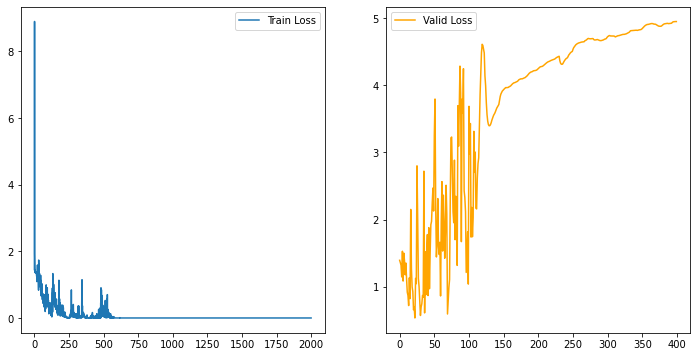

In [ ]:
tl = np.asarray(alexnet_train_losses).ravel()
vl = np.asarray(alexnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

In [ ]:
resnet_model_152

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#ResNet152
from torchvision.models import resnet152, ResNet152_Weights
weights = ResNet152_Weights.DEFAULT
resnet_model_152 = resnet152(weights=weights)
#resnet_model_152 = resnet34()
# resnet_model_152.fc = nn.Linear(512,50)
# resnet_model_152.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_classes = 4
num_ftrs= 2048
resnet_model_152.fc= nn.Linear(num_ftrs, num_classes)
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model_152.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
resnet_model_152 = resnet_model_152.to(device)
epochs = 400
loss_fn = nn.CrossEntropyLoss()
resnet_152_train_losses=[]
resnet_152_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%50==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

resnet_model_152 = train(resnet_model_152, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, resnet_152_train_losses, resnet_152_valid_losses, 'drive/Othercomputers/MyPC/R_D/models/resnet152.pth', lr_decay)

  0%|          | 1/400 [00:01<07:10,  1.08s/it]

Epoch - 1 Train-Loss : 0.011766615940723568
Validation loss decreased (-1.000000 --> 1.425737).  but not saving model (4C test)...
Epoch - 1 Valid-Loss : 1.425736665725708 Valid-Accuracy : 0.6190476190476191


  0%|          | 2/400 [00:02<07:08,  1.08s/it]

Epoch - 2 Train-Loss : 0.004009262775070965
Epoch - 2 Valid-Loss : 1.4297480583190918 Valid-Accuracy : 0.6190476190476191


  1%|          | 3/400 [00:03<07:01,  1.06s/it]

Epoch - 3 Train-Loss : 0.0023844948038458822
Validation loss decreased (1.425737 --> 1.409758).  but not saving model (4C test)...
Epoch - 3 Valid-Loss : 1.4097576141357422 Valid-Accuracy : 0.6190476190476191


  1%|          | 4/400 [00:04<06:58,  1.06s/it]

Epoch - 4 Train-Loss : 0.003780075255781412
Epoch - 4 Valid-Loss : 1.4244247674942017 Valid-Accuracy : 0.6190476190476191


  1%|▏         | 5/400 [00:05<06:55,  1.05s/it]

Epoch - 5 Train-Loss : 0.010359081672504544
Epoch - 5 Valid-Loss : 1.4378756284713745 Valid-Accuracy : 0.6190476190476191


  2%|▏         | 6/400 [00:06<06:54,  1.05s/it]

Epoch - 6 Train-Loss : 0.0049153435043990615
Epoch - 6 Valid-Loss : 1.4457863569259644 Valid-Accuracy : 0.6190476190476191


  2%|▏         | 7/400 [00:07<06:53,  1.05s/it]

Epoch - 7 Train-Loss : 0.009942674404010176
Epoch - 7 Valid-Loss : 1.4394677877426147 Valid-Accuracy : 0.6190476190476191


  2%|▏         | 8/400 [00:08<06:50,  1.05s/it]

Epoch - 8 Train-Loss : 0.004405012051574886
Epoch - 8 Valid-Loss : 1.4609994888305664 Valid-Accuracy : 0.6190476190476191


  2%|▏         | 9/400 [00:09<06:47,  1.04s/it]

Epoch - 9 Train-Loss : 0.007496716734021902
Epoch - 9 Valid-Loss : 1.4355542659759521 Valid-Accuracy : 0.6190476190476191


  2%|▎         | 10/400 [00:10<06:45,  1.04s/it]

Epoch - 10 Train-Loss : 0.050983695220202206
Epoch - 10 Valid-Loss : 1.4251070022583008 Valid-Accuracy : 0.6190476190476191


  3%|▎         | 11/400 [00:11<06:43,  1.04s/it]

Epoch - 11 Train-Loss : 0.014565837709233165
Epoch - 11 Valid-Loss : 1.4397701025009155 Valid-Accuracy : 0.6190476190476191


  3%|▎         | 12/400 [00:12<06:47,  1.05s/it]

Epoch - 12 Train-Loss : 0.015384067012928427
Epoch - 12 Valid-Loss : 1.4237927198410034 Valid-Accuracy : 0.6190476190476191


  3%|▎         | 13/400 [00:13<06:47,  1.05s/it]

Epoch - 13 Train-Loss : 0.04216324985027313
Epoch - 13 Valid-Loss : 1.4624103307724 Valid-Accuracy : 0.6190476190476191


  4%|▎         | 14/400 [00:14<06:46,  1.05s/it]

Epoch - 14 Train-Loss : 0.002281722263433039
Epoch - 14 Valid-Loss : 1.4310976266860962 Valid-Accuracy : 0.6190476190476191


  4%|▍         | 15/400 [00:15<06:43,  1.05s/it]

Epoch - 15 Train-Loss : 0.050240145460702476
Epoch - 15 Valid-Loss : 1.464167594909668 Valid-Accuracy : 0.6190476190476191


  4%|▍         | 16/400 [00:16<06:41,  1.05s/it]

Epoch - 16 Train-Loss : 0.002365411352366209
Epoch - 16 Valid-Loss : 1.4522203207015991 Valid-Accuracy : 0.6190476190476191


  4%|▍         | 17/400 [00:17<06:38,  1.04s/it]

Epoch - 17 Train-Loss : 0.013642098638229072
Epoch - 17 Valid-Loss : 1.4412240982055664 Valid-Accuracy : 0.6190476190476191


  4%|▍         | 18/400 [00:18<06:36,  1.04s/it]

Epoch - 18 Train-Loss : 0.03917729867389426
Epoch - 18 Valid-Loss : 1.439924716949463 Valid-Accuracy : 0.6190476190476191


  5%|▍         | 19/400 [00:19<06:35,  1.04s/it]

Epoch - 19 Train-Loss : 0.020627570478245615
Epoch - 19 Valid-Loss : 1.4299354553222656 Valid-Accuracy : 0.6190476190476191


  5%|▌         | 20/400 [00:20<06:34,  1.04s/it]

Epoch - 20 Train-Loss : 0.006559030944481492
Epoch - 20 Valid-Loss : 1.4272536039352417 Valid-Accuracy : 0.6190476190476191


  5%|▌         | 21/400 [00:21<06:32,  1.04s/it]

Epoch - 21 Train-Loss : 0.003620497020892799
Epoch - 21 Valid-Loss : 1.437021017074585 Valid-Accuracy : 0.6190476190476191


  6%|▌         | 22/400 [00:23<06:31,  1.04s/it]

Epoch - 22 Train-Loss : 0.033417339459992944
Epoch - 22 Valid-Loss : 1.4149748086929321 Valid-Accuracy : 0.6190476190476191


  6%|▌         | 23/400 [00:24<06:31,  1.04s/it]

Epoch - 23 Train-Loss : 0.04361919681541622
Epoch - 23 Valid-Loss : 1.419799566268921 Valid-Accuracy : 0.6190476190476191


  6%|▌         | 24/400 [00:25<06:31,  1.04s/it]

Epoch - 24 Train-Loss : 0.004649958992376924
Epoch - 24 Valid-Loss : 1.4442379474639893 Valid-Accuracy : 0.6190476190476191


  6%|▋         | 25/400 [00:26<06:29,  1.04s/it]

Epoch - 25 Train-Loss : 0.04379398613236844
Epoch - 25 Valid-Loss : 1.4513320922851562 Valid-Accuracy : 0.6190476190476191


  6%|▋         | 26/400 [00:27<06:29,  1.04s/it]

Epoch - 26 Train-Loss : 0.00932171787135303
Epoch - 26 Valid-Loss : 1.4596295356750488 Valid-Accuracy : 0.6190476190476191


  7%|▋         | 27/400 [00:28<06:27,  1.04s/it]

Epoch - 27 Train-Loss : 0.008563265041448175
Epoch - 27 Valid-Loss : 1.484492301940918 Valid-Accuracy : 0.6190476190476191


  7%|▋         | 28/400 [00:29<06:27,  1.04s/it]

Epoch - 28 Train-Loss : 0.004196218750439584
Epoch - 28 Valid-Loss : 1.449895977973938 Valid-Accuracy : 0.6190476190476191


  7%|▋         | 29/400 [00:30<06:26,  1.04s/it]

Epoch - 29 Train-Loss : 0.024547115713357926
Epoch - 29 Valid-Loss : 1.4705455303192139 Valid-Accuracy : 0.6190476190476191


  8%|▊         | 30/400 [00:31<06:24,  1.04s/it]

Epoch - 30 Train-Loss : 0.00609163026092574
Epoch - 30 Valid-Loss : 1.4570567607879639 Valid-Accuracy : 0.6190476190476191


  8%|▊         | 31/400 [00:32<06:24,  1.04s/it]

Epoch - 31 Train-Loss : 0.0031969308736734094
Epoch - 31 Valid-Loss : 1.509495735168457 Valid-Accuracy : 0.6190476190476191


  8%|▊         | 32/400 [00:33<06:23,  1.04s/it]

Epoch - 32 Train-Loss : 0.003835696470923722
Epoch - 32 Valid-Loss : 1.486041784286499 Valid-Accuracy : 0.6190476190476191


  8%|▊         | 33/400 [00:34<06:21,  1.04s/it]

Epoch - 33 Train-Loss : 0.017526368633843957
Epoch - 33 Valid-Loss : 1.488362431526184 Valid-Accuracy : 0.6190476190476191


  8%|▊         | 34/400 [00:35<06:21,  1.04s/it]

Epoch - 34 Train-Loss : 0.038432647474110126
Epoch - 34 Valid-Loss : 1.4553419351577759 Valid-Accuracy : 0.6190476190476191


  9%|▉         | 35/400 [00:36<06:19,  1.04s/it]

Epoch - 35 Train-Loss : 0.0874406236456707
Epoch - 35 Valid-Loss : 1.4650976657867432 Valid-Accuracy : 0.6190476190476191


  9%|▉         | 36/400 [00:37<06:17,  1.04s/it]

Epoch - 36 Train-Loss : 0.00943651022389531
Epoch - 36 Valid-Loss : 1.4622868299484253 Valid-Accuracy : 0.6190476190476191


  9%|▉         | 37/400 [00:38<06:16,  1.04s/it]

Epoch - 37 Train-Loss : 0.015789752616547047
Epoch - 37 Valid-Loss : 1.4906800985336304 Valid-Accuracy : 0.6190476190476191


 10%|▉         | 38/400 [00:39<06:18,  1.04s/it]

Epoch - 38 Train-Loss : 0.007634057966060937
Epoch - 38 Valid-Loss : 1.437227487564087 Valid-Accuracy : 0.6190476190476191


 10%|▉         | 39/400 [00:40<06:17,  1.05s/it]

Epoch - 39 Train-Loss : 0.009027234115637838
Epoch - 39 Valid-Loss : 1.5221036672592163 Valid-Accuracy : 0.6190476190476191


 10%|█         | 40/400 [00:41<06:16,  1.05s/it]

Epoch - 40 Train-Loss : 0.011194830108433963
Epoch - 40 Valid-Loss : 1.497883915901184 Valid-Accuracy : 0.6190476190476191


 10%|█         | 41/400 [00:42<06:16,  1.05s/it]

Epoch - 41 Train-Loss : 0.013337137759663165
Epoch - 41 Valid-Loss : 1.4622128009796143 Valid-Accuracy : 0.6190476190476191


 10%|█         | 42/400 [00:43<06:15,  1.05s/it]

Epoch - 42 Train-Loss : 0.002386970818042755
Epoch - 42 Valid-Loss : 1.445427656173706 Valid-Accuracy : 0.6190476190476191


 11%|█         | 43/400 [00:44<06:14,  1.05s/it]

Epoch - 43 Train-Loss : 0.021074889588635414
Epoch - 43 Valid-Loss : 1.4573423862457275 Valid-Accuracy : 0.6190476190476191


 11%|█         | 44/400 [00:45<06:13,  1.05s/it]

Epoch - 44 Train-Loss : 0.00652135347481817
Epoch - 44 Valid-Loss : 1.4263856410980225 Valid-Accuracy : 0.6190476190476191


 11%|█▏        | 45/400 [00:47<06:13,  1.05s/it]

Epoch - 45 Train-Loss : 0.005887714866548777
Epoch - 45 Valid-Loss : 1.421891450881958 Valid-Accuracy : 0.6190476190476191


 12%|█▏        | 46/400 [00:48<06:11,  1.05s/it]

Epoch - 46 Train-Loss : 0.0019774430082179608
Epoch - 46 Valid-Loss : 1.4278584718704224 Valid-Accuracy : 0.6190476190476191


 12%|█▏        | 47/400 [00:49<06:09,  1.05s/it]

Epoch - 47 Train-Loss : 0.005788698862306774
Epoch - 47 Valid-Loss : 1.428002953529358 Valid-Accuracy : 0.6190476190476191


 12%|█▏        | 48/400 [00:50<06:07,  1.05s/it]

Epoch - 48 Train-Loss : 0.04083993990207091
Epoch - 48 Valid-Loss : 1.4165066480636597 Valid-Accuracy : 0.6190476190476191


 12%|█▏        | 49/400 [00:51<06:05,  1.04s/it]

Epoch - 49 Train-Loss : 0.004395364667288959
Epoch - 49 Valid-Loss : 1.4145132303237915 Valid-Accuracy : 0.6190476190476191
Changed learning rate to 2e-10


 12%|█▎        | 50/400 [00:52<06:02,  1.04s/it]

Epoch - 50 Train-Loss : 0.028682443546131253
Validation loss decreased (1.409758 --> 1.380704).  but not saving model (4C test)...
Epoch - 50 Valid-Loss : 1.3807039260864258 Valid-Accuracy : 0.6190476190476191


 13%|█▎        | 51/400 [00:53<06:03,  1.04s/it]

Epoch - 51 Train-Loss : 0.02535873621236533
Epoch - 51 Valid-Loss : 1.3855587244033813 Valid-Accuracy : 0.6190476190476191


 13%|█▎        | 52/400 [00:54<06:03,  1.04s/it]

Epoch - 52 Train-Loss : 0.025772034330293535
Epoch - 52 Valid-Loss : 1.3858214616775513 Valid-Accuracy : 0.6190476190476191


 13%|█▎        | 53/400 [00:55<06:01,  1.04s/it]

Epoch - 53 Train-Loss : 0.06943276040256023
Epoch - 53 Valid-Loss : 1.4112144708633423 Valid-Accuracy : 0.6190476190476191


 14%|█▎        | 54/400 [00:56<05:59,  1.04s/it]

Epoch - 54 Train-Loss : 0.009940642304718495
Epoch - 54 Valid-Loss : 1.4334882497787476 Valid-Accuracy : 0.6190476190476191


 14%|█▍        | 55/400 [00:57<05:58,  1.04s/it]

Epoch - 55 Train-Loss : 0.0033994786674156783
Epoch - 55 Valid-Loss : 1.4361238479614258 Valid-Accuracy : 0.6190476190476191


 14%|█▍        | 56/400 [00:58<05:57,  1.04s/it]

Epoch - 56 Train-Loss : 0.03784791170619428
Epoch - 56 Valid-Loss : 1.466430902481079 Valid-Accuracy : 0.6190476190476191


 14%|█▍        | 57/400 [00:59<05:56,  1.04s/it]

Epoch - 57 Train-Loss : 0.00961897443048656
Epoch - 57 Valid-Loss : 1.446810245513916 Valid-Accuracy : 0.6190476190476191


 14%|█▍        | 58/400 [01:00<05:54,  1.04s/it]

Epoch - 58 Train-Loss : 0.035000226274132726
Epoch - 58 Valid-Loss : 1.4880199432373047 Valid-Accuracy : 0.6190476190476191


 15%|█▍        | 59/400 [01:01<05:52,  1.03s/it]

Epoch - 59 Train-Loss : 0.01929869505111128
Epoch - 59 Valid-Loss : 1.4770139455795288 Valid-Accuracy : 0.6190476190476191


 15%|█▌        | 60/400 [01:02<05:53,  1.04s/it]

Epoch - 60 Train-Loss : 0.0066085733938962225
Epoch - 60 Valid-Loss : 1.4512773752212524 Valid-Accuracy : 0.6190476190476191


 15%|█▌        | 61/400 [01:03<05:52,  1.04s/it]

Epoch - 61 Train-Loss : 0.024039644049480557
Epoch - 61 Valid-Loss : 1.4455032348632812 Valid-Accuracy : 0.6190476190476191


 16%|█▌        | 62/400 [01:04<05:54,  1.05s/it]

Epoch - 62 Train-Loss : 0.0033219415228813885
Epoch - 62 Valid-Loss : 1.4269901514053345 Valid-Accuracy : 0.6190476190476191


 16%|█▌        | 63/400 [01:05<05:52,  1.05s/it]

Epoch - 63 Train-Loss : 0.004266776365693658
Epoch - 63 Valid-Loss : 1.4292470216751099 Valid-Accuracy : 0.6190476190476191


 16%|█▌        | 64/400 [01:06<05:49,  1.04s/it]

Epoch - 64 Train-Loss : 0.009309892565943301
Epoch - 64 Valid-Loss : 1.435731053352356 Valid-Accuracy : 0.6190476190476191


 16%|█▋        | 65/400 [01:07<05:49,  1.04s/it]

Epoch - 65 Train-Loss : 0.005049331346526742
Epoch - 65 Valid-Loss : 1.4656202793121338 Valid-Accuracy : 0.6190476190476191


 16%|█▋        | 66/400 [01:08<05:48,  1.04s/it]

Epoch - 66 Train-Loss : 0.026474239281378688
Epoch - 66 Valid-Loss : 1.4528433084487915 Valid-Accuracy : 0.6190476190476191


 17%|█▋        | 67/400 [01:09<05:47,  1.04s/it]

Epoch - 67 Train-Loss : 0.02799517009407282
Epoch - 67 Valid-Loss : 1.4488179683685303 Valid-Accuracy : 0.6190476190476191


 17%|█▋        | 68/400 [01:10<05:46,  1.04s/it]

Epoch - 68 Train-Loss : 0.0020264487247914076
Epoch - 68 Valid-Loss : 1.4410481452941895 Valid-Accuracy : 0.6190476190476191


 17%|█▋        | 69/400 [01:12<05:44,  1.04s/it]

Epoch - 69 Train-Loss : 0.013808427518233657
Epoch - 69 Valid-Loss : 1.399847388267517 Valid-Accuracy : 0.6190476190476191


 18%|█▊        | 70/400 [01:13<05:44,  1.04s/it]

Epoch - 70 Train-Loss : 0.09022352355532348
Epoch - 70 Valid-Loss : 1.410441279411316 Valid-Accuracy : 0.6190476190476191


 18%|█▊        | 71/400 [01:14<05:42,  1.04s/it]

Epoch - 71 Train-Loss : 0.004392811190336942
Epoch - 71 Valid-Loss : 1.4195486307144165 Valid-Accuracy : 0.6190476190476191


 18%|█▊        | 72/400 [01:15<05:41,  1.04s/it]

Epoch - 72 Train-Loss : 0.0037755076307803394
Epoch - 72 Valid-Loss : 1.402391791343689 Valid-Accuracy : 0.6190476190476191


 18%|█▊        | 73/400 [01:16<05:40,  1.04s/it]

Epoch - 73 Train-Loss : 0.0075466227252036335
Epoch - 73 Valid-Loss : 1.4543027877807617 Valid-Accuracy : 0.6190476190476191


 18%|█▊        | 74/400 [01:17<05:39,  1.04s/it]

Epoch - 74 Train-Loss : 0.0034185789525508882
Epoch - 74 Valid-Loss : 1.489240050315857 Valid-Accuracy : 0.6190476190476191


 19%|█▉        | 75/400 [01:18<05:37,  1.04s/it]

Epoch - 75 Train-Loss : 0.026969185657799245
Epoch - 75 Valid-Loss : 1.441141963005066 Valid-Accuracy : 0.6190476190476191


 19%|█▉        | 76/400 [01:19<05:37,  1.04s/it]

Epoch - 76 Train-Loss : 0.003878053929656744
Epoch - 76 Valid-Loss : 1.4542502164840698 Valid-Accuracy : 0.6190476190476191


 19%|█▉        | 77/400 [01:20<05:37,  1.04s/it]

Epoch - 77 Train-Loss : 0.031685568299144505
Epoch - 77 Valid-Loss : 1.4499565362930298 Valid-Accuracy : 0.6190476190476191


 20%|█▉        | 78/400 [01:21<05:34,  1.04s/it]

Epoch - 78 Train-Loss : 0.017876953119412065
Epoch - 78 Valid-Loss : 1.442903757095337 Valid-Accuracy : 0.6190476190476191


 20%|█▉        | 79/400 [01:22<05:34,  1.04s/it]

Epoch - 79 Train-Loss : 0.0074860014021396635
Epoch - 79 Valid-Loss : 1.4271270036697388 Valid-Accuracy : 0.6190476190476191


 20%|██        | 80/400 [01:23<05:34,  1.05s/it]

Epoch - 80 Train-Loss : 0.011708353157155215
Epoch - 80 Valid-Loss : 1.4223970174789429 Valid-Accuracy : 0.6190476190476191


 20%|██        | 81/400 [01:24<05:32,  1.04s/it]

Epoch - 81 Train-Loss : 0.03572520082816481
Epoch - 81 Valid-Loss : 1.4155175685882568 Valid-Accuracy : 0.6190476190476191


 20%|██        | 82/400 [01:25<05:30,  1.04s/it]

Epoch - 82 Train-Loss : 0.0033159702084958552
Epoch - 82 Valid-Loss : 1.4115861654281616 Valid-Accuracy : 0.6190476190476191


 21%|██        | 83/400 [01:26<05:29,  1.04s/it]

Epoch - 83 Train-Loss : 0.008229367574676872
Epoch - 83 Valid-Loss : 1.4100761413574219 Valid-Accuracy : 0.6190476190476191


 21%|██        | 84/400 [01:27<05:28,  1.04s/it]

Epoch - 84 Train-Loss : 0.033691800956148654
Epoch - 84 Valid-Loss : 1.4331728219985962 Valid-Accuracy : 0.6190476190476191


 21%|██▏       | 85/400 [01:28<05:26,  1.04s/it]

Epoch - 85 Train-Loss : 0.0032402033917605876
Epoch - 85 Valid-Loss : 1.4216959476470947 Valid-Accuracy : 0.6190476190476191


 22%|██▏       | 86/400 [01:29<05:25,  1.04s/it]

Epoch - 86 Train-Loss : 0.0057258322602137925
Epoch - 86 Valid-Loss : 1.4002745151519775 Valid-Accuracy : 0.6190476190476191


 22%|██▏       | 87/400 [01:30<05:24,  1.04s/it]

Epoch - 87 Train-Loss : 0.03779317610897124
Epoch - 87 Valid-Loss : 1.4048539400100708 Valid-Accuracy : 0.6190476190476191


 22%|██▏       | 88/400 [01:31<05:23,  1.04s/it]

Epoch - 88 Train-Loss : 0.0024500072468072176
Epoch - 88 Valid-Loss : 1.4291595220565796 Valid-Accuracy : 0.6190476190476191


 22%|██▏       | 89/400 [01:32<05:22,  1.04s/it]

Epoch - 89 Train-Loss : 0.0027145522879436614
Epoch - 89 Valid-Loss : 1.423880934715271 Valid-Accuracy : 0.6190476190476191


 22%|██▎       | 90/400 [01:33<05:22,  1.04s/it]

Epoch - 90 Train-Loss : 0.0049715143162757155
Epoch - 90 Valid-Loss : 1.4070378541946411 Valid-Accuracy : 0.6190476190476191


 23%|██▎       | 91/400 [01:34<05:20,  1.04s/it]

Epoch - 91 Train-Loss : 0.04926026673056185
Epoch - 91 Valid-Loss : 1.3853652477264404 Valid-Accuracy : 0.6190476190476191


 23%|██▎       | 92/400 [01:35<05:19,  1.04s/it]

Epoch - 92 Train-Loss : 0.02973105318378657
Epoch - 92 Valid-Loss : 1.4159246683120728 Valid-Accuracy : 0.6190476190476191


 23%|██▎       | 93/400 [01:36<05:18,  1.04s/it]

Epoch - 93 Train-Loss : 0.0329749456839636
Epoch - 93 Valid-Loss : 1.417933464050293 Valid-Accuracy : 0.6190476190476191


 24%|██▎       | 94/400 [01:38<05:20,  1.05s/it]

Epoch - 94 Train-Loss : 0.004270101618021727
Epoch - 94 Valid-Loss : 1.4251739978790283 Valid-Accuracy : 0.6190476190476191


 24%|██▍       | 95/400 [01:39<05:18,  1.04s/it]

Epoch - 95 Train-Loss : 0.044657789077609776
Epoch - 95 Valid-Loss : 1.4256491661071777 Valid-Accuracy : 0.6190476190476191


 24%|██▍       | 96/400 [01:40<05:17,  1.04s/it]

Epoch - 96 Train-Loss : 0.0061272133607417345
Epoch - 96 Valid-Loss : 1.503770112991333 Valid-Accuracy : 0.6190476190476191


 24%|██▍       | 97/400 [01:41<05:15,  1.04s/it]

Epoch - 97 Train-Loss : 0.03448932620231062
Epoch - 97 Valid-Loss : 1.4638537168502808 Valid-Accuracy : 0.6190476190476191


 24%|██▍       | 98/400 [01:42<05:16,  1.05s/it]

Epoch - 98 Train-Loss : 0.04582556672394276
Epoch - 98 Valid-Loss : 1.4486925601959229 Valid-Accuracy : 0.6190476190476191


 25%|██▍       | 99/400 [01:43<05:15,  1.05s/it]

Epoch - 99 Train-Loss : 0.0038309430703520773
Epoch - 99 Valid-Loss : 1.4339090585708618 Valid-Accuracy : 0.6190476190476191
Changed learning rate to 2e-15


 25%|██▌       | 100/400 [01:44<05:13,  1.05s/it]

Epoch - 100 Train-Loss : 0.005200428422540426
Epoch - 100 Valid-Loss : 1.4191882610321045 Valid-Accuracy : 0.6190476190476191


 25%|██▌       | 101/400 [01:45<05:14,  1.05s/it]

Epoch - 101 Train-Loss : 0.025722389202564956
Epoch - 101 Valid-Loss : 1.4836180210113525 Valid-Accuracy : 0.6190476190476191


 26%|██▌       | 102/400 [01:46<05:12,  1.05s/it]

Epoch - 102 Train-Loss : 0.004087581904605031
Epoch - 102 Valid-Loss : 1.4817858934402466 Valid-Accuracy : 0.6190476190476191


 26%|██▌       | 103/400 [01:47<05:13,  1.05s/it]

Epoch - 103 Train-Loss : 0.028882519085891546
Epoch - 103 Valid-Loss : 1.4656206369400024 Valid-Accuracy : 0.6190476190476191


 26%|██▌       | 104/400 [01:48<05:10,  1.05s/it]

Epoch - 104 Train-Loss : 0.015079657500609755
Epoch - 104 Valid-Loss : 1.4689284563064575 Valid-Accuracy : 0.6190476190476191


 26%|██▋       | 105/400 [01:49<05:09,  1.05s/it]

Epoch - 105 Train-Loss : 0.03026520777493715
Epoch - 105 Valid-Loss : 1.4468971490859985 Valid-Accuracy : 0.6190476190476191


 26%|██▋       | 106/400 [01:50<05:06,  1.04s/it]

Epoch - 106 Train-Loss : 0.041159630147740246
Epoch - 106 Valid-Loss : 1.4521300792694092 Valid-Accuracy : 0.6190476190476191


 27%|██▋       | 107/400 [01:51<05:05,  1.04s/it]

Epoch - 107 Train-Loss : 0.007015332183800638
Epoch - 107 Valid-Loss : 1.4689000844955444 Valid-Accuracy : 0.6190476190476191


 27%|██▋       | 108/400 [01:52<05:04,  1.04s/it]

Epoch - 108 Train-Loss : 0.08985344842076301
Epoch - 108 Valid-Loss : 1.4476372003555298 Valid-Accuracy : 0.6190476190476191


 27%|██▋       | 109/400 [01:53<05:02,  1.04s/it]

Epoch - 109 Train-Loss : 0.029535923502407968
Epoch - 109 Valid-Loss : 1.457747459411621 Valid-Accuracy : 0.6190476190476191


 28%|██▊       | 110/400 [01:54<05:02,  1.04s/it]

Epoch - 110 Train-Loss : 0.029405893350485712
Epoch - 110 Valid-Loss : 1.4588130712509155 Valid-Accuracy : 0.6190476190476191


 28%|██▊       | 111/400 [01:55<05:01,  1.04s/it]

Epoch - 111 Train-Loss : 0.005410913121886551
Epoch - 111 Valid-Loss : 1.442832589149475 Valid-Accuracy : 0.6190476190476191


 28%|██▊       | 112/400 [01:56<04:59,  1.04s/it]

Epoch - 112 Train-Loss : 0.005156709859147668
Epoch - 112 Valid-Loss : 1.4654146432876587 Valid-Accuracy : 0.6190476190476191


 28%|██▊       | 113/400 [01:57<04:57,  1.04s/it]

Epoch - 113 Train-Loss : 0.019311309233307837
Epoch - 113 Valid-Loss : 1.4601010084152222 Valid-Accuracy : 0.6190476190476191


 28%|██▊       | 114/400 [01:58<04:56,  1.04s/it]

Epoch - 114 Train-Loss : 0.03824013991979882
Epoch - 114 Valid-Loss : 1.4628548622131348 Valid-Accuracy : 0.6190476190476191


 29%|██▉       | 115/400 [01:59<04:55,  1.04s/it]

Epoch - 115 Train-Loss : 0.006746449711499736
Epoch - 115 Valid-Loss : 1.4222452640533447 Valid-Accuracy : 0.6190476190476191


 29%|██▉       | 116/400 [02:00<04:54,  1.04s/it]

Epoch - 116 Train-Loss : 0.003475811961106956
Epoch - 116 Valid-Loss : 1.4168108701705933 Valid-Accuracy : 0.6190476190476191


 29%|██▉       | 117/400 [02:02<04:54,  1.04s/it]

Epoch - 117 Train-Loss : 0.05583957410417497
Epoch - 117 Valid-Loss : 1.4260296821594238 Valid-Accuracy : 0.6190476190476191


 30%|██▉       | 118/400 [02:03<04:53,  1.04s/it]

Epoch - 118 Train-Loss : 0.005530897388234734
Epoch - 118 Valid-Loss : 1.4093809127807617 Valid-Accuracy : 0.6190476190476191


 30%|██▉       | 119/400 [02:04<04:52,  1.04s/it]

Epoch - 119 Train-Loss : 0.023051273124292494
Epoch - 119 Valid-Loss : 1.422972321510315 Valid-Accuracy : 0.6190476190476191


 30%|███       | 120/400 [02:05<04:52,  1.04s/it]

Epoch - 120 Train-Loss : 0.0026388953207060694
Epoch - 120 Valid-Loss : 1.3889473676681519 Valid-Accuracy : 0.6190476190476191


 30%|███       | 121/400 [02:06<04:51,  1.04s/it]

Epoch - 121 Train-Loss : 0.07167321925517171
Epoch - 121 Valid-Loss : 1.4293245077133179 Valid-Accuracy : 0.6190476190476191


 30%|███       | 122/400 [02:07<04:49,  1.04s/it]

Epoch - 122 Train-Loss : 0.007193174841813743
Epoch - 122 Valid-Loss : 1.4314848184585571 Valid-Accuracy : 0.6190476190476191


 31%|███       | 123/400 [02:08<04:47,  1.04s/it]

Epoch - 123 Train-Loss : 0.035494716046378015
Epoch - 123 Valid-Loss : 1.4369851350784302 Valid-Accuracy : 0.6190476190476191


 31%|███       | 124/400 [02:09<04:47,  1.04s/it]

Epoch - 124 Train-Loss : 0.006012146756984293
Epoch - 124 Valid-Loss : 1.443373680114746 Valid-Accuracy : 0.6190476190476191


 31%|███▏      | 125/400 [02:10<04:45,  1.04s/it]

Epoch - 125 Train-Loss : 0.004790971800684929
Epoch - 125 Valid-Loss : 1.4457311630249023 Valid-Accuracy : 0.6190476190476191


 32%|███▏      | 126/400 [02:11<04:43,  1.03s/it]

Epoch - 126 Train-Loss : 0.011213383357971906
Epoch - 126 Valid-Loss : 1.4241691827774048 Valid-Accuracy : 0.6190476190476191


 32%|███▏      | 127/400 [02:12<04:42,  1.04s/it]

Epoch - 127 Train-Loss : 0.018593288958072662
Epoch - 127 Valid-Loss : 1.4555565118789673 Valid-Accuracy : 0.6190476190476191


 32%|███▏      | 128/400 [02:13<04:41,  1.03s/it]

Epoch - 128 Train-Loss : 0.027258767234161495
Epoch - 128 Valid-Loss : 1.501650094985962 Valid-Accuracy : 0.6190476190476191


 32%|███▏      | 129/400 [02:14<04:39,  1.03s/it]

Epoch - 129 Train-Loss : 0.005976762797217816
Epoch - 129 Valid-Loss : 1.5128202438354492 Valid-Accuracy : 0.6190476190476191


 32%|███▎      | 130/400 [02:15<04:38,  1.03s/it]

Epoch - 130 Train-Loss : 0.034082142962142827
Epoch - 130 Valid-Loss : 1.4966821670532227 Valid-Accuracy : 0.6190476190476191


 33%|███▎      | 131/400 [02:16<04:38,  1.03s/it]

Epoch - 131 Train-Loss : 0.003031582641415298
Epoch - 131 Valid-Loss : 1.4346990585327148 Valid-Accuracy : 0.6190476190476191


 33%|███▎      | 132/400 [02:17<04:37,  1.03s/it]

Epoch - 132 Train-Loss : 0.015087330574169755
Epoch - 132 Valid-Loss : 1.409330129623413 Valid-Accuracy : 0.6190476190476191


 33%|███▎      | 133/400 [02:18<04:36,  1.04s/it]

Epoch - 133 Train-Loss : 0.007421135134063661
Epoch - 133 Valid-Loss : 1.4142663478851318 Valid-Accuracy : 0.6190476190476191


 34%|███▎      | 134/400 [02:19<04:36,  1.04s/it]

Epoch - 134 Train-Loss : 0.025792627246119082
Epoch - 134 Valid-Loss : 1.437709927558899 Valid-Accuracy : 0.6190476190476191


 34%|███▍      | 135/400 [02:20<04:36,  1.04s/it]

Epoch - 135 Train-Loss : 0.0024143256014212966
Epoch - 135 Valid-Loss : 1.4378153085708618 Valid-Accuracy : 0.6190476190476191


 34%|███▍      | 136/400 [02:21<04:35,  1.04s/it]

Epoch - 136 Train-Loss : 0.002396310237236321
Epoch - 136 Valid-Loss : 1.4507200717926025 Valid-Accuracy : 0.6190476190476191


 34%|███▍      | 137/400 [02:22<04:34,  1.04s/it]

Epoch - 137 Train-Loss : 0.021331942128017544
Epoch - 137 Valid-Loss : 1.4416649341583252 Valid-Accuracy : 0.6190476190476191


 34%|███▍      | 138/400 [02:23<04:33,  1.04s/it]

Epoch - 138 Train-Loss : 0.0137561637442559
Epoch - 138 Valid-Loss : 1.432921051979065 Valid-Accuracy : 0.6190476190476191


 35%|███▍      | 139/400 [02:24<04:32,  1.04s/it]

Epoch - 139 Train-Loss : 0.005137256719172001
Epoch - 139 Valid-Loss : 1.424111008644104 Valid-Accuracy : 0.6190476190476191


 35%|███▌      | 140/400 [02:25<04:30,  1.04s/it]

Epoch - 140 Train-Loss : 0.002763051353394985
Epoch - 140 Valid-Loss : 1.445730447769165 Valid-Accuracy : 0.6190476190476191


 35%|███▌      | 141/400 [02:26<04:30,  1.04s/it]

Epoch - 141 Train-Loss : 0.014676421252079307
Epoch - 141 Valid-Loss : 1.4359170198440552 Valid-Accuracy : 0.6190476190476191


 36%|███▌      | 142/400 [02:28<04:30,  1.05s/it]

Epoch - 142 Train-Loss : 0.028086823970079423
Epoch - 142 Valid-Loss : 1.435059905052185 Valid-Accuracy : 0.6190476190476191


 36%|███▌      | 143/400 [02:29<04:28,  1.05s/it]

Epoch - 143 Train-Loss : 0.0025611951714381576
Epoch - 143 Valid-Loss : 1.4471763372421265 Valid-Accuracy : 0.6190476190476191


 36%|███▌      | 144/400 [02:30<04:27,  1.04s/it]

Epoch - 144 Train-Loss : 0.016548965126276016
Epoch - 144 Valid-Loss : 1.4120019674301147 Valid-Accuracy : 0.6190476190476191


 36%|███▋      | 145/400 [02:31<04:25,  1.04s/it]

Epoch - 145 Train-Loss : 0.019726856029592454
Epoch - 145 Valid-Loss : 1.4621260166168213 Valid-Accuracy : 0.6190476190476191


 36%|███▋      | 146/400 [02:32<04:24,  1.04s/it]

Epoch - 146 Train-Loss : 0.018107987055554987
Epoch - 146 Valid-Loss : 1.4549013376235962 Valid-Accuracy : 0.6190476190476191


 37%|███▋      | 147/400 [02:33<04:24,  1.05s/it]

Epoch - 147 Train-Loss : 0.026145715732127428
Epoch - 147 Valid-Loss : 1.469613790512085 Valid-Accuracy : 0.6190476190476191


 37%|███▋      | 148/400 [02:34<04:23,  1.05s/it]

Epoch - 148 Train-Loss : 0.01940613363403827
Epoch - 148 Valid-Loss : 1.4621366262435913 Valid-Accuracy : 0.6190476190476191


 37%|███▋      | 149/400 [02:35<04:22,  1.04s/it]

Epoch - 149 Train-Loss : 0.0034694427042268215
Epoch - 149 Valid-Loss : 1.452574610710144 Valid-Accuracy : 0.6190476190476191
Changed learning rate to 2.0000000000000002e-20


 38%|███▊      | 150/400 [02:36<04:23,  1.05s/it]

Epoch - 150 Train-Loss : 0.005055746459402144
Epoch - 150 Valid-Loss : 1.4366743564605713 Valid-Accuracy : 0.6190476190476191


 38%|███▊      | 151/400 [02:37<04:21,  1.05s/it]

Epoch - 151 Train-Loss : 0.02157644461840391
Epoch - 151 Valid-Loss : 1.443507194519043 Valid-Accuracy : 0.6190476190476191


 38%|███▊      | 152/400 [02:38<04:19,  1.05s/it]

Epoch - 152 Train-Loss : 0.013173938170075417
Epoch - 152 Valid-Loss : 1.433286428451538 Valid-Accuracy : 0.6190476190476191


 38%|███▊      | 153/400 [02:39<04:17,  1.04s/it]

Epoch - 153 Train-Loss : 0.007873730408027768
Epoch - 153 Valid-Loss : 1.4553937911987305 Valid-Accuracy : 0.6190476190476191


 38%|███▊      | 154/400 [02:40<04:16,  1.04s/it]

Epoch - 154 Train-Loss : 0.013273272686637938
Epoch - 154 Valid-Loss : 1.4256415367126465 Valid-Accuracy : 0.6190476190476191


 39%|███▉      | 155/400 [02:41<04:15,  1.04s/it]

Epoch - 155 Train-Loss : 0.005246530496515333
Epoch - 155 Valid-Loss : 1.4217466115951538 Valid-Accuracy : 0.6190476190476191


 39%|███▉      | 156/400 [02:42<04:15,  1.05s/it]

Epoch - 156 Train-Loss : 0.019996410445310177
Epoch - 156 Valid-Loss : 1.4291499853134155 Valid-Accuracy : 0.6190476190476191


 39%|███▉      | 157/400 [02:43<04:14,  1.05s/it]

Epoch - 157 Train-Loss : 0.017931156349368392
Epoch - 157 Valid-Loss : 1.422290325164795 Valid-Accuracy : 0.6190476190476191


 40%|███▉      | 158/400 [02:44<04:13,  1.05s/it]

Epoch - 158 Train-Loss : 0.042923494044225664
Epoch - 158 Valid-Loss : 1.4105747938156128 Valid-Accuracy : 0.6190476190476191


 40%|███▉      | 159/400 [02:45<04:11,  1.05s/it]

Epoch - 159 Train-Loss : 0.02158276967238635
Epoch - 159 Valid-Loss : 1.4412665367126465 Valid-Accuracy : 0.6190476190476191


 40%|████      | 160/400 [02:46<04:09,  1.04s/it]

Epoch - 160 Train-Loss : 0.007473851833492517
Epoch - 160 Valid-Loss : 1.4609227180480957 Valid-Accuracy : 0.6190476190476191


 40%|████      | 161/400 [02:47<04:08,  1.04s/it]

Epoch - 161 Train-Loss : 0.00483835618942976
Epoch - 161 Valid-Loss : 1.4369851350784302 Valid-Accuracy : 0.6190476190476191


 40%|████      | 162/400 [02:48<04:06,  1.04s/it]

Epoch - 162 Train-Loss : 0.004195286228787154
Epoch - 162 Valid-Loss : 1.4382368326187134 Valid-Accuracy : 0.6190476190476191


 41%|████      | 163/400 [02:49<04:05,  1.04s/it]

Epoch - 163 Train-Loss : 0.009454582375474275
Epoch - 163 Valid-Loss : 1.4289404153823853 Valid-Accuracy : 0.6190476190476191


 41%|████      | 164/400 [02:50<04:04,  1.04s/it]

Epoch - 164 Train-Loss : 0.007381469360552728
Epoch - 164 Valid-Loss : 1.4071595668792725 Valid-Accuracy : 0.6190476190476191


 41%|████▏     | 165/400 [02:52<04:03,  1.04s/it]

Epoch - 165 Train-Loss : 0.05571302580647171
Epoch - 165 Valid-Loss : 1.4045957326889038 Valid-Accuracy : 0.6190476190476191


 42%|████▏     | 166/400 [02:53<04:02,  1.04s/it]

Epoch - 166 Train-Loss : 0.0065372530836611984
Epoch - 166 Valid-Loss : 1.431703805923462 Valid-Accuracy : 0.6190476190476191


 42%|████▏     | 167/400 [02:54<04:01,  1.04s/it]

Epoch - 167 Train-Loss : 0.008739586651790887
Epoch - 167 Valid-Loss : 1.414819598197937 Valid-Accuracy : 0.6190476190476191


 42%|████▏     | 168/400 [02:55<03:59,  1.03s/it]

Epoch - 168 Train-Loss : 0.0026729409117251636
Epoch - 168 Valid-Loss : 1.4273303747177124 Valid-Accuracy : 0.6190476190476191


 42%|████▏     | 169/400 [02:56<03:59,  1.04s/it]

Epoch - 169 Train-Loss : 0.05859035985777154
Epoch - 169 Valid-Loss : 1.43230402469635 Valid-Accuracy : 0.6190476190476191


 42%|████▎     | 170/400 [02:57<03:57,  1.03s/it]

Epoch - 170 Train-Loss : 0.0018351296312175691
Epoch - 170 Valid-Loss : 1.454264521598816 Valid-Accuracy : 0.6190476190476191


 43%|████▎     | 171/400 [02:58<03:57,  1.04s/it]

Epoch - 171 Train-Loss : 0.0041631042491644624
Epoch - 171 Valid-Loss : 1.4796581268310547 Valid-Accuracy : 0.6190476190476191


 43%|████▎     | 172/400 [02:59<03:56,  1.04s/it]

Epoch - 172 Train-Loss : 0.009542979043908417
Epoch - 172 Valid-Loss : 1.4878277778625488 Valid-Accuracy : 0.6190476190476191


 43%|████▎     | 173/400 [03:00<03:56,  1.04s/it]

Epoch - 173 Train-Loss : 0.03854232132434845
Epoch - 173 Valid-Loss : 1.4604058265686035 Valid-Accuracy : 0.6190476190476191


 44%|████▎     | 174/400 [03:01<03:54,  1.04s/it]

Epoch - 174 Train-Loss : 0.005640891869552434
Epoch - 174 Valid-Loss : 1.506563425064087 Valid-Accuracy : 0.6190476190476191


 44%|████▍     | 175/400 [03:02<03:53,  1.04s/it]

Epoch - 175 Train-Loss : 0.04635779894888401
Epoch - 175 Valid-Loss : 1.513158917427063 Valid-Accuracy : 0.6190476190476191


 44%|████▍     | 176/400 [03:03<03:52,  1.04s/it]

Epoch - 176 Train-Loss : 0.008126919250935316
Epoch - 176 Valid-Loss : 1.4718085527420044 Valid-Accuracy : 0.6190476190476191


 44%|████▍     | 177/400 [03:04<03:51,  1.04s/it]

Epoch - 177 Train-Loss : 0.008485024073161184
Epoch - 177 Valid-Loss : 1.4445250034332275 Valid-Accuracy : 0.6190476190476191


 44%|████▍     | 178/400 [03:05<03:50,  1.04s/it]

Epoch - 178 Train-Loss : 0.00907505927607417
Epoch - 178 Valid-Loss : 1.451539158821106 Valid-Accuracy : 0.6190476190476191


 45%|████▍     | 179/400 [03:06<03:49,  1.04s/it]

Epoch - 179 Train-Loss : 0.04076128334272653
Epoch - 179 Valid-Loss : 1.4495209455490112 Valid-Accuracy : 0.6190476190476191


 45%|████▌     | 180/400 [03:07<03:48,  1.04s/it]

Epoch - 180 Train-Loss : 0.016194308834383265
Epoch - 180 Valid-Loss : 1.4101712703704834 Valid-Accuracy : 0.6190476190476191


 45%|████▌     | 181/400 [03:08<03:47,  1.04s/it]

Epoch - 181 Train-Loss : 0.0060850126203149555
Epoch - 181 Valid-Loss : 1.4024887084960938 Valid-Accuracy : 0.6190476190476191


 46%|████▌     | 182/400 [03:09<03:45,  1.04s/it]

Epoch - 182 Train-Loss : 0.05714715344365686
Epoch - 182 Valid-Loss : 1.4321529865264893 Valid-Accuracy : 0.6190476190476191


 46%|████▌     | 183/400 [03:10<03:44,  1.04s/it]

Epoch - 183 Train-Loss : 0.019542570505291224
Epoch - 183 Valid-Loss : 1.4182796478271484 Valid-Accuracy : 0.6190476190476191


 46%|████▌     | 184/400 [03:11<03:44,  1.04s/it]

Epoch - 184 Train-Loss : 0.04167520387563854
Epoch - 184 Valid-Loss : 1.452276587486267 Valid-Accuracy : 0.6190476190476191


 46%|████▋     | 185/400 [03:12<03:45,  1.05s/it]

Epoch - 185 Train-Loss : 0.04134086453123018
Epoch - 185 Valid-Loss : 1.441835880279541 Valid-Accuracy : 0.6190476190476191


 46%|████▋     | 186/400 [03:13<03:43,  1.05s/it]

Epoch - 186 Train-Loss : 0.03842214271426201
Epoch - 186 Valid-Loss : 1.3988540172576904 Valid-Accuracy : 0.6190476190476191


 47%|████▋     | 187/400 [03:14<03:42,  1.04s/it]

Epoch - 187 Train-Loss : 0.013203800888732076
Epoch - 187 Valid-Loss : 1.469910740852356 Valid-Accuracy : 0.6190476190476191


 47%|████▋     | 188/400 [03:15<03:41,  1.04s/it]

Epoch - 188 Train-Loss : 0.0595698177581653
Epoch - 188 Valid-Loss : 1.4951905012130737 Valid-Accuracy : 0.6190476190476191


 47%|████▋     | 189/400 [03:16<03:40,  1.05s/it]

Epoch - 189 Train-Loss : 0.00792294591665268
Epoch - 189 Valid-Loss : 1.4603756666183472 Valid-Accuracy : 0.6190476190476191


 48%|████▊     | 190/400 [03:18<03:39,  1.05s/it]

Epoch - 190 Train-Loss : 0.01232613034080714
Epoch - 190 Valid-Loss : 1.4772733449935913 Valid-Accuracy : 0.6190476190476191


 48%|████▊     | 191/400 [03:19<03:38,  1.04s/it]

Epoch - 191 Train-Loss : 0.01767158827278763
Epoch - 191 Valid-Loss : 1.4857019186019897 Valid-Accuracy : 0.6190476190476191


 48%|████▊     | 192/400 [03:20<03:46,  1.09s/it]

Epoch - 192 Train-Loss : 0.03126909588463604
Epoch - 192 Valid-Loss : 1.439728021621704 Valid-Accuracy : 0.6190476190476191


 48%|████▊     | 193/400 [03:21<03:43,  1.08s/it]

Epoch - 193 Train-Loss : 0.013553460175171495
Epoch - 193 Valid-Loss : 1.42646324634552 Valid-Accuracy : 0.6190476190476191


 48%|████▊     | 194/400 [03:22<03:40,  1.07s/it]

Epoch - 194 Train-Loss : 0.005350994458422065
Epoch - 194 Valid-Loss : 1.4261095523834229 Valid-Accuracy : 0.6190476190476191


 49%|████▉     | 195/400 [03:23<03:37,  1.06s/it]

Epoch - 195 Train-Loss : 0.0483182143419981
Epoch - 195 Valid-Loss : 1.427562952041626 Valid-Accuracy : 0.6190476190476191


 49%|████▉     | 196/400 [03:24<03:35,  1.06s/it]

Epoch - 196 Train-Loss : 0.022382260649465024
Epoch - 196 Valid-Loss : 1.3974339962005615 Valid-Accuracy : 0.6190476190476191


 49%|████▉     | 197/400 [03:25<03:32,  1.05s/it]

Epoch - 197 Train-Loss : 0.0038858659332618116
Epoch - 197 Valid-Loss : 1.417857050895691 Valid-Accuracy : 0.6190476190476191


 50%|████▉     | 198/400 [03:26<03:31,  1.05s/it]

Epoch - 198 Train-Loss : 0.02260256842710078
Epoch - 198 Valid-Loss : 1.4175174236297607 Valid-Accuracy : 0.6190476190476191


 50%|████▉     | 199/400 [03:27<03:30,  1.05s/it]

Epoch - 199 Train-Loss : 0.062003743508830665
Epoch - 199 Valid-Loss : 1.450201153755188 Valid-Accuracy : 0.6190476190476191
Changed learning rate to 2e-25


 50%|█████     | 200/400 [03:28<03:29,  1.05s/it]

Epoch - 200 Train-Loss : 0.0800222183810547
Epoch - 200 Valid-Loss : 1.4337379932403564 Valid-Accuracy : 0.6190476190476191


 50%|█████     | 201/400 [03:29<03:28,  1.05s/it]

Epoch - 201 Train-Loss : 0.003964629722759128
Epoch - 201 Valid-Loss : 1.3920356035232544 Valid-Accuracy : 0.6190476190476191


 50%|█████     | 202/400 [03:30<03:26,  1.04s/it]

Epoch - 202 Train-Loss : 0.003420425206422806
Epoch - 202 Valid-Loss : 1.3934497833251953 Valid-Accuracy : 0.6190476190476191


 51%|█████     | 203/400 [03:31<03:24,  1.04s/it]

Epoch - 203 Train-Loss : 0.01394190660212189
Epoch - 203 Valid-Loss : 1.4184491634368896 Valid-Accuracy : 0.6190476190476191


 51%|█████     | 204/400 [03:32<03:22,  1.03s/it]

Epoch - 204 Train-Loss : 0.010503104072995484
Epoch - 204 Valid-Loss : 1.4053560495376587 Valid-Accuracy : 0.6190476190476191


 51%|█████▏    | 205/400 [03:33<03:21,  1.03s/it]

Epoch - 205 Train-Loss : 0.07180385552346706
Epoch - 205 Valid-Loss : 1.3967050313949585 Valid-Accuracy : 0.6190476190476191


 52%|█████▏    | 206/400 [03:34<03:20,  1.03s/it]

Epoch - 206 Train-Loss : 0.0033236357267014682
Epoch - 206 Valid-Loss : 1.4093698263168335 Valid-Accuracy : 0.6190476190476191


 52%|█████▏    | 207/400 [03:35<03:19,  1.03s/it]

Epoch - 207 Train-Loss : 0.002960418548900634
Epoch - 207 Valid-Loss : 1.4174314737319946 Valid-Accuracy : 0.6190476190476191


 52%|█████▏    | 208/400 [03:36<03:18,  1.03s/it]

Epoch - 208 Train-Loss : 0.0027089891023933887
Epoch - 208 Valid-Loss : 1.4382354021072388 Valid-Accuracy : 0.6190476190476191


 52%|█████▏    | 209/400 [03:37<03:16,  1.03s/it]

Epoch - 209 Train-Loss : 0.011433490528725087
Epoch - 209 Valid-Loss : 1.4299826622009277 Valid-Accuracy : 0.6190476190476191


 52%|█████▎    | 210/400 [03:38<03:16,  1.04s/it]

Epoch - 210 Train-Loss : 0.028446843288838862
Epoch - 210 Valid-Loss : 1.427295446395874 Valid-Accuracy : 0.6190476190476191


 53%|█████▎    | 211/400 [03:40<03:18,  1.05s/it]

Epoch - 211 Train-Loss : 0.004035064077470452
Epoch - 211 Valid-Loss : 1.4584617614746094 Valid-Accuracy : 0.6190476190476191


 53%|█████▎    | 212/400 [03:41<03:17,  1.05s/it]

Epoch - 212 Train-Loss : 0.07438097586855293
Epoch - 212 Valid-Loss : 1.4631328582763672 Valid-Accuracy : 0.6190476190476191


 53%|█████▎    | 213/400 [03:42<03:15,  1.05s/it]

Epoch - 213 Train-Loss : 0.014977277908474206
Epoch - 213 Valid-Loss : 1.4316577911376953 Valid-Accuracy : 0.6190476190476191


 54%|█████▎    | 214/400 [03:43<03:13,  1.04s/it]

Epoch - 214 Train-Loss : 0.016546747414395213
Epoch - 214 Valid-Loss : 1.4163081645965576 Valid-Accuracy : 0.6190476190476191


 54%|█████▍    | 215/400 [03:44<03:12,  1.04s/it]

Epoch - 215 Train-Loss : 0.029820353968534618
Epoch - 215 Valid-Loss : 1.443598985671997 Valid-Accuracy : 0.6190476190476191


 54%|█████▍    | 216/400 [03:45<03:11,  1.04s/it]

Epoch - 216 Train-Loss : 0.003578900755383074
Epoch - 216 Valid-Loss : 1.4615552425384521 Valid-Accuracy : 0.6190476190476191


 54%|█████▍    | 217/400 [03:46<03:10,  1.04s/it]

Epoch - 217 Train-Loss : 0.0050061123445630075
Epoch - 217 Valid-Loss : 1.4235740900039673 Valid-Accuracy : 0.6190476190476191


 55%|█████▍    | 218/400 [03:47<03:10,  1.04s/it]

Epoch - 218 Train-Loss : 0.025653895805589855
Epoch - 218 Valid-Loss : 1.4640824794769287 Valid-Accuracy : 0.6190476190476191


 55%|█████▍    | 219/400 [03:48<03:10,  1.05s/it]

Epoch - 219 Train-Loss : 0.040245701745152476
Epoch - 219 Valid-Loss : 1.4376757144927979 Valid-Accuracy : 0.6190476190476191


 55%|█████▌    | 220/400 [03:49<03:10,  1.06s/it]

Epoch - 220 Train-Loss : 0.0537587761762552
Epoch - 220 Valid-Loss : 1.4579652547836304 Valid-Accuracy : 0.6190476190476191


 55%|█████▌    | 221/400 [03:50<03:08,  1.05s/it]

Epoch - 221 Train-Loss : 0.008314826153218746
Epoch - 221 Valid-Loss : 1.4443780183792114 Valid-Accuracy : 0.6190476190476191


 56%|█████▌    | 222/400 [03:51<03:06,  1.05s/it]

Epoch - 222 Train-Loss : 0.0031460395664907994
Epoch - 222 Valid-Loss : 1.4513014554977417 Valid-Accuracy : 0.6190476190476191


 56%|█████▌    | 223/400 [03:52<03:05,  1.05s/it]

Epoch - 223 Train-Loss : 0.028605064656585456
Epoch - 223 Valid-Loss : 1.4260594844818115 Valid-Accuracy : 0.6190476190476191


 56%|█████▌    | 224/400 [03:53<03:04,  1.05s/it]

Epoch - 224 Train-Loss : 0.021669312147423625
Epoch - 224 Valid-Loss : 1.4252451658248901 Valid-Accuracy : 0.6190476190476191


 56%|█████▋    | 225/400 [03:54<03:02,  1.05s/it]

Epoch - 225 Train-Loss : 0.04212698753690347
Epoch - 225 Valid-Loss : 1.4211381673812866 Valid-Accuracy : 0.6190476190476191


 56%|█████▋    | 226/400 [03:55<03:01,  1.04s/it]

Epoch - 226 Train-Loss : 0.003994279587641358
Epoch - 226 Valid-Loss : 1.4284623861312866 Valid-Accuracy : 0.6190476190476191


 57%|█████▋    | 227/400 [03:56<03:01,  1.05s/it]

Epoch - 227 Train-Loss : 0.0021624181186780333
Epoch - 227 Valid-Loss : 1.4146010875701904 Valid-Accuracy : 0.6190476190476191


 57%|█████▋    | 228/400 [03:57<03:00,  1.05s/it]

Epoch - 228 Train-Loss : 0.009356148191727698
Epoch - 228 Valid-Loss : 1.4519891738891602 Valid-Accuracy : 0.6190476190476191


 57%|█████▋    | 229/400 [03:58<02:59,  1.05s/it]

Epoch - 229 Train-Loss : 0.04177033081650734
Epoch - 229 Valid-Loss : 1.483801245689392 Valid-Accuracy : 0.6190476190476191


 57%|█████▊    | 230/400 [03:59<02:57,  1.04s/it]

Epoch - 230 Train-Loss : 0.006510486709885299
Epoch - 230 Valid-Loss : 1.5221750736236572 Valid-Accuracy : 0.6190476190476191


 58%|█████▊    | 231/400 [04:00<02:55,  1.04s/it]

Epoch - 231 Train-Loss : 0.002812674385495484
Epoch - 231 Valid-Loss : 1.490436315536499 Valid-Accuracy : 0.6190476190476191


 58%|█████▊    | 232/400 [04:01<02:54,  1.04s/it]

Epoch - 232 Train-Loss : 0.003080406412482262
Epoch - 232 Valid-Loss : 1.447191834449768 Valid-Accuracy : 0.6190476190476191


 58%|█████▊    | 233/400 [04:02<02:53,  1.04s/it]

Epoch - 233 Train-Loss : 0.01900173381436616
Epoch - 233 Valid-Loss : 1.4423036575317383 Valid-Accuracy : 0.6190476190476191


 58%|█████▊    | 234/400 [04:04<02:52,  1.04s/it]

Epoch - 234 Train-Loss : 0.008451260277070105
Epoch - 234 Valid-Loss : 1.4264647960662842 Valid-Accuracy : 0.6190476190476191


 59%|█████▉    | 235/400 [04:05<02:51,  1.04s/it]

Epoch - 235 Train-Loss : 0.0248013227712363
Epoch - 235 Valid-Loss : 1.462428331375122 Valid-Accuracy : 0.6190476190476191


 59%|█████▉    | 236/400 [04:06<02:50,  1.04s/it]

Epoch - 236 Train-Loss : 0.007581632072106004
Epoch - 236 Valid-Loss : 1.4683653116226196 Valid-Accuracy : 0.6190476190476191


 59%|█████▉    | 237/400 [04:07<02:48,  1.04s/it]

Epoch - 237 Train-Loss : 0.005242257053032518
Epoch - 237 Valid-Loss : 1.4894132614135742 Valid-Accuracy : 0.6190476190476191


 60%|█████▉    | 238/400 [04:08<02:48,  1.04s/it]

Epoch - 238 Train-Loss : 0.06554076122120023
Epoch - 238 Valid-Loss : 1.4781906604766846 Valid-Accuracy : 0.6190476190476191


 60%|█████▉    | 239/400 [04:09<02:47,  1.04s/it]

Epoch - 239 Train-Loss : 0.0162754709366709
Epoch - 239 Valid-Loss : 1.4224660396575928 Valid-Accuracy : 0.6190476190476191


 60%|██████    | 240/400 [04:10<02:46,  1.04s/it]

Epoch - 240 Train-Loss : 0.002535202051512897
Epoch - 240 Valid-Loss : 1.4413195848464966 Valid-Accuracy : 0.6190476190476191


 60%|██████    | 241/400 [04:11<02:45,  1.04s/it]

Epoch - 241 Train-Loss : 0.002561159699689597
Epoch - 241 Valid-Loss : 1.4364044666290283 Valid-Accuracy : 0.6190476190476191


 60%|██████    | 242/400 [04:12<02:44,  1.04s/it]

Epoch - 242 Train-Loss : 0.030813206708990036
Epoch - 242 Valid-Loss : 1.4258373975753784 Valid-Accuracy : 0.6190476190476191


 61%|██████    | 243/400 [04:13<02:42,  1.04s/it]

Epoch - 243 Train-Loss : 0.030256256368011235
Epoch - 243 Valid-Loss : 1.4461671113967896 Valid-Accuracy : 0.6190476190476191


 61%|██████    | 244/400 [04:14<02:42,  1.04s/it]

Epoch - 244 Train-Loss : 0.009281995333731174
Epoch - 244 Valid-Loss : 1.4437851905822754 Valid-Accuracy : 0.6190476190476191


 61%|██████▏   | 245/400 [04:15<02:41,  1.04s/it]

Epoch - 245 Train-Loss : 0.016995431715622546
Epoch - 245 Valid-Loss : 1.4526370763778687 Valid-Accuracy : 0.6190476190476191


 62%|██████▏   | 246/400 [04:16<02:39,  1.04s/it]

Epoch - 246 Train-Loss : 0.035815966036170724
Epoch - 246 Valid-Loss : 1.4497591257095337 Valid-Accuracy : 0.6190476190476191


 62%|██████▏   | 247/400 [04:17<02:39,  1.04s/it]

Epoch - 247 Train-Loss : 0.007050451950635761
Epoch - 247 Valid-Loss : 1.43954336643219 Valid-Accuracy : 0.6190476190476191


 62%|██████▏   | 248/400 [04:18<02:38,  1.05s/it]

Epoch - 248 Train-Loss : 0.0028134978376328943
Epoch - 248 Valid-Loss : 1.4438303709030151 Valid-Accuracy : 0.6190476190476191


 62%|██████▏   | 249/400 [04:19<02:37,  1.04s/it]

Epoch - 249 Train-Loss : 0.006575659615918994
Epoch - 249 Valid-Loss : 1.4277483224868774 Valid-Accuracy : 0.6190476190476191
Changed learning rate to 1.9999999999999998e-30


 62%|██████▎   | 250/400 [04:20<02:36,  1.04s/it]

Epoch - 250 Train-Loss : 0.002777892560698092
Epoch - 250 Valid-Loss : 1.41563880443573 Valid-Accuracy : 0.6190476190476191


 63%|██████▎   | 251/400 [04:21<02:34,  1.04s/it]

Epoch - 251 Train-Loss : 0.019780548219569028
Epoch - 251 Valid-Loss : 1.404123067855835 Valid-Accuracy : 0.6190476190476191


 63%|██████▎   | 252/400 [04:22<02:34,  1.05s/it]

Epoch - 252 Train-Loss : 0.009106113156303764
Epoch - 252 Valid-Loss : 1.4205492734909058 Valid-Accuracy : 0.6190476190476191


 63%|██████▎   | 253/400 [04:23<02:33,  1.04s/it]

Epoch - 253 Train-Loss : 0.008895919029600918
Epoch - 253 Valid-Loss : 1.4242360591888428 Valid-Accuracy : 0.6190476190476191


 64%|██████▎   | 254/400 [04:24<02:32,  1.04s/it]

Epoch - 254 Train-Loss : 0.014637700922321528
Epoch - 254 Valid-Loss : 1.4179880619049072 Valid-Accuracy : 0.6190476190476191


 64%|██████▍   | 255/400 [04:25<02:31,  1.05s/it]

Epoch - 255 Train-Loss : 0.027922388375736774
Epoch - 255 Valid-Loss : 1.4233592748641968 Valid-Accuracy : 0.6190476190476191


 64%|██████▍   | 256/400 [04:26<02:30,  1.04s/it]

Epoch - 256 Train-Loss : 0.007495164475403726
Epoch - 256 Valid-Loss : 1.4216829538345337 Valid-Accuracy : 0.6190476190476191


 64%|██████▍   | 257/400 [04:28<02:29,  1.04s/it]

Epoch - 257 Train-Loss : 0.003092752071097493
Epoch - 257 Valid-Loss : 1.4285826683044434 Valid-Accuracy : 0.6190476190476191


 64%|██████▍   | 258/400 [04:29<02:27,  1.04s/it]

Epoch - 258 Train-Loss : 0.0061233479529619215
Epoch - 258 Valid-Loss : 1.4344364404678345 Valid-Accuracy : 0.6190476190476191


 65%|██████▍   | 259/400 [04:30<02:27,  1.04s/it]

Epoch - 259 Train-Loss : 0.009183061611838638
Epoch - 259 Valid-Loss : 1.4214961528778076 Valid-Accuracy : 0.6190476190476191


 65%|██████▌   | 260/400 [04:31<02:25,  1.04s/it]

Epoch - 260 Train-Loss : 0.067022836022079
Epoch - 260 Valid-Loss : 1.4456310272216797 Valid-Accuracy : 0.6190476190476191


 65%|██████▌   | 261/400 [04:32<02:24,  1.04s/it]

Epoch - 261 Train-Loss : 0.009712785063311458
Epoch - 261 Valid-Loss : 1.4203990697860718 Valid-Accuracy : 0.6190476190476191


 66%|██████▌   | 262/400 [04:33<02:23,  1.04s/it]

Epoch - 262 Train-Loss : 0.017009677644819022
Epoch - 262 Valid-Loss : 1.4199403524398804 Valid-Accuracy : 0.6190476190476191


 66%|██████▌   | 263/400 [04:34<02:22,  1.04s/it]

Epoch - 263 Train-Loss : 0.006948906974866986
Epoch - 263 Valid-Loss : 1.4152109622955322 Valid-Accuracy : 0.6190476190476191


 66%|██████▌   | 264/400 [04:35<02:21,  1.04s/it]

Epoch - 264 Train-Loss : 0.01667601624503732
Epoch - 264 Valid-Loss : 1.4171967506408691 Valid-Accuracy : 0.6190476190476191


 66%|██████▋   | 265/400 [04:36<02:20,  1.04s/it]

Epoch - 265 Train-Loss : 0.04571881431620568
Epoch - 265 Valid-Loss : 1.422556757926941 Valid-Accuracy : 0.6190476190476191


 66%|██████▋   | 266/400 [04:37<02:19,  1.04s/it]

Epoch - 266 Train-Loss : 0.006176301860250533
Epoch - 266 Valid-Loss : 1.4194945096969604 Valid-Accuracy : 0.6190476190476191


 67%|██████▋   | 267/400 [04:38<02:18,  1.04s/it]

Epoch - 267 Train-Loss : 0.005808516405522823
Epoch - 267 Valid-Loss : 1.4514179229736328 Valid-Accuracy : 0.6190476190476191


 67%|██████▋   | 268/400 [04:39<02:16,  1.04s/it]

Epoch - 268 Train-Loss : 0.06759669838938862
Epoch - 268 Valid-Loss : 1.458330750465393 Valid-Accuracy : 0.6190476190476191


 67%|██████▋   | 269/400 [04:40<02:16,  1.04s/it]

Epoch - 269 Train-Loss : 0.0032328481320291758
Epoch - 269 Valid-Loss : 1.433406949043274 Valid-Accuracy : 0.6190476190476191


 68%|██████▊   | 270/400 [04:41<02:14,  1.04s/it]

Epoch - 270 Train-Loss : 0.03978557307273149
Epoch - 270 Valid-Loss : 1.4187554121017456 Valid-Accuracy : 0.6190476190476191


 68%|██████▊   | 271/400 [04:42<02:14,  1.04s/it]

Epoch - 271 Train-Loss : 0.010014665825292469
Epoch - 271 Valid-Loss : 1.4169392585754395 Valid-Accuracy : 0.6190476190476191


 68%|██████▊   | 272/400 [04:43<02:12,  1.04s/it]

Epoch - 272 Train-Loss : 0.01413440746255219
Epoch - 272 Valid-Loss : 1.4667718410491943 Valid-Accuracy : 0.6190476190476191


 68%|██████▊   | 273/400 [04:44<02:11,  1.04s/it]

Epoch - 273 Train-Loss : 0.029673841618932783
Epoch - 273 Valid-Loss : 1.4708571434020996 Valid-Accuracy : 0.6190476190476191


 68%|██████▊   | 274/400 [04:45<02:10,  1.04s/it]

Epoch - 274 Train-Loss : 0.004469886317383498
Epoch - 274 Valid-Loss : 1.4673742055892944 Valid-Accuracy : 0.6190476190476191


 69%|██████▉   | 275/400 [04:46<02:09,  1.04s/it]

Epoch - 275 Train-Loss : 0.028700763324741273
Epoch - 275 Valid-Loss : 1.4428293704986572 Valid-Accuracy : 0.6190476190476191


 69%|██████▉   | 276/400 [04:47<02:08,  1.04s/it]

Epoch - 276 Train-Loss : 0.013097870396450162
Epoch - 276 Valid-Loss : 1.4392160177230835 Valid-Accuracy : 0.6190476190476191


 69%|██████▉   | 277/400 [04:48<02:08,  1.04s/it]

Epoch - 277 Train-Loss : 0.02397526535205543
Epoch - 277 Valid-Loss : 1.4399007558822632 Valid-Accuracy : 0.6190476190476191


 70%|██████▉   | 278/400 [04:49<02:07,  1.04s/it]

Epoch - 278 Train-Loss : 0.013760630553588272
Epoch - 278 Valid-Loss : 1.4451981782913208 Valid-Accuracy : 0.6190476190476191


 70%|██████▉   | 279/400 [04:50<02:06,  1.04s/it]

Epoch - 279 Train-Loss : 0.009541556937620044
Epoch - 279 Valid-Loss : 1.4476748704910278 Valid-Accuracy : 0.6190476190476191


 70%|███████   | 280/400 [04:51<02:04,  1.04s/it]

Epoch - 280 Train-Loss : 0.027863587718456984
Epoch - 280 Valid-Loss : 1.4511600732803345 Valid-Accuracy : 0.6190476190476191


 70%|███████   | 281/400 [04:52<02:03,  1.04s/it]

Epoch - 281 Train-Loss : 0.014544772147201002
Epoch - 281 Valid-Loss : 1.449081301689148 Valid-Accuracy : 0.6190476190476191


 70%|███████   | 282/400 [04:53<02:02,  1.04s/it]

Epoch - 282 Train-Loss : 0.045792777184396984
Epoch - 282 Valid-Loss : 1.4324018955230713 Valid-Accuracy : 0.6190476190476191


 71%|███████   | 283/400 [04:55<02:01,  1.04s/it]

Epoch - 283 Train-Loss : 0.0038498084060847758
Epoch - 283 Valid-Loss : 1.4317010641098022 Valid-Accuracy : 0.6190476190476191


 71%|███████   | 284/400 [04:56<02:00,  1.04s/it]

Epoch - 284 Train-Loss : 0.004734463361091912
Epoch - 284 Valid-Loss : 1.4257042407989502 Valid-Accuracy : 0.6190476190476191


 71%|███████▏  | 285/400 [04:57<01:59,  1.04s/it]

Epoch - 285 Train-Loss : 0.047389965737238526
Epoch - 285 Valid-Loss : 1.4630510807037354 Valid-Accuracy : 0.6190476190476191


 72%|███████▏  | 286/400 [04:58<01:58,  1.04s/it]

Epoch - 286 Train-Loss : 0.0028915470698848366
Epoch - 286 Valid-Loss : 1.456167459487915 Valid-Accuracy : 0.6190476190476191


 72%|███████▏  | 287/400 [04:59<01:57,  1.04s/it]

Epoch - 287 Train-Loss : 0.007773131784051657
Epoch - 287 Valid-Loss : 1.4524768590927124 Valid-Accuracy : 0.6190476190476191


 72%|███████▏  | 288/400 [05:00<01:55,  1.04s/it]

Epoch - 288 Train-Loss : 0.0050953676691278815
Epoch - 288 Valid-Loss : 1.4362684488296509 Valid-Accuracy : 0.6190476190476191


 72%|███████▏  | 289/400 [05:01<01:54,  1.03s/it]

Epoch - 289 Train-Loss : 0.005502818268723786
Epoch - 289 Valid-Loss : 1.462503433227539 Valid-Accuracy : 0.6190476190476191


 72%|███████▎  | 290/400 [05:02<01:53,  1.04s/it]

Epoch - 290 Train-Loss : 0.006068043480627239
Epoch - 290 Valid-Loss : 1.4271070957183838 Valid-Accuracy : 0.6190476190476191


 73%|███████▎  | 291/400 [05:03<01:52,  1.03s/it]

Epoch - 291 Train-Loss : 0.011463133862707763
Epoch - 291 Valid-Loss : 1.3998494148254395 Valid-Accuracy : 0.6190476190476191


 73%|███████▎  | 292/400 [05:04<01:51,  1.03s/it]

Epoch - 292 Train-Loss : 0.004515352274756879
Epoch - 292 Valid-Loss : 1.4126337766647339 Valid-Accuracy : 0.6190476190476191


 73%|███████▎  | 293/400 [05:05<01:50,  1.03s/it]

Epoch - 293 Train-Loss : 0.017297015246003866
Epoch - 293 Valid-Loss : 1.4461755752563477 Valid-Accuracy : 0.6190476190476191


 74%|███████▎  | 294/400 [05:06<01:49,  1.03s/it]

Epoch - 294 Train-Loss : 0.018833427573554218
Epoch - 294 Valid-Loss : 1.4450632333755493 Valid-Accuracy : 0.6190476190476191


 74%|███████▍  | 295/400 [05:07<01:48,  1.03s/it]

Epoch - 295 Train-Loss : 0.005177727155387402
Epoch - 295 Valid-Loss : 1.4390531778335571 Valid-Accuracy : 0.6190476190476191


 74%|███████▍  | 296/400 [05:08<01:47,  1.03s/it]

Epoch - 296 Train-Loss : 0.00222190321655944
Epoch - 296 Valid-Loss : 1.431666374206543 Valid-Accuracy : 0.6190476190476191


 74%|███████▍  | 297/400 [05:09<01:46,  1.03s/it]

Epoch - 297 Train-Loss : 0.03888577953912318
Epoch - 297 Valid-Loss : 1.4188488721847534 Valid-Accuracy : 0.6190476190476191


 74%|███████▍  | 298/400 [05:10<01:45,  1.03s/it]

Epoch - 298 Train-Loss : 0.02327271536923945
Epoch - 298 Valid-Loss : 1.4425216913223267 Valid-Accuracy : 0.6190476190476191


 75%|███████▍  | 299/400 [05:11<01:44,  1.03s/it]

Epoch - 299 Train-Loss : 0.012450490077026189
Epoch - 299 Valid-Loss : 1.4588210582733154 Valid-Accuracy : 0.6190476190476191
Changed learning rate to 2e-35


 75%|███████▌  | 300/400 [05:12<01:43,  1.04s/it]

Epoch - 300 Train-Loss : 0.005232202121987939
Epoch - 300 Valid-Loss : 1.4586457014083862 Valid-Accuracy : 0.6190476190476191


 75%|███████▌  | 301/400 [05:13<01:42,  1.03s/it]

Epoch - 301 Train-Loss : 0.012741909269243479
Epoch - 301 Valid-Loss : 1.4501577615737915 Valid-Accuracy : 0.6190476190476191


 76%|███████▌  | 302/400 [05:14<01:41,  1.03s/it]

Epoch - 302 Train-Loss : 0.002917712274938822
Epoch - 302 Valid-Loss : 1.4508848190307617 Valid-Accuracy : 0.6190476190476191


 76%|███████▌  | 303/400 [05:15<01:40,  1.04s/it]

Epoch - 303 Train-Loss : 0.00624600718729198
Epoch - 303 Valid-Loss : 1.4358617067337036 Valid-Accuracy : 0.6190476190476191


 76%|███████▌  | 304/400 [05:16<01:39,  1.04s/it]

Epoch - 304 Train-Loss : 0.02895240015350282
Epoch - 304 Valid-Loss : 1.455703616142273 Valid-Accuracy : 0.6190476190476191


 76%|███████▋  | 305/400 [05:17<01:38,  1.04s/it]

Epoch - 305 Train-Loss : 0.05101882461458444
Epoch - 305 Valid-Loss : 1.459123134613037 Valid-Accuracy : 0.6190476190476191


 76%|███████▋  | 306/400 [05:18<01:37,  1.04s/it]

Epoch - 306 Train-Loss : 0.02845160411670804
Epoch - 306 Valid-Loss : 1.4386118650436401 Valid-Accuracy : 0.6190476190476191


 77%|███████▋  | 307/400 [05:19<01:36,  1.04s/it]

Epoch - 307 Train-Loss : 0.004830343928188085
Epoch - 307 Valid-Loss : 1.4643208980560303 Valid-Accuracy : 0.6190476190476191


 77%|███████▋  | 308/400 [05:20<01:35,  1.04s/it]

Epoch - 308 Train-Loss : 0.03825598687399179
Epoch - 308 Valid-Loss : 1.4305670261383057 Valid-Accuracy : 0.6190476190476191


 77%|███████▋  | 309/400 [05:21<01:34,  1.04s/it]

Epoch - 309 Train-Loss : 0.003103508707135916
Epoch - 309 Valid-Loss : 1.4607679843902588 Valid-Accuracy : 0.6190476190476191


 78%|███████▊  | 310/400 [05:23<01:33,  1.04s/it]

Epoch - 310 Train-Loss : 0.05676415031775832
Epoch - 310 Valid-Loss : 1.4496313333511353 Valid-Accuracy : 0.6190476190476191


 78%|███████▊  | 311/400 [05:24<01:32,  1.04s/it]

Epoch - 311 Train-Loss : 0.003089047432877123
Epoch - 311 Valid-Loss : 1.4449487924575806 Valid-Accuracy : 0.6190476190476191


 78%|███████▊  | 312/400 [05:25<01:31,  1.04s/it]

Epoch - 312 Train-Loss : 0.004955374536802992
Epoch - 312 Valid-Loss : 1.427693486213684 Valid-Accuracy : 0.6190476190476191


 78%|███████▊  | 313/400 [05:26<01:30,  1.04s/it]

Epoch - 313 Train-Loss : 0.009013342624530195
Epoch - 313 Valid-Loss : 1.4393779039382935 Valid-Accuracy : 0.6190476190476191


 78%|███████▊  | 314/400 [05:27<01:29,  1.04s/it]

Epoch - 314 Train-Loss : 0.003641046304255724
Epoch - 314 Valid-Loss : 1.441240906715393 Valid-Accuracy : 0.6190476190476191


 79%|███████▉  | 315/400 [05:28<01:27,  1.03s/it]

Epoch - 315 Train-Loss : 0.033661615056917074
Epoch - 315 Valid-Loss : 1.4547525644302368 Valid-Accuracy : 0.6190476190476191


 79%|███████▉  | 316/400 [05:29<01:26,  1.03s/it]

Epoch - 316 Train-Loss : 0.007663881138432771
Epoch - 316 Valid-Loss : 1.4426460266113281 Valid-Accuracy : 0.6190476190476191


 79%|███████▉  | 317/400 [05:30<01:25,  1.03s/it]

Epoch - 317 Train-Loss : 0.01804500287398696
Epoch - 317 Valid-Loss : 1.4434763193130493 Valid-Accuracy : 0.6190476190476191


 80%|███████▉  | 318/400 [05:31<01:24,  1.04s/it]

Epoch - 318 Train-Loss : 0.011738375667482615
Epoch - 318 Valid-Loss : 1.4129159450531006 Valid-Accuracy : 0.6190476190476191


 80%|███████▉  | 319/400 [05:32<01:24,  1.04s/it]

Epoch - 319 Train-Loss : 0.0025619017775170504
Epoch - 319 Valid-Loss : 1.4197405576705933 Valid-Accuracy : 0.6190476190476191


 80%|████████  | 320/400 [05:33<01:23,  1.04s/it]

Epoch - 320 Train-Loss : 0.027663988049607725
Epoch - 320 Valid-Loss : 1.4569666385650635 Valid-Accuracy : 0.6190476190476191


 80%|████████  | 321/400 [05:34<01:21,  1.04s/it]

Epoch - 321 Train-Loss : 0.02756227772915736
Epoch - 321 Valid-Loss : 1.4459580183029175 Valid-Accuracy : 0.6190476190476191


 80%|████████  | 322/400 [05:35<01:21,  1.04s/it]

Epoch - 322 Train-Loss : 0.04407371105626225
Epoch - 322 Valid-Loss : 1.4483671188354492 Valid-Accuracy : 0.6190476190476191


 81%|████████  | 323/400 [05:36<01:20,  1.04s/it]

Epoch - 323 Train-Loss : 0.011536969582084566
Epoch - 323 Valid-Loss : 1.4456478357315063 Valid-Accuracy : 0.6190476190476191


 81%|████████  | 324/400 [05:37<01:19,  1.04s/it]

Epoch - 324 Train-Loss : 0.027505266771186143
Epoch - 324 Valid-Loss : 1.4445635080337524 Valid-Accuracy : 0.6190476190476191


 81%|████████▏ | 325/400 [05:38<01:18,  1.04s/it]

Epoch - 325 Train-Loss : 0.031254362291656436
Epoch - 325 Valid-Loss : 1.4117858409881592 Valid-Accuracy : 0.6190476190476191


 82%|████████▏ | 326/400 [05:39<01:16,  1.04s/it]

Epoch - 326 Train-Loss : 0.012734136707149447
Epoch - 326 Valid-Loss : 1.4874417781829834 Valid-Accuracy : 0.6190476190476191


 82%|████████▏ | 327/400 [05:40<01:15,  1.04s/it]

Epoch - 327 Train-Loss : 0.0418092682491988
Epoch - 327 Valid-Loss : 1.493802785873413 Valid-Accuracy : 0.6190476190476191


 82%|████████▏ | 328/400 [05:41<01:14,  1.04s/it]

Epoch - 328 Train-Loss : 0.007153072860091925
Epoch - 328 Valid-Loss : 1.516129970550537 Valid-Accuracy : 0.6190476190476191


 82%|████████▏ | 329/400 [05:42<01:13,  1.04s/it]

Epoch - 329 Train-Loss : 0.01567619713023305
Epoch - 329 Valid-Loss : 1.5072591304779053 Valid-Accuracy : 0.6190476190476191


 82%|████████▎ | 330/400 [05:43<01:12,  1.04s/it]

Epoch - 330 Train-Loss : 0.005075194593518973
Epoch - 330 Valid-Loss : 1.4539282321929932 Valid-Accuracy : 0.6190476190476191


 83%|████████▎ | 331/400 [05:44<01:11,  1.03s/it]

Epoch - 331 Train-Loss : 0.006117279501631856
Epoch - 331 Valid-Loss : 1.4728312492370605 Valid-Accuracy : 0.6190476190476191


 83%|████████▎ | 332/400 [05:45<01:10,  1.03s/it]

Epoch - 332 Train-Loss : 0.008824576530605555
Epoch - 332 Valid-Loss : 1.4654533863067627 Valid-Accuracy : 0.6190476190476191


 83%|████████▎ | 333/400 [05:46<01:09,  1.04s/it]

Epoch - 333 Train-Loss : 0.012659584707580506
Epoch - 333 Valid-Loss : 1.4480409622192383 Valid-Accuracy : 0.6190476190476191


 84%|████████▎ | 334/400 [05:47<01:08,  1.03s/it]

Epoch - 334 Train-Loss : 0.003790019417647272
Epoch - 334 Valid-Loss : 1.4164836406707764 Valid-Accuracy : 0.6190476190476191


 84%|████████▍ | 335/400 [05:48<01:07,  1.04s/it]

Epoch - 335 Train-Loss : 0.0689887551125139
Epoch - 335 Valid-Loss : 1.4296401739120483 Valid-Accuracy : 0.6190476190476191


 84%|████████▍ | 336/400 [05:49<01:06,  1.04s/it]

Epoch - 336 Train-Loss : 0.009294754220172763
Epoch - 336 Valid-Loss : 1.4631900787353516 Valid-Accuracy : 0.6190476190476191


 84%|████████▍ | 337/400 [05:50<01:05,  1.03s/it]

Epoch - 337 Train-Loss : 0.009625436016358435
Epoch - 337 Valid-Loss : 1.4671186208724976 Valid-Accuracy : 0.6190476190476191


 84%|████████▍ | 338/400 [05:52<01:04,  1.03s/it]

Epoch - 338 Train-Loss : 0.0026773569465149195
Epoch - 338 Valid-Loss : 1.460057020187378 Valid-Accuracy : 0.6190476190476191


 85%|████████▍ | 339/400 [05:53<01:03,  1.03s/it]

Epoch - 339 Train-Loss : 0.02119784355163574
Epoch - 339 Valid-Loss : 1.487510085105896 Valid-Accuracy : 0.6190476190476191


 85%|████████▌ | 340/400 [05:54<01:02,  1.03s/it]

Epoch - 340 Train-Loss : 0.008771012397482991
Epoch - 340 Valid-Loss : 1.4935044050216675 Valid-Accuracy : 0.6190476190476191


 85%|████████▌ | 341/400 [05:55<01:01,  1.04s/it]

Epoch - 341 Train-Loss : 0.041939326212741435
Epoch - 341 Valid-Loss : 1.493283987045288 Valid-Accuracy : 0.6190476190476191


 86%|████████▌ | 342/400 [05:56<01:00,  1.04s/it]

Epoch - 342 Train-Loss : 0.005209524906240404
Epoch - 342 Valid-Loss : 1.4437997341156006 Valid-Accuracy : 0.6190476190476191


 86%|████████▌ | 343/400 [05:57<00:59,  1.04s/it]

Epoch - 343 Train-Loss : 0.00835470543242991
Epoch - 343 Valid-Loss : 1.4274358749389648 Valid-Accuracy : 0.6190476190476191


 86%|████████▌ | 344/400 [05:58<00:58,  1.04s/it]

Epoch - 344 Train-Loss : 0.019845167640596628
Epoch - 344 Valid-Loss : 1.4440191984176636 Valid-Accuracy : 0.6190476190476191


 86%|████████▋ | 345/400 [05:59<00:57,  1.04s/it]

Epoch - 345 Train-Loss : 0.0047525453846901655
Epoch - 345 Valid-Loss : 1.4317632913589478 Valid-Accuracy : 0.6190476190476191


 86%|████████▋ | 346/400 [06:00<00:56,  1.04s/it]

Epoch - 346 Train-Loss : 0.032069545926060525
Epoch - 346 Valid-Loss : 1.428268551826477 Valid-Accuracy : 0.6190476190476191


 87%|████████▋ | 347/400 [06:01<00:54,  1.04s/it]

Epoch - 347 Train-Loss : 0.005318208085373044
Epoch - 347 Valid-Loss : 1.4344244003295898 Valid-Accuracy : 0.6190476190476191


 87%|████████▋ | 348/400 [06:02<00:53,  1.04s/it]

Epoch - 348 Train-Loss : 0.021524033742025495
Epoch - 348 Valid-Loss : 1.4412444829940796 Valid-Accuracy : 0.6190476190476191


 87%|████████▋ | 349/400 [06:03<00:52,  1.04s/it]

Epoch - 349 Train-Loss : 0.037428141571581364
Epoch - 349 Valid-Loss : 1.4725204706192017 Valid-Accuracy : 0.6190476190476191
Changed learning rate to 2.0000000000000003e-40


 88%|████████▊ | 350/400 [06:04<00:51,  1.03s/it]

Epoch - 350 Train-Loss : 0.008079358795657753
Epoch - 350 Valid-Loss : 1.4612581729888916 Valid-Accuracy : 0.6190476190476191


 88%|████████▊ | 351/400 [06:05<00:50,  1.03s/it]

Epoch - 351 Train-Loss : 0.05084264827892184
Epoch - 351 Valid-Loss : 1.4955811500549316 Valid-Accuracy : 0.6190476190476191


 88%|████████▊ | 352/400 [06:06<00:49,  1.04s/it]

Epoch - 352 Train-Loss : 0.035162397171370686
Epoch - 352 Valid-Loss : 1.4698418378829956 Valid-Accuracy : 0.6190476190476191


 88%|████████▊ | 353/400 [06:07<00:48,  1.04s/it]

Epoch - 353 Train-Loss : 0.009201383171603083
Epoch - 353 Valid-Loss : 1.4675039052963257 Valid-Accuracy : 0.6190476190476191


 88%|████████▊ | 354/400 [06:08<00:47,  1.04s/it]

Epoch - 354 Train-Loss : 0.0027125993510708213
Epoch - 354 Valid-Loss : 1.46663498878479 Valid-Accuracy : 0.6190476190476191


 89%|████████▉ | 355/400 [06:09<00:46,  1.04s/it]

Epoch - 355 Train-Loss : 0.004645465849898755
Epoch - 355 Valid-Loss : 1.4718382358551025 Valid-Accuracy : 0.6190476190476191


 89%|████████▉ | 356/400 [06:10<00:45,  1.04s/it]

Epoch - 356 Train-Loss : 0.004270873172208667
Epoch - 356 Valid-Loss : 1.498665452003479 Valid-Accuracy : 0.6190476190476191


 89%|████████▉ | 357/400 [06:11<00:44,  1.04s/it]

Epoch - 357 Train-Loss : 0.007465294608846307
Epoch - 357 Valid-Loss : 1.4757081270217896 Valid-Accuracy : 0.6190476190476191


 90%|████████▉ | 358/400 [06:12<00:43,  1.04s/it]

Epoch - 358 Train-Loss : 0.00957129248417914
Epoch - 358 Valid-Loss : 1.4367157220840454 Valid-Accuracy : 0.6190476190476191


 90%|████████▉ | 359/400 [06:13<00:42,  1.04s/it]

Epoch - 359 Train-Loss : 0.02454313908237964
Epoch - 359 Valid-Loss : 1.4618057012557983 Valid-Accuracy : 0.6190476190476191


 90%|█████████ | 360/400 [06:14<00:41,  1.04s/it]

Epoch - 360 Train-Loss : 0.005453386995941401
Epoch - 360 Valid-Loss : 1.4678797721862793 Valid-Accuracy : 0.6190476190476191


 90%|█████████ | 361/400 [06:15<00:40,  1.04s/it]

Epoch - 361 Train-Loss : 0.007166292727924883
Epoch - 361 Valid-Loss : 1.474528431892395 Valid-Accuracy : 0.6190476190476191


 90%|█████████ | 362/400 [06:16<00:39,  1.04s/it]

Epoch - 362 Train-Loss : 0.011923399311490357
Epoch - 362 Valid-Loss : 1.4538518190383911 Valid-Accuracy : 0.6190476190476191


 91%|█████████ | 363/400 [06:17<00:38,  1.04s/it]

Epoch - 363 Train-Loss : 0.004173604201059789
Epoch - 363 Valid-Loss : 1.4427756071090698 Valid-Accuracy : 0.6190476190476191


 91%|█████████ | 364/400 [06:19<00:37,  1.04s/it]

Epoch - 364 Train-Loss : 0.10520422540139407
Epoch - 364 Valid-Loss : 1.4467302560806274 Valid-Accuracy : 0.6190476190476191


 91%|█████████▏| 365/400 [06:20<00:36,  1.04s/it]

Epoch - 365 Train-Loss : 0.003623235272243619
Epoch - 365 Valid-Loss : 1.4406737089157104 Valid-Accuracy : 0.6190476190476191


 92%|█████████▏| 366/400 [06:21<00:35,  1.04s/it]

Epoch - 366 Train-Loss : 0.030035321693867446
Epoch - 366 Valid-Loss : 1.4288538694381714 Valid-Accuracy : 0.6190476190476191


 92%|█████████▏| 367/400 [06:22<00:34,  1.04s/it]

Epoch - 367 Train-Loss : 0.02230153591372073
Epoch - 367 Valid-Loss : 1.4570599794387817 Valid-Accuracy : 0.6190476190476191


 92%|█████████▏| 368/400 [06:23<00:33,  1.04s/it]

Epoch - 368 Train-Loss : 0.004060587123967707
Epoch - 368 Valid-Loss : 1.4386835098266602 Valid-Accuracy : 0.6190476190476191


 92%|█████████▏| 369/400 [06:24<00:32,  1.04s/it]

Epoch - 369 Train-Loss : 0.010182007029652596
Epoch - 369 Valid-Loss : 1.4303007125854492 Valid-Accuracy : 0.6190476190476191


 92%|█████████▎| 370/400 [06:25<00:31,  1.04s/it]

Epoch - 370 Train-Loss : 0.006020031636580825
Epoch - 370 Valid-Loss : 1.4355005025863647 Valid-Accuracy : 0.6190476190476191


 93%|█████████▎| 371/400 [06:26<00:30,  1.04s/it]

Epoch - 371 Train-Loss : 0.004140577069483698
Epoch - 371 Valid-Loss : 1.4572713375091553 Valid-Accuracy : 0.6190476190476191


 93%|█████████▎| 372/400 [06:27<00:29,  1.04s/it]

Epoch - 372 Train-Loss : 0.026509878784418107
Epoch - 372 Valid-Loss : 1.466477394104004 Valid-Accuracy : 0.6190476190476191


 93%|█████████▎| 373/400 [06:28<00:28,  1.04s/it]

Epoch - 373 Train-Loss : 0.015686234878376126
Epoch - 373 Valid-Loss : 1.423111915588379 Valid-Accuracy : 0.6190476190476191


 94%|█████████▎| 374/400 [06:29<00:27,  1.04s/it]

Epoch - 374 Train-Loss : 0.014106755808461458
Epoch - 374 Valid-Loss : 1.4373655319213867 Valid-Accuracy : 0.6190476190476191


 94%|█████████▍| 375/400 [06:30<00:26,  1.04s/it]

Epoch - 375 Train-Loss : 0.02831496545113623
Epoch - 375 Valid-Loss : 1.4538682699203491 Valid-Accuracy : 0.6190476190476191


 94%|█████████▍| 376/400 [06:31<00:24,  1.04s/it]

Epoch - 376 Train-Loss : 0.0030207139207050204
Epoch - 376 Valid-Loss : 1.4493004083633423 Valid-Accuracy : 0.6190476190476191


 94%|█████████▍| 377/400 [06:32<00:23,  1.04s/it]

Epoch - 377 Train-Loss : 0.014908939367160201
Epoch - 377 Valid-Loss : 1.4513623714447021 Valid-Accuracy : 0.6190476190476191


 94%|█████████▍| 378/400 [06:33<00:22,  1.04s/it]

Epoch - 378 Train-Loss : 0.020961335115134715
Epoch - 378 Valid-Loss : 1.4463698863983154 Valid-Accuracy : 0.6190476190476191


 95%|█████████▍| 379/400 [06:34<00:21,  1.04s/it]

Epoch - 379 Train-Loss : 0.012407873384654522
Epoch - 379 Valid-Loss : 1.4400306940078735 Valid-Accuracy : 0.6190476190476191


 95%|█████████▌| 380/400 [06:35<00:20,  1.04s/it]

Epoch - 380 Train-Loss : 0.008572265412658453
Epoch - 380 Valid-Loss : 1.4224179983139038 Valid-Accuracy : 0.6190476190476191


 95%|█████████▌| 381/400 [06:36<00:19,  1.04s/it]

Epoch - 381 Train-Loss : 0.0030508812284097075
Epoch - 381 Valid-Loss : 1.4219841957092285 Valid-Accuracy : 0.6190476190476191


 96%|█████████▌| 382/400 [06:37<00:18,  1.04s/it]

Epoch - 382 Train-Loss : 0.035155295801814646
Epoch - 382 Valid-Loss : 1.458175778388977 Valid-Accuracy : 0.6190476190476191


 96%|█████████▌| 383/400 [06:38<00:17,  1.04s/it]

Epoch - 383 Train-Loss : 0.004710401501506567
Epoch - 383 Valid-Loss : 1.44789719581604 Valid-Accuracy : 0.6190476190476191


 96%|█████████▌| 384/400 [06:39<00:16,  1.04s/it]

Epoch - 384 Train-Loss : 0.02175783828133717
Epoch - 384 Valid-Loss : 1.4489465951919556 Valid-Accuracy : 0.6190476190476191


 96%|█████████▋| 385/400 [06:40<00:15,  1.04s/it]

Epoch - 385 Train-Loss : 0.006176810781471431
Epoch - 385 Valid-Loss : 1.4334566593170166 Valid-Accuracy : 0.6190476190476191


 96%|█████████▋| 386/400 [06:41<00:14,  1.04s/it]

Epoch - 386 Train-Loss : 0.02749700234271586
Epoch - 386 Valid-Loss : 1.4648346900939941 Valid-Accuracy : 0.6190476190476191


 97%|█████████▋| 387/400 [06:42<00:13,  1.04s/it]

Epoch - 387 Train-Loss : 0.0021934039890766145
Epoch - 387 Valid-Loss : 1.458248257637024 Valid-Accuracy : 0.6190476190476191


 97%|█████████▋| 388/400 [06:44<00:12,  1.04s/it]

Epoch - 388 Train-Loss : 0.023688347870483996
Epoch - 388 Valid-Loss : 1.430757761001587 Valid-Accuracy : 0.6190476190476191


 97%|█████████▋| 389/400 [06:45<00:11,  1.04s/it]

Epoch - 389 Train-Loss : 0.023289977689273655
Epoch - 389 Valid-Loss : 1.412711262702942 Valid-Accuracy : 0.6190476190476191


 98%|█████████▊| 390/400 [06:46<00:10,  1.04s/it]

Epoch - 390 Train-Loss : 0.0027423343621194364
Epoch - 390 Valid-Loss : 1.4787461757659912 Valid-Accuracy : 0.6190476190476191


 98%|█████████▊| 391/400 [06:47<00:09,  1.04s/it]

Epoch - 391 Train-Loss : 0.011378199001774192
Epoch - 391 Valid-Loss : 1.4855804443359375 Valid-Accuracy : 0.6190476190476191


 98%|█████████▊| 392/400 [06:48<00:08,  1.04s/it]

Epoch - 392 Train-Loss : 0.005117424635682255
Epoch - 392 Valid-Loss : 1.4524993896484375 Valid-Accuracy : 0.6190476190476191


 98%|█████████▊| 393/400 [06:49<00:07,  1.04s/it]

Epoch - 393 Train-Loss : 0.028111017681658267
Epoch - 393 Valid-Loss : 1.4496046304702759 Valid-Accuracy : 0.6190476190476191


 98%|█████████▊| 394/400 [06:50<00:06,  1.04s/it]

Epoch - 394 Train-Loss : 0.007555931550450623
Epoch - 394 Valid-Loss : 1.4716218709945679 Valid-Accuracy : 0.6190476190476191


 99%|█████████▉| 395/400 [06:51<00:05,  1.04s/it]

Epoch - 395 Train-Loss : 0.025000322121195497
Epoch - 395 Valid-Loss : 1.4576417207717896 Valid-Accuracy : 0.6190476190476191


 99%|█████████▉| 396/400 [06:52<00:04,  1.04s/it]

Epoch - 396 Train-Loss : 0.014233516808599234
Epoch - 396 Valid-Loss : 1.4254209995269775 Valid-Accuracy : 0.6190476190476191


 99%|█████████▉| 397/400 [06:53<00:03,  1.04s/it]

Epoch - 397 Train-Loss : 0.026575617771595717
Epoch - 397 Valid-Loss : 1.4294068813323975 Valid-Accuracy : 0.6190476190476191


100%|█████████▉| 398/400 [06:54<00:02,  1.04s/it]

Epoch - 398 Train-Loss : 0.0036942099453881384
Epoch - 398 Valid-Loss : 1.4253690242767334 Valid-Accuracy : 0.6190476190476191


100%|█████████▉| 399/400 [06:55<00:01,  1.04s/it]

Epoch - 399 Train-Loss : 0.01987994769588113
Epoch - 399 Valid-Loss : 1.4255344867706299 Valid-Accuracy : 0.6190476190476191
Changed learning rate to 2e-45


100%|██████████| 400/400 [06:56<00:00,  1.04s/it]

Epoch - 400 Train-Loss : 0.009867290360853076
Epoch - 400 Valid-Loss : 1.4141716957092285 Valid-Accuracy : 0.6190476190476191


In [ ]:
resnet_model_152 = resnet_model_152.to(device)
epochs = 80
loss_fn = nn.CrossEntropyLoss()
resnet_152_train_losses=[]
resnet_152_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%50==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

resnet_model_152 = train(resnet_model_152, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, resnet_152_train_losses, resnet_152_valid_losses, 'drive/Othercomputers/MyPC/R_D/models/resnet152.pth', lr_decay)

  1%|▏         | 1/80 [00:01<01:37,  1.24s/it]

Epoch - 1 Train-Loss : 1.2956922054290771
Validation loss decreased (-1.000000 --> 1.297656).  but not saving model (4C test)...
Epoch - 1 Valid-Loss : 1.2976555824279785 Valid-Accuracy : 0.3333333333333333


  2%|▎         | 2/80 [00:02<01:19,  1.02s/it]

Epoch - 2 Train-Loss : 0.7870060324668884
Validation loss decreased (1.297656 --> 1.088210).  but not saving model (4C test)...
Epoch - 2 Valid-Loss : 1.088209629058838 Valid-Accuracy : 0.6190476190476191


  4%|▍         | 3/80 [00:02<01:11,  1.07it/s]

Epoch - 3 Train-Loss : 0.3303526610136032
Validation loss decreased (1.088210 --> 0.967600).  but not saving model (4C test)...
Epoch - 3 Valid-Loss : 0.9676003456115723 Valid-Accuracy : 0.7142857142857143


  5%|▌         | 4/80 [00:03<01:07,  1.12it/s]

Epoch - 4 Train-Loss : 0.09502037689089775
Validation loss decreased (0.967600 --> 0.615210).  but not saving model (4C test)...
Epoch - 4 Valid-Loss : 0.6152103543281555 Valid-Accuracy : 0.7619047619047619


  6%|▋         | 5/80 [00:04<01:05,  1.15it/s]

Epoch - 5 Train-Loss : 0.036727106384933
Validation loss decreased (0.615210 --> 0.582374).  but not saving model (4C test)...
Epoch - 5 Valid-Loss : 0.5823739171028137 Valid-Accuracy : 0.7619047619047619


  8%|▊         | 6/80 [00:05<01:03,  1.17it/s]

Epoch - 6 Train-Loss : 0.01064095702022314
Validation loss decreased (0.582374 --> 0.460457).  but not saving model (4C test)...
Epoch - 6 Valid-Loss : 0.4604572057723999 Valid-Accuracy : 0.8095238095238095


  9%|▉         | 7/80 [00:06<01:01,  1.19it/s]

Epoch - 7 Train-Loss : 0.0063521410571411255
Validation loss decreased (0.460457 --> 0.341106).  but not saving model (4C test)...
Epoch - 7 Valid-Loss : 0.3411059081554413 Valid-Accuracy : 0.8571428571428571


 10%|█         | 8/80 [00:07<01:00,  1.20it/s]

Epoch - 8 Train-Loss : 0.0014556583715602755
Validation loss decreased (0.341106 --> 0.331383).  but not saving model (4C test)...
Epoch - 8 Valid-Loss : 0.33138328790664673 Valid-Accuracy : 0.8095238095238095


 11%|█▏        | 9/80 [00:07<00:59,  1.20it/s]

Epoch - 9 Train-Loss : 0.0010212047840468586
Epoch - 9 Valid-Loss : 0.34052783250808716 Valid-Accuracy : 0.9047619047619048


 12%|█▎        | 10/80 [00:08<00:58,  1.21it/s]

Epoch - 10 Train-Loss : 0.001569757325341925
Validation loss decreased (0.331383 --> 0.315016).  but not saving model (4C test)...
Epoch - 10 Valid-Loss : 0.3150155544281006 Valid-Accuracy : 0.8571428571428571


 14%|█▍        | 11/80 [00:09<00:57,  1.21it/s]

Epoch - 11 Train-Loss : 0.0005988653283566236
Validation loss decreased (0.315016 --> 0.306518).  but not saving model (4C test)...
Epoch - 11 Valid-Loss : 0.30651766061782837 Valid-Accuracy : 0.8095238095238095


 15%|█▌        | 12/80 [00:10<00:56,  1.21it/s]

Epoch - 12 Train-Loss : 0.001317417446989566
Validation loss decreased (0.306518 --> 0.299076).  but not saving model (4C test)...
Epoch - 12 Valid-Loss : 0.29907581210136414 Valid-Accuracy : 0.8095238095238095


 16%|█▋        | 13/80 [00:11<00:55,  1.22it/s]

Epoch - 13 Train-Loss : 0.0009400734503287822
Epoch - 13 Valid-Loss : 0.3096993863582611 Valid-Accuracy : 0.8095238095238095


 18%|█▊        | 14/80 [00:11<00:54,  1.21it/s]

Epoch - 14 Train-Loss : 0.000660865954705514
Epoch - 14 Valid-Loss : 0.30985182523727417 Valid-Accuracy : 0.8095238095238095


 19%|█▉        | 15/80 [00:12<00:53,  1.21it/s]

Epoch - 15 Train-Loss : 0.0002763759664958343
Epoch - 15 Valid-Loss : 0.31138816475868225 Valid-Accuracy : 0.8095238095238095


 20%|██        | 16/80 [00:13<00:52,  1.21it/s]

Epoch - 16 Train-Loss : 0.0002436440801830031
Epoch - 16 Valid-Loss : 0.3150756061077118 Valid-Accuracy : 0.8095238095238095


 21%|██▏       | 17/80 [00:14<00:51,  1.21it/s]

Epoch - 17 Train-Loss : 0.00167829162965063
Epoch - 17 Valid-Loss : 0.32854580879211426 Valid-Accuracy : 0.8095238095238095


 22%|██▎       | 18/80 [00:15<00:51,  1.22it/s]

Epoch - 18 Train-Loss : 0.00021392428607214242
Epoch - 18 Valid-Loss : 0.340212881565094 Valid-Accuracy : 0.8095238095238095


 24%|██▍       | 19/80 [00:16<00:50,  1.21it/s]

Epoch - 19 Train-Loss : 0.00024727888812776656
Epoch - 19 Valid-Loss : 0.34467458724975586 Valid-Accuracy : 0.8095238095238095


 25%|██▌       | 20/80 [00:16<00:49,  1.21it/s]

Epoch - 20 Train-Loss : 0.003985421442484949
Epoch - 20 Valid-Loss : 0.3259950280189514 Valid-Accuracy : 0.8571428571428571


 26%|██▋       | 21/80 [00:17<00:48,  1.22it/s]

Epoch - 21 Train-Loss : 0.009596452582627535
Epoch - 21 Valid-Loss : 0.4542759954929352 Valid-Accuracy : 0.8095238095238095


 28%|██▊       | 22/80 [00:18<00:47,  1.22it/s]

Epoch - 22 Train-Loss : 0.008802793046925217
Epoch - 22 Valid-Loss : 1.0802685022354126 Valid-Accuracy : 0.5238095238095238


 29%|██▉       | 23/80 [00:19<00:46,  1.22it/s]

Epoch - 23 Train-Loss : 0.027569682139437647
Epoch - 23 Valid-Loss : 0.896568775177002 Valid-Accuracy : 0.5714285714285714


 30%|███       | 24/80 [00:20<00:45,  1.22it/s]

Epoch - 24 Train-Loss : 0.025076307635754348
Epoch - 24 Valid-Loss : 0.8644108772277832 Valid-Accuracy : 0.5238095238095238


 31%|███▏      | 25/80 [00:21<00:45,  1.21it/s]

Epoch - 25 Train-Loss : 0.019341372465714813
Epoch - 25 Valid-Loss : 0.6631718277931213 Valid-Accuracy : 0.7142857142857143


 32%|███▎      | 26/80 [00:21<00:44,  1.21it/s]

Epoch - 26 Train-Loss : 0.006229628575965762
Epoch - 26 Valid-Loss : 0.9077793955802917 Valid-Accuracy : 0.7142857142857143


 34%|███▍      | 27/80 [00:22<00:43,  1.21it/s]

Epoch - 27 Train-Loss : 0.002905181492678821
Epoch - 27 Valid-Loss : 1.11876380443573 Valid-Accuracy : 0.7619047619047619


 35%|███▌      | 28/80 [00:23<00:42,  1.21it/s]

Epoch - 28 Train-Loss : 0.006565555842826143
Epoch - 28 Valid-Loss : 0.6648918390274048 Valid-Accuracy : 0.7142857142857143


 36%|███▋      | 29/80 [00:24<00:42,  1.21it/s]

Epoch - 29 Train-Loss : 0.0099250671104528
Epoch - 29 Valid-Loss : 0.5502142906188965 Valid-Accuracy : 0.7619047619047619


 38%|███▊      | 30/80 [00:25<00:41,  1.21it/s]

Epoch - 30 Train-Loss : 0.004792927450034767
Epoch - 30 Valid-Loss : 0.40581783652305603 Valid-Accuracy : 0.8571428571428571


 39%|███▉      | 31/80 [00:26<00:40,  1.21it/s]

Epoch - 31 Train-Loss : 0.0015137720736674964
Epoch - 31 Valid-Loss : 0.4786147177219391 Valid-Accuracy : 0.8095238095238095


 40%|████      | 32/80 [00:26<00:39,  1.21it/s]

Epoch - 32 Train-Loss : 0.0041579427081160246
Epoch - 32 Valid-Loss : 0.6121816039085388 Valid-Accuracy : 0.6666666666666666


 41%|████▏     | 33/80 [00:27<00:38,  1.21it/s]

Epoch - 33 Train-Loss : 0.0007928065664600581
Epoch - 33 Valid-Loss : 0.6213558912277222 Valid-Accuracy : 0.6666666666666666


 42%|████▎     | 34/80 [00:28<00:37,  1.21it/s]

Epoch - 34 Train-Loss : 0.0004379993537440896
Epoch - 34 Valid-Loss : 0.5779980421066284 Valid-Accuracy : 0.6666666666666666


 44%|████▍     | 35/80 [00:29<00:37,  1.21it/s]

Epoch - 35 Train-Loss : 0.00700819515332114
Epoch - 35 Valid-Loss : 0.4639165997505188 Valid-Accuracy : 0.7142857142857143


 45%|████▌     | 36/80 [00:30<00:36,  1.21it/s]

Epoch - 36 Train-Loss : 0.00365448770171497
Epoch - 36 Valid-Loss : 0.6047464609146118 Valid-Accuracy : 0.8095238095238095


 46%|████▋     | 37/80 [00:30<00:35,  1.21it/s]

Epoch - 37 Train-Loss : 0.0009033201786223799
Epoch - 37 Valid-Loss : 0.6141166090965271 Valid-Accuracy : 0.8571428571428571


 48%|████▊     | 38/80 [00:31<00:34,  1.20it/s]

Epoch - 38 Train-Loss : 0.004930654697818682
Epoch - 38 Valid-Loss : 0.7737730741500854 Valid-Accuracy : 0.8095238095238095


 49%|████▉     | 39/80 [00:32<00:34,  1.21it/s]

Epoch - 39 Train-Loss : 0.014588231654488481
Epoch - 39 Valid-Loss : 0.687379002571106 Valid-Accuracy : 0.8095238095238095


 50%|█████     | 40/80 [00:33<00:33,  1.21it/s]

Epoch - 40 Train-Loss : 0.0023115764430258422
Epoch - 40 Valid-Loss : 0.5534285306930542 Valid-Accuracy : 0.8571428571428571


 51%|█████▏    | 41/80 [00:34<00:32,  1.21it/s]

Epoch - 41 Train-Loss : 0.03196393954567611
Epoch - 41 Valid-Loss : 0.8783822059631348 Valid-Accuracy : 0.7142857142857143


 52%|█████▎    | 42/80 [00:35<00:31,  1.21it/s]

Epoch - 42 Train-Loss : 0.015213127224706113
Epoch - 42 Valid-Loss : 1.337219476699829 Valid-Accuracy : 0.6666666666666666


 54%|█████▍    | 43/80 [00:35<00:30,  1.21it/s]

Epoch - 43 Train-Loss : 0.07787172591779382
Epoch - 43 Valid-Loss : 0.6415895819664001 Valid-Accuracy : 0.8095238095238095


 55%|█████▌    | 44/80 [00:36<00:29,  1.21it/s]

Epoch - 44 Train-Loss : 0.06766290189698339
Epoch - 44 Valid-Loss : 0.4939211905002594 Valid-Accuracy : 0.8095238095238095


 56%|█████▋    | 45/80 [00:37<00:28,  1.21it/s]

Epoch - 45 Train-Loss : 0.02925362400710583
Epoch - 45 Valid-Loss : 0.8260980248451233 Valid-Accuracy : 0.6666666666666666


 57%|█████▊    | 46/80 [00:38<00:28,  1.21it/s]

Epoch - 46 Train-Loss : 0.021015026047825812
Epoch - 46 Valid-Loss : 0.8581269383430481 Valid-Accuracy : 0.6666666666666666


 59%|█████▉    | 47/80 [00:39<00:27,  1.21it/s]

Epoch - 47 Train-Loss : 0.02739880345761776
Epoch - 47 Valid-Loss : 1.0783685445785522 Valid-Accuracy : 0.5714285714285714


 60%|██████    | 48/80 [00:40<00:27,  1.17it/s]

Epoch - 48 Train-Loss : 0.01921393924858421
Epoch - 48 Valid-Loss : 1.3277486562728882 Valid-Accuracy : 0.6190476190476191


 61%|██████▏   | 49/80 [00:41<00:26,  1.17it/s]

Epoch - 49 Train-Loss : 0.012148137390613555
Epoch - 49 Valid-Loss : 1.7943202257156372 Valid-Accuracy : 0.5238095238095238
Changed learning rate to 2e-09


 62%|██████▎   | 50/80 [00:41<00:25,  1.19it/s]

Epoch - 50 Train-Loss : 0.011185725685209036
Epoch - 50 Valid-Loss : 1.8239437341690063 Valid-Accuracy : 0.5238095238095238


 64%|██████▍   | 51/80 [00:42<00:24,  1.20it/s]

Epoch - 51 Train-Loss : 0.004888772056438029
Epoch - 51 Valid-Loss : 1.7496172189712524 Valid-Accuracy : 0.6190476190476191


 65%|██████▌   | 52/80 [00:43<00:23,  1.20it/s]

Epoch - 52 Train-Loss : 0.006792660336941481
Epoch - 52 Valid-Loss : 1.6084696054458618 Valid-Accuracy : 0.6190476190476191


 66%|██████▋   | 53/80 [00:44<00:22,  1.21it/s]

Epoch - 53 Train-Loss : 0.008843341085594147
Epoch - 53 Valid-Loss : 1.5826544761657715 Valid-Accuracy : 0.6190476190476191


 68%|██████▊   | 54/80 [00:45<00:21,  1.21it/s]

Epoch - 54 Train-Loss : 0.024582993355579674
Epoch - 54 Valid-Loss : 1.5333079099655151 Valid-Accuracy : 0.6190476190476191


 69%|██████▉   | 55/80 [00:45<00:20,  1.21it/s]

Epoch - 55 Train-Loss : 0.003531618439592421
Epoch - 55 Valid-Loss : 1.4846636056900024 Valid-Accuracy : 0.6190476190476191


 70%|███████   | 56/80 [00:46<00:19,  1.21it/s]

Epoch - 56 Train-Loss : 0.00899680710863322
Epoch - 56 Valid-Loss : 1.4229280948638916 Valid-Accuracy : 0.6190476190476191


 71%|███████▏  | 57/80 [00:47<00:18,  1.22it/s]

Epoch - 57 Train-Loss : 0.008038070891052485
Epoch - 57 Valid-Loss : 1.4659830331802368 Valid-Accuracy : 0.6190476190476191


 72%|███████▎  | 58/80 [00:48<00:18,  1.22it/s]

Epoch - 58 Train-Loss : 0.010863008932210505
Epoch - 58 Valid-Loss : 1.4719072580337524 Valid-Accuracy : 0.6190476190476191


 74%|███████▍  | 59/80 [00:49<00:17,  1.22it/s]

Epoch - 59 Train-Loss : 0.01904853731393814
Epoch - 59 Valid-Loss : 1.4135854244232178 Valid-Accuracy : 0.6190476190476191


 75%|███████▌  | 60/80 [00:50<00:16,  1.21it/s]

Epoch - 60 Train-Loss : 0.018350514606572686
Epoch - 60 Valid-Loss : 1.3937103748321533 Valid-Accuracy : 0.6190476190476191


 76%|███████▋  | 61/80 [00:50<00:15,  1.21it/s]

Epoch - 61 Train-Loss : 0.013494409527629614
Epoch - 61 Valid-Loss : 1.4371697902679443 Valid-Accuracy : 0.6190476190476191


 78%|███████▊  | 62/80 [00:51<00:14,  1.21it/s]

Epoch - 62 Train-Loss : 0.022077895002439618
Epoch - 62 Valid-Loss : 1.471789836883545 Valid-Accuracy : 0.6190476190476191


 79%|███████▉  | 63/80 [00:52<00:14,  1.21it/s]

Epoch - 63 Train-Loss : 0.04606178344693035
Epoch - 63 Valid-Loss : 1.431663990020752 Valid-Accuracy : 0.6190476190476191


 80%|████████  | 64/80 [00:53<00:13,  1.21it/s]

Epoch - 64 Train-Loss : 0.0034221830544993283
Epoch - 64 Valid-Loss : 1.3999707698822021 Valid-Accuracy : 0.6190476190476191


 81%|████████▏ | 65/80 [00:54<00:12,  1.21it/s]

Epoch - 65 Train-Loss : 0.020382618904113768
Epoch - 65 Valid-Loss : 1.4632279872894287 Valid-Accuracy : 0.6190476190476191


 82%|████████▎ | 66/80 [00:55<00:11,  1.21it/s]

Epoch - 66 Train-Loss : 0.004529943061061204
Epoch - 66 Valid-Loss : 1.429326057434082 Valid-Accuracy : 0.6190476190476191


 84%|████████▍ | 67/80 [00:55<00:10,  1.21it/s]

Epoch - 67 Train-Loss : 0.009594099037349224
Epoch - 67 Valid-Loss : 1.4252978563308716 Valid-Accuracy : 0.6190476190476191


 85%|████████▌ | 68/80 [00:56<00:09,  1.21it/s]

Epoch - 68 Train-Loss : 0.033290826017037034
Epoch - 68 Valid-Loss : 1.433018445968628 Valid-Accuracy : 0.6190476190476191


 86%|████████▋ | 69/80 [00:57<00:09,  1.21it/s]

Epoch - 69 Train-Loss : 0.023655988089740277
Epoch - 69 Valid-Loss : 1.4419201612472534 Valid-Accuracy : 0.6190476190476191


 88%|████████▊ | 70/80 [00:58<00:08,  1.21it/s]

Epoch - 70 Train-Loss : 0.010901445336639882
Epoch - 70 Valid-Loss : 1.4173423051834106 Valid-Accuracy : 0.6190476190476191


 89%|████████▉ | 71/80 [00:59<00:07,  1.21it/s]

Epoch - 71 Train-Loss : 0.003971435246057808
Epoch - 71 Valid-Loss : 1.4655053615570068 Valid-Accuracy : 0.6190476190476191


 90%|█████████ | 72/80 [00:59<00:06,  1.21it/s]

Epoch - 72 Train-Loss : 0.005128950858488679
Epoch - 72 Valid-Loss : 1.4485822916030884 Valid-Accuracy : 0.6190476190476191


 91%|█████████▏| 73/80 [01:00<00:05,  1.21it/s]

Epoch - 73 Train-Loss : 0.013906464225146919
Epoch - 73 Valid-Loss : 1.4172029495239258 Valid-Accuracy : 0.6190476190476191


 92%|█████████▎| 74/80 [01:01<00:04,  1.21it/s]

Epoch - 74 Train-Loss : 0.027301830984652043
Epoch - 74 Valid-Loss : 1.4342844486236572 Valid-Accuracy : 0.6190476190476191


 94%|█████████▍| 75/80 [01:02<00:04,  1.22it/s]

Epoch - 75 Train-Loss : 0.00334348933538422
Epoch - 75 Valid-Loss : 1.4545124769210815 Valid-Accuracy : 0.6190476190476191


 95%|█████████▌| 76/80 [01:03<00:03,  1.22it/s]

Epoch - 76 Train-Loss : 0.016898838127963244
Epoch - 76 Valid-Loss : 1.4879167079925537 Valid-Accuracy : 0.6190476190476191


 96%|█████████▋| 77/80 [01:04<00:02,  1.22it/s]

Epoch - 77 Train-Loss : 0.014074438787065446
Epoch - 77 Valid-Loss : 1.481746792793274 Valid-Accuracy : 0.6190476190476191


 98%|█████████▊| 78/80 [01:04<00:01,  1.22it/s]

Epoch - 78 Train-Loss : 0.03926274925470352
Epoch - 78 Valid-Loss : 1.4790986776351929 Valid-Accuracy : 0.6190476190476191


 99%|█████████▉| 79/80 [01:05<00:00,  1.22it/s]

Epoch - 79 Train-Loss : 0.08060581653844565
Epoch - 79 Valid-Loss : 1.4625452756881714 Valid-Accuracy : 0.6190476190476191


100%|██████████| 80/80 [01:06<00:00,  1.20it/s]

Epoch - 80 Train-Loss : 0.006519653159193695
Epoch - 80 Valid-Loss : 1.444564938545227 Valid-Accuracy : 0.6190476190476191


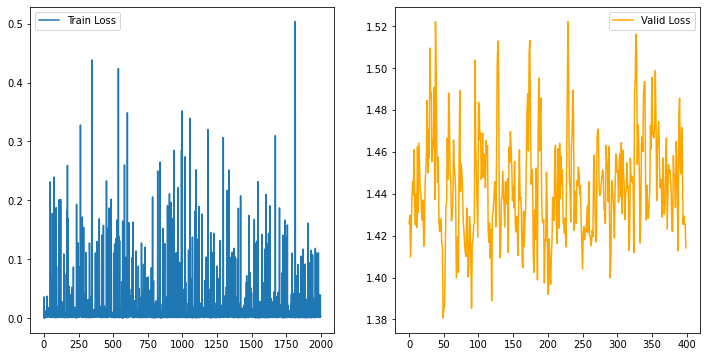

In [ ]:
tl = np.asarray(resnet_152_train_losses).ravel()
vl = np.asarray(resnet_152_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [ ]:
resnet_model_50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#ResNet50
from torchvision.models import resnet50, ResNet50_Weights
weights = ResNet50_Weights.DEFAULT
resnet_model_50 = resnet50(weights=weights)
# resnet_model_50 = resnet50()
# resnet_model_50.fc = nn.Linear(2048,16)
# resnet_model_50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding= (2, 2), bias=False)
num_classes = 4
num_ftrs= 2048
resnet_model_50.fc= nn.Linear(num_ftrs, num_classes)
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model_50.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
learning_rate = 2e-4
resnet_model_50 = resnet_model_50.to(device)
epochs = 80
loss_fn = nn.CrossEntropyLoss()
resnet_50_train_losses=[]
resnet_50_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%50==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

resnet_model_50 = train(resnet_model_50, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, resnet_50_train_losses, resnet_50_valid_losses, 'drive/Othercomputers/MyPC/R_D/models/resnet50.pth', lr_decay)

  1%|▏         | 1/80 [00:00<00:30,  2.57it/s]

Epoch - 1 Train-Loss : 1.2989276885986327
Validation loss decreased (-1.000000 --> 1.378121).  but not saving model (4C test)...
Epoch - 1 Valid-Loss : 1.378121256828308 Valid-Accuracy : 0.23809523809523808


  2%|▎         | 2/80 [00:00<00:29,  2.62it/s]

Epoch - 2 Train-Loss : 0.9064854860305787
Validation loss decreased (1.378121 --> 1.234451).  but not saving model (4C test)...
Epoch - 2 Valid-Loss : 1.2344506978988647 Valid-Accuracy : 0.5238095238095238


  4%|▍         | 3/80 [00:01<00:28,  2.67it/s]

Epoch - 3 Train-Loss : 0.4824604392051697
Validation loss decreased (1.234451 --> 1.051946).  but not saving model (4C test)...
Epoch - 3 Valid-Loss : 1.051945686340332 Valid-Accuracy : 0.6190476190476191


  5%|▌         | 4/80 [00:01<00:28,  2.68it/s]

Epoch - 4 Train-Loss : 0.2031936153769493
Validation loss decreased (1.051946 --> 0.831876).  but not saving model (4C test)...
Epoch - 4 Valid-Loss : 0.8318759202957153 Valid-Accuracy : 0.6666666666666666


  6%|▋         | 5/80 [00:01<00:27,  2.70it/s]

Epoch - 5 Train-Loss : 0.07113115936517715
Validation loss decreased (0.831876 --> 0.786557).  but not saving model (4C test)...
Epoch - 5 Valid-Loss : 0.7865572571754456 Valid-Accuracy : 0.7142857142857143


  8%|▊         | 6/80 [00:02<00:27,  2.69it/s]

Epoch - 6 Train-Loss : 0.06512471437454223
Epoch - 6 Valid-Loss : 0.9272841215133667 Valid-Accuracy : 0.6190476190476191


  9%|▉         | 7/80 [00:02<00:26,  2.70it/s]

Epoch - 7 Train-Loss : 0.00968760447576642
Epoch - 7 Valid-Loss : 0.9209021329879761 Valid-Accuracy : 0.5714285714285714


 10%|█         | 8/80 [00:02<00:26,  2.72it/s]

Epoch - 8 Train-Loss : 0.00781968692317605
Epoch - 8 Valid-Loss : 0.8983781933784485 Valid-Accuracy : 0.6190476190476191


 11%|█▏        | 9/80 [00:03<00:26,  2.73it/s]

Epoch - 9 Train-Loss : 0.005242347437888384
Epoch - 9 Valid-Loss : 0.8462210893630981 Valid-Accuracy : 0.7142857142857143


 12%|█▎        | 10/80 [00:03<00:25,  2.73it/s]

Epoch - 10 Train-Loss : 0.005652890144847334
Validation loss decreased (0.786557 --> 0.697824).  but not saving model (4C test)...
Epoch - 10 Valid-Loss : 0.6978240013122559 Valid-Accuracy : 0.7142857142857143


 14%|█▍        | 11/80 [00:04<00:25,  2.73it/s]

Epoch - 11 Train-Loss : 0.005076656327582895
Validation loss decreased (0.697824 --> 0.662395).  but not saving model (4C test)...
Epoch - 11 Valid-Loss : 0.6623950004577637 Valid-Accuracy : 0.7619047619047619


 15%|█▌        | 12/80 [00:04<00:24,  2.73it/s]

Epoch - 12 Train-Loss : 0.0019421458011493087
Validation loss decreased (0.662395 --> 0.614381).  but not saving model (4C test)...
Epoch - 12 Valid-Loss : 0.6143813133239746 Valid-Accuracy : 0.7142857142857143


 16%|█▋        | 13/80 [00:04<00:24,  2.74it/s]

Epoch - 13 Train-Loss : 0.0041149427415803075
Validation loss decreased (0.614381 --> 0.526738).  but not saving model (4C test)...
Epoch - 13 Valid-Loss : 0.5267379283905029 Valid-Accuracy : 0.8571428571428571


 18%|█▊        | 14/80 [00:05<00:24,  2.72it/s]

Epoch - 14 Train-Loss : 0.0032942274818196894
Validation loss decreased (0.526738 --> 0.465081).  but not saving model (4C test)...
Epoch - 14 Valid-Loss : 0.46508052945137024 Valid-Accuracy : 0.8571428571428571


 19%|█▉        | 15/80 [00:05<00:23,  2.73it/s]

Epoch - 15 Train-Loss : 0.005615596217103303
Epoch - 15 Valid-Loss : 0.5719221830368042 Valid-Accuracy : 0.8095238095238095


 20%|██        | 16/80 [00:05<00:23,  2.71it/s]

Epoch - 16 Train-Loss : 0.008625414292328059
Validation loss decreased (0.465081 --> 0.346578).  but not saving model (4C test)...
Epoch - 16 Valid-Loss : 0.3465777039527893 Valid-Accuracy : 0.8571428571428571


 21%|██▏       | 17/80 [00:06<00:23,  2.72it/s]

Epoch - 17 Train-Loss : 0.013193961908109486
Epoch - 17 Valid-Loss : 0.3562367260456085 Valid-Accuracy : 0.7619047619047619


 22%|██▎       | 18/80 [00:06<00:22,  2.72it/s]

Epoch - 18 Train-Loss : 0.07660077116452157
Epoch - 18 Valid-Loss : 0.8083974123001099 Valid-Accuracy : 0.5714285714285714


 24%|██▍       | 19/80 [00:07<00:22,  2.73it/s]

Epoch - 19 Train-Loss : 0.0489345888607204
Epoch - 19 Valid-Loss : 0.6362181901931763 Valid-Accuracy : 0.6666666666666666


 25%|██▌       | 20/80 [00:07<00:21,  2.74it/s]

Epoch - 20 Train-Loss : 0.06307286582887173
Epoch - 20 Valid-Loss : 0.5479666590690613 Valid-Accuracy : 0.7619047619047619


 26%|██▋       | 21/80 [00:07<00:21,  2.75it/s]

Epoch - 21 Train-Loss : 0.015518794022500514
Epoch - 21 Valid-Loss : 0.8700785040855408 Valid-Accuracy : 0.6190476190476191


 28%|██▊       | 22/80 [00:08<00:21,  2.75it/s]

Epoch - 22 Train-Loss : 0.014402807131409645
Epoch - 22 Valid-Loss : 0.9844521880149841 Valid-Accuracy : 0.5714285714285714


 29%|██▉       | 23/80 [00:08<00:20,  2.75it/s]

Epoch - 23 Train-Loss : 0.009288182482123375
Epoch - 23 Valid-Loss : 0.9363945722579956 Valid-Accuracy : 0.5714285714285714


 30%|███       | 24/80 [00:08<00:20,  2.75it/s]

Epoch - 24 Train-Loss : 0.004741797177121043
Epoch - 24 Valid-Loss : 0.8077579736709595 Valid-Accuracy : 0.5714285714285714


 31%|███▏      | 25/80 [00:09<00:19,  2.76it/s]

Epoch - 25 Train-Loss : 0.0028182657901197673
Epoch - 25 Valid-Loss : 0.666893720626831 Valid-Accuracy : 0.6666666666666666


 32%|███▎      | 26/80 [00:09<00:19,  2.75it/s]

Epoch - 26 Train-Loss : 0.0045719007728621365
Epoch - 26 Valid-Loss : 0.5443248748779297 Valid-Accuracy : 0.7142857142857143


 34%|███▍      | 27/80 [00:09<00:19,  2.76it/s]

Epoch - 27 Train-Loss : 0.0019367690663784742
Epoch - 27 Valid-Loss : 0.49394363164901733 Valid-Accuracy : 0.7619047619047619


 35%|███▌      | 28/80 [00:10<00:18,  2.76it/s]

Epoch - 28 Train-Loss : 0.0027160831028595566
Epoch - 28 Valid-Loss : 0.5065083503723145 Valid-Accuracy : 0.7142857142857143


 36%|███▋      | 29/80 [00:10<00:18,  2.76it/s]

Epoch - 29 Train-Loss : 0.005336196045391262
Epoch - 29 Valid-Loss : 0.5814547538757324 Valid-Accuracy : 0.7142857142857143


 38%|███▊      | 30/80 [00:10<00:18,  2.75it/s]

Epoch - 30 Train-Loss : 0.00047143350820988417
Epoch - 30 Valid-Loss : 0.5888670682907104 Valid-Accuracy : 0.7142857142857143


 39%|███▉      | 31/80 [00:11<00:17,  2.75it/s]

Epoch - 31 Train-Loss : 0.005927440163213759
Epoch - 31 Valid-Loss : 0.5964158773422241 Valid-Accuracy : 0.8095238095238095


 40%|████      | 32/80 [00:11<00:17,  2.75it/s]

Epoch - 32 Train-Loss : 0.004500610649120063
Epoch - 32 Valid-Loss : 0.6223666667938232 Valid-Accuracy : 0.8095238095238095


 41%|████▏     | 33/80 [00:12<00:17,  2.74it/s]

Epoch - 33 Train-Loss : 0.0028919667296577246
Epoch - 33 Valid-Loss : 0.6209960579872131 Valid-Accuracy : 0.8095238095238095


 42%|████▎     | 34/80 [00:12<00:16,  2.74it/s]

Epoch - 34 Train-Loss : 0.0009520799387246371
Epoch - 34 Valid-Loss : 0.6222422122955322 Valid-Accuracy : 0.7142857142857143


 44%|████▍     | 35/80 [00:12<00:16,  2.74it/s]

Epoch - 35 Train-Loss : 0.001138001008075662
Epoch - 35 Valid-Loss : 0.6325646638870239 Valid-Accuracy : 0.6190476190476191


 45%|████▌     | 36/80 [00:13<00:16,  2.74it/s]

Epoch - 36 Train-Loss : 0.0005824717751238495
Epoch - 36 Valid-Loss : 0.6175206303596497 Valid-Accuracy : 0.6666666666666666


 46%|████▋     | 37/80 [00:13<00:15,  2.74it/s]

Epoch - 37 Train-Loss : 0.001002960791811347
Epoch - 37 Valid-Loss : 0.5796895027160645 Valid-Accuracy : 0.8095238095238095


 48%|████▊     | 38/80 [00:13<00:15,  2.74it/s]

Epoch - 38 Train-Loss : 0.00040289424359798434
Epoch - 38 Valid-Loss : 0.5351126194000244 Valid-Accuracy : 0.8095238095238095


 49%|████▉     | 39/80 [00:14<00:14,  2.75it/s]

Epoch - 39 Train-Loss : 0.000323474346078001
Epoch - 39 Valid-Loss : 0.5178166627883911 Valid-Accuracy : 0.8095238095238095


 50%|█████     | 40/80 [00:14<00:14,  2.74it/s]

Epoch - 40 Train-Loss : 0.0003512008945108391
Epoch - 40 Valid-Loss : 0.5063663721084595 Valid-Accuracy : 0.8095238095238095


 51%|█████▏    | 41/80 [00:15<00:14,  2.74it/s]

Epoch - 41 Train-Loss : 0.00042602880857884885
Epoch - 41 Valid-Loss : 0.5109074711799622 Valid-Accuracy : 0.8095238095238095


 52%|█████▎    | 42/80 [00:15<00:13,  2.75it/s]

Epoch - 42 Train-Loss : 0.0005397383196395822
Epoch - 42 Valid-Loss : 0.5071837306022644 Valid-Accuracy : 0.8095238095238095


 54%|█████▍    | 43/80 [00:15<00:13,  2.75it/s]

Epoch - 43 Train-Loss : 0.00021278175991028546
Epoch - 43 Valid-Loss : 0.5078360438346863 Valid-Accuracy : 0.8095238095238095


 55%|█████▌    | 44/80 [00:16<00:13,  2.76it/s]

Epoch - 44 Train-Loss : 0.00030775753839407116
Epoch - 44 Valid-Loss : 0.5046800971031189 Valid-Accuracy : 0.8095238095238095


 56%|█████▋    | 45/80 [00:16<00:12,  2.76it/s]

Epoch - 45 Train-Loss : 0.000577881172648631
Epoch - 45 Valid-Loss : 0.5043919682502747 Valid-Accuracy : 0.8095238095238095


 57%|█████▊    | 46/80 [00:16<00:12,  2.75it/s]

Epoch - 46 Train-Loss : 0.00021161917393328623
Epoch - 46 Valid-Loss : 0.49976739287376404 Valid-Accuracy : 0.8095238095238095


 59%|█████▉    | 47/80 [00:17<00:11,  2.75it/s]

Epoch - 47 Train-Loss : 0.0041089206439210105
Epoch - 47 Valid-Loss : 0.5174630880355835 Valid-Accuracy : 0.8095238095238095


 60%|██████    | 48/80 [00:17<00:11,  2.75it/s]

Epoch - 48 Train-Loss : 0.00039607261132914575
Epoch - 48 Valid-Loss : 0.5410846471786499 Valid-Accuracy : 0.8095238095238095


 61%|██████▏   | 49/80 [00:17<00:11,  2.75it/s]

Epoch - 49 Train-Loss : 0.00024778480874374507
Epoch - 49 Valid-Loss : 0.521338164806366 Valid-Accuracy : 0.8095238095238095
Changed learning rate to 2e-09


 62%|██████▎   | 50/80 [00:18<00:10,  2.75it/s]

Epoch - 50 Train-Loss : 0.0010757308860775082
Epoch - 50 Valid-Loss : 0.5022655129432678 Valid-Accuracy : 0.8095238095238095


 64%|██████▍   | 51/80 [00:18<00:10,  2.75it/s]

Epoch - 51 Train-Loss : 0.0002470123741659336
Epoch - 51 Valid-Loss : 0.48736661672592163 Valid-Accuracy : 0.8095238095238095


 65%|██████▌   | 52/80 [00:19<00:10,  2.75it/s]

Epoch - 52 Train-Loss : 0.00018272199376951904
Epoch - 52 Valid-Loss : 0.4666593670845032 Valid-Accuracy : 0.8095238095238095


 66%|██████▋   | 53/80 [00:19<00:09,  2.74it/s]

Epoch - 53 Train-Loss : 0.0007072862703353166
Epoch - 53 Valid-Loss : 0.468694269657135 Valid-Accuracy : 0.8095238095238095


 68%|██████▊   | 54/80 [00:19<00:09,  2.73it/s]

Epoch - 54 Train-Loss : 0.00029167034372221676
Epoch - 54 Valid-Loss : 0.4714125990867615 Valid-Accuracy : 0.8095238095238095


 69%|██████▉   | 55/80 [00:20<00:09,  2.73it/s]

Epoch - 55 Train-Loss : 0.0037386835319921374
Epoch - 55 Valid-Loss : 0.46481767296791077 Valid-Accuracy : 0.8095238095238095


 70%|███████   | 56/80 [00:20<00:08,  2.73it/s]

Epoch - 56 Train-Loss : 0.00019009912939509376
Epoch - 56 Valid-Loss : 0.4635603725910187 Valid-Accuracy : 0.8095238095238095


 71%|███████▏  | 57/80 [00:20<00:08,  2.72it/s]

Epoch - 57 Train-Loss : 0.00019625865679699926
Epoch - 57 Valid-Loss : 0.46687090396881104 Valid-Accuracy : 0.8095238095238095


 72%|███████▎  | 58/80 [00:21<00:08,  2.73it/s]

Epoch - 58 Train-Loss : 0.00029358740284806116
Epoch - 58 Valid-Loss : 0.4664286673069 Valid-Accuracy : 0.8095238095238095


 74%|███████▍  | 59/80 [00:21<00:07,  2.74it/s]

Epoch - 59 Train-Loss : 0.00031270636973204093
Epoch - 59 Valid-Loss : 0.4734470248222351 Valid-Accuracy : 0.8095238095238095


 75%|███████▌  | 60/80 [00:21<00:07,  2.74it/s]

Epoch - 60 Train-Loss : 0.0003098225774010643
Epoch - 60 Valid-Loss : 0.4717823266983032 Valid-Accuracy : 0.8095238095238095


 76%|███████▋  | 61/80 [00:22<00:06,  2.74it/s]

Epoch - 61 Train-Loss : 0.0005691963451681659
Epoch - 61 Valid-Loss : 0.46643778681755066 Valid-Accuracy : 0.8095238095238095


 78%|███████▊  | 62/80 [00:22<00:06,  2.74it/s]

Epoch - 62 Train-Loss : 0.0002756286528892815
Epoch - 62 Valid-Loss : 0.46087202429771423 Valid-Accuracy : 0.8095238095238095


 79%|███████▉  | 63/80 [00:23<00:06,  2.74it/s]

Epoch - 63 Train-Loss : 0.00021185692166909577
Epoch - 63 Valid-Loss : 0.45668110251426697 Valid-Accuracy : 0.8095238095238095


 80%|████████  | 64/80 [00:23<00:05,  2.70it/s]

Epoch - 64 Train-Loss : 0.0005177222832571715
Epoch - 64 Valid-Loss : 0.4561394155025482 Valid-Accuracy : 0.8095238095238095


 81%|████████▏ | 65/80 [00:23<00:05,  2.71it/s]

Epoch - 65 Train-Loss : 0.0004982225480489432
Epoch - 65 Valid-Loss : 0.45692190527915955 Valid-Accuracy : 0.8095238095238095


 82%|████████▎ | 66/80 [00:24<00:05,  2.72it/s]

Epoch - 66 Train-Loss : 0.0006004460447002202
Epoch - 66 Valid-Loss : 0.4597943127155304 Valid-Accuracy : 0.8095238095238095


 84%|████████▍ | 67/80 [00:24<00:04,  2.72it/s]

Epoch - 67 Train-Loss : 0.0006318864412605763
Epoch - 67 Valid-Loss : 0.46696171164512634 Valid-Accuracy : 0.8095238095238095


 85%|████████▌ | 68/80 [00:24<00:04,  2.73it/s]

Epoch - 68 Train-Loss : 0.00047746158379595726
Epoch - 68 Valid-Loss : 0.4671160876750946 Valid-Accuracy : 0.8095238095238095


 86%|████████▋ | 69/80 [00:25<00:04,  2.73it/s]

Epoch - 69 Train-Loss : 0.00025936259771697223
Epoch - 69 Valid-Loss : 0.4634479284286499 Valid-Accuracy : 0.8095238095238095


 88%|████████▊ | 70/80 [00:25<00:03,  2.74it/s]

Epoch - 70 Train-Loss : 0.00029795853479299696
Epoch - 70 Valid-Loss : 0.4729970395565033 Valid-Accuracy : 0.8095238095238095


 89%|████████▉ | 71/80 [00:25<00:03,  2.74it/s]

Epoch - 71 Train-Loss : 0.0009442173512070439
Epoch - 71 Valid-Loss : 0.47190266847610474 Valid-Accuracy : 0.8095238095238095


 90%|█████████ | 72/80 [00:26<00:02,  2.73it/s]

Epoch - 72 Train-Loss : 0.00017297957820119336
Epoch - 72 Valid-Loss : 0.48086124658584595 Valid-Accuracy : 0.8095238095238095


 91%|█████████▏| 73/80 [00:26<00:02,  2.73it/s]

Epoch - 73 Train-Loss : 0.00039904737495817245
Epoch - 73 Valid-Loss : 0.4740048050880432 Valid-Accuracy : 0.8095238095238095


 92%|█████████▎| 74/80 [00:27<00:02,  2.73it/s]

Epoch - 74 Train-Loss : 0.00028518596081994474
Epoch - 74 Valid-Loss : 0.4823887348175049 Valid-Accuracy : 0.8095238095238095


 94%|█████████▍| 75/80 [00:27<00:01,  2.72it/s]

Epoch - 75 Train-Loss : 0.0013486688811099156
Epoch - 75 Valid-Loss : 0.48511913418769836 Valid-Accuracy : 0.8095238095238095


 95%|█████████▌| 76/80 [00:27<00:01,  2.72it/s]

Epoch - 76 Train-Loss : 0.0003805301617830992
Epoch - 76 Valid-Loss : 0.47057634592056274 Valid-Accuracy : 0.8095238095238095


 96%|█████████▋| 77/80 [00:28<00:01,  2.72it/s]

Epoch - 77 Train-Loss : 0.0005656180059304461
Epoch - 77 Valid-Loss : 0.4652455747127533 Valid-Accuracy : 0.8095238095238095


 98%|█████████▊| 78/80 [00:28<00:00,  2.71it/s]

Epoch - 78 Train-Loss : 0.00018990902754012495
Epoch - 78 Valid-Loss : 0.46808338165283203 Valid-Accuracy : 0.8095238095238095


 99%|█████████▉| 79/80 [00:28<00:00,  2.71it/s]

Epoch - 79 Train-Loss : 0.0003445482405368239
Epoch - 79 Valid-Loss : 0.45844072103500366 Valid-Accuracy : 0.8095238095238095


100%|██████████| 80/80 [00:29<00:00,  2.73it/s]

Epoch - 80 Train-Loss : 0.000423946266528219
Epoch - 80 Valid-Loss : 0.47352737188339233 Valid-Accuracy : 0.8095238095238095


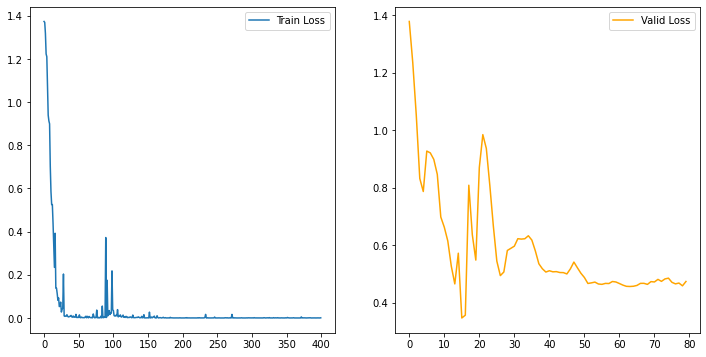

In [ ]:
tl = np.asarray(resnet_50_train_losses).ravel()
vl = np.asarray(resnet_50_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [ ]:
densenet_model_201

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#DenseNet201
from torchvision.models import densenet201, DenseNet201_Weights
weights = DenseNet201_Weights.DEFAULT
densenet_model_201 = densenet201(weights=weights)
#densenet_model_201 = densenet201()
num_classes = 4
num_ftrs= 1920
densenet_model_201.classifier= nn.Linear(num_ftrs, num_classes)
learning_rate = 2e-4
optimizer = optim.Adam(densenet_model_201.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [ ]:
densenet_model_201 = densenet_model_201.to(device)
epochs = 80
loss_fn = nn.CrossEntropyLoss()
densenet_201_train_losses=[]
densenet_201_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%80==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

densenet_model_201 = train(densenet_model_201, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, densenet_201_train_losses, densenet_201_valid_losses, 'drive/Othercomputers/MyPC/R_D/models/densenet201.pth', lr_decay)

  1%|▏         | 1/80 [00:01<01:39,  1.26s/it]

Epoch - 1 Train-Loss : 0.884302842617035
Validation loss decreased (-1.000000 --> 1.078254).  but not saving model (4C test)...
Epoch - 1 Valid-Loss : 1.0782543420791626 Valid-Accuracy : 0.6190476190476191


  2%|▎         | 2/80 [00:02<01:33,  1.20s/it]

Epoch - 2 Train-Loss : 0.1289340913295746
Validation loss decreased (1.078254 --> 0.911805).  but not saving model (4C test)...
Epoch - 2 Valid-Loss : 0.9118050336837769 Valid-Accuracy : 0.5714285714285714


  4%|▍         | 3/80 [00:03<01:29,  1.16s/it]

Epoch - 3 Train-Loss : 0.033939066156744954
Validation loss decreased (0.911805 --> 0.873954).  but not saving model (4C test)...
Epoch - 3 Valid-Loss : 0.8739542365074158 Valid-Accuracy : 0.6190476190476191


  5%|▌         | 4/80 [00:04<01:27,  1.15s/it]

Epoch - 4 Train-Loss : 0.01301956307142973
Validation loss decreased (0.873954 --> 0.715831).  but not saving model (4C test)...
Epoch - 4 Valid-Loss : 0.715831458568573 Valid-Accuracy : 0.7142857142857143


  6%|▋         | 5/80 [00:05<01:25,  1.14s/it]

Epoch - 5 Train-Loss : 0.006796891521662474
Validation loss decreased (0.715831 --> 0.412211).  but not saving model (4C test)...
Epoch - 5 Valid-Loss : 0.41221123933792114 Valid-Accuracy : 0.8571428571428571


  8%|▊         | 6/80 [00:06<01:23,  1.13s/it]

Epoch - 6 Train-Loss : 0.004077037144452333
Validation loss decreased (0.412211 --> 0.275658).  but not saving model (4C test)...
Epoch - 6 Valid-Loss : 0.2756580412387848 Valid-Accuracy : 0.8571428571428571


  9%|▉         | 7/80 [00:08<01:22,  1.12s/it]

Epoch - 7 Train-Loss : 0.003519237320870161
Validation loss decreased (0.275658 --> 0.245872).  but not saving model (4C test)...
Epoch - 7 Valid-Loss : 0.24587158858776093 Valid-Accuracy : 0.9047619047619048


 10%|█         | 8/80 [00:09<01:21,  1.14s/it]

Epoch - 8 Train-Loss : 0.0061955215409398075
Epoch - 8 Valid-Loss : 0.2569634020328522 Valid-Accuracy : 0.9047619047619048


 11%|█▏        | 9/80 [00:10<01:20,  1.13s/it]

Epoch - 9 Train-Loss : 0.01442815656773746
Epoch - 9 Valid-Loss : 0.2630169987678528 Valid-Accuracy : 0.9047619047619048


 12%|█▎        | 10/80 [00:11<01:18,  1.13s/it]

Epoch - 10 Train-Loss : 0.009915838344022631
Epoch - 10 Valid-Loss : 0.2767341136932373 Valid-Accuracy : 0.9047619047619048


 14%|█▍        | 11/80 [00:12<01:17,  1.12s/it]

Epoch - 11 Train-Loss : 0.005526146665215492
Epoch - 11 Valid-Loss : 0.29639101028442383 Valid-Accuracy : 0.9047619047619048


 15%|█▌        | 12/80 [00:13<01:16,  1.12s/it]

Epoch - 12 Train-Loss : 0.0027589873177930714
Epoch - 12 Valid-Loss : 0.3230731189250946 Valid-Accuracy : 0.8571428571428571


 16%|█▋        | 13/80 [00:14<01:15,  1.13s/it]

Epoch - 13 Train-Loss : 0.0021214740118011832
Epoch - 13 Valid-Loss : 0.33722013235092163 Valid-Accuracy : 0.8571428571428571


 18%|█▊        | 14/80 [00:15<01:14,  1.13s/it]

Epoch - 14 Train-Loss : 0.00400918850209564
Epoch - 14 Valid-Loss : 0.3268165588378906 Valid-Accuracy : 0.8571428571428571


 19%|█▉        | 15/80 [00:17<01:13,  1.13s/it]

Epoch - 15 Train-Loss : 0.003917152620851993
Epoch - 15 Valid-Loss : 0.3409023880958557 Valid-Accuracy : 0.8571428571428571


 20%|██        | 16/80 [00:18<01:11,  1.12s/it]

Epoch - 16 Train-Loss : 0.0018146583577618002
Epoch - 16 Valid-Loss : 0.38965916633605957 Valid-Accuracy : 0.9047619047619048


 21%|██▏       | 17/80 [00:19<01:10,  1.12s/it]

Epoch - 17 Train-Loss : 0.0016438617953099311
Epoch - 17 Valid-Loss : 0.4278891980648041 Valid-Accuracy : 0.9047619047619048


 22%|██▎       | 18/80 [00:20<01:09,  1.12s/it]

Epoch - 18 Train-Loss : 0.0014663993264548481
Epoch - 18 Valid-Loss : 0.42379239201545715 Valid-Accuracy : 0.9047619047619048


 24%|██▍       | 19/80 [00:21<01:07,  1.11s/it]

Epoch - 19 Train-Loss : 0.001727375842165202
Epoch - 19 Valid-Loss : 0.42668211460113525 Valid-Accuracy : 0.9047619047619048


 25%|██▌       | 20/80 [00:22<01:07,  1.12s/it]

Epoch - 20 Train-Loss : 0.002477364125661552
Epoch - 20 Valid-Loss : 0.38970741629600525 Valid-Accuracy : 0.9047619047619048


 26%|██▋       | 21/80 [00:23<01:06,  1.13s/it]

Epoch - 21 Train-Loss : 0.0007250791764818132
Epoch - 21 Valid-Loss : 0.44510921835899353 Valid-Accuracy : 0.9047619047619048


 28%|██▊       | 22/80 [00:24<01:05,  1.13s/it]

Epoch - 22 Train-Loss : 0.001764432981144637
Epoch - 22 Valid-Loss : 0.36822593212127686 Valid-Accuracy : 0.9047619047619048


 29%|██▉       | 23/80 [00:26<01:04,  1.13s/it]

Epoch - 23 Train-Loss : 0.0010984206572175026
Epoch - 23 Valid-Loss : 0.30307576060295105 Valid-Accuracy : 0.9047619047619048


 30%|███       | 24/80 [00:27<01:03,  1.13s/it]

Epoch - 24 Train-Loss : 0.0009351390646770597
Epoch - 24 Valid-Loss : 0.2567177414894104 Valid-Accuracy : 0.9047619047619048


 31%|███▏      | 25/80 [00:28<01:02,  1.13s/it]

Epoch - 25 Train-Loss : 0.0021715466515161096
Validation loss decreased (0.245872 --> 0.244165).  but not saving model (4C test)...
Epoch - 25 Valid-Loss : 0.2441650778055191 Valid-Accuracy : 0.9047619047619048


 32%|███▎      | 26/80 [00:29<01:00,  1.12s/it]

Epoch - 26 Train-Loss : 0.0016221164027228952
Epoch - 26 Valid-Loss : 0.24906723201274872 Valid-Accuracy : 0.8571428571428571


 34%|███▍      | 27/80 [00:30<00:59,  1.12s/it]

Epoch - 27 Train-Loss : 0.0005809156748000533
Epoch - 27 Valid-Loss : 0.2887412905693054 Valid-Accuracy : 0.8571428571428571


 35%|███▌      | 28/80 [00:31<00:58,  1.12s/it]

Epoch - 28 Train-Loss : 0.000869511195924133
Epoch - 28 Valid-Loss : 0.294440895318985 Valid-Accuracy : 0.8571428571428571


 36%|███▋      | 29/80 [00:32<00:57,  1.12s/it]

Epoch - 29 Train-Loss : 0.0026643756835255774
Epoch - 29 Valid-Loss : 0.28784820437431335 Valid-Accuracy : 0.8571428571428571


 38%|███▊      | 30/80 [00:33<00:55,  1.12s/it]

Epoch - 30 Train-Loss : 0.0005121549183968455
Epoch - 30 Valid-Loss : 0.3137718737125397 Valid-Accuracy : 0.8571428571428571


 39%|███▉      | 31/80 [00:34<00:54,  1.12s/it]

Epoch - 31 Train-Loss : 0.0006874027487356216
Epoch - 31 Valid-Loss : 0.3380011320114136 Valid-Accuracy : 0.8571428571428571


 40%|████      | 32/80 [00:36<00:53,  1.12s/it]

Epoch - 32 Train-Loss : 0.0004927007772494108
Epoch - 32 Valid-Loss : 0.34383007884025574 Valid-Accuracy : 0.8571428571428571


 41%|████▏     | 33/80 [00:37<00:52,  1.12s/it]

Epoch - 33 Train-Loss : 0.0006312628567684442
Epoch - 33 Valid-Loss : 0.33930113911628723 Valid-Accuracy : 0.8571428571428571


 42%|████▎     | 34/80 [00:38<00:51,  1.12s/it]

Epoch - 34 Train-Loss : 0.0010085808811709286
Epoch - 34 Valid-Loss : 0.32383713126182556 Valid-Accuracy : 0.8571428571428571


 44%|████▍     | 35/80 [00:39<00:50,  1.11s/it]

Epoch - 35 Train-Loss : 0.0003620596224209294
Epoch - 35 Valid-Loss : 0.3300709128379822 Valid-Accuracy : 0.8571428571428571


 45%|████▌     | 36/80 [00:40<00:49,  1.11s/it]

Epoch - 36 Train-Loss : 0.0012305320822633802
Epoch - 36 Valid-Loss : 0.3158315420150757 Valid-Accuracy : 0.9047619047619048


 46%|████▋     | 37/80 [00:41<00:47,  1.11s/it]

Epoch - 37 Train-Loss : 0.00230671152821742
Epoch - 37 Valid-Loss : 0.2836129367351532 Valid-Accuracy : 0.9047619047619048


 48%|████▊     | 38/80 [00:42<00:46,  1.11s/it]

Epoch - 38 Train-Loss : 0.000740308704553172
Epoch - 38 Valid-Loss : 0.3226803243160248 Valid-Accuracy : 0.8571428571428571


 49%|████▉     | 39/80 [00:43<00:45,  1.12s/it]

Epoch - 39 Train-Loss : 0.0007871022098697722
Epoch - 39 Valid-Loss : 0.3385123014450073 Valid-Accuracy : 0.8571428571428571


 50%|█████     | 40/80 [00:45<00:44,  1.12s/it]

Epoch - 40 Train-Loss : 0.0006297133513726294
Epoch - 40 Valid-Loss : 0.35940811038017273 Valid-Accuracy : 0.9047619047619048


 51%|█████▏    | 41/80 [00:46<00:43,  1.12s/it]

Epoch - 41 Train-Loss : 0.0004219711932819337
Epoch - 41 Valid-Loss : 0.38126373291015625 Valid-Accuracy : 0.9047619047619048


 52%|█████▎    | 42/80 [00:47<00:43,  1.15s/it]

Epoch - 42 Train-Loss : 0.013396945653948934
Epoch - 42 Valid-Loss : 1.1783623695373535 Valid-Accuracy : 0.6666666666666666


 54%|█████▍    | 43/80 [00:48<00:42,  1.14s/it]

Epoch - 43 Train-Loss : 0.034993636421859264
Epoch - 43 Valid-Loss : 0.761300265789032 Valid-Accuracy : 0.6190476190476191


 55%|█████▌    | 44/80 [00:49<00:41,  1.14s/it]

Epoch - 44 Train-Loss : 0.04585783421061933
Epoch - 44 Valid-Loss : 1.025521993637085 Valid-Accuracy : 0.6666666666666666


 56%|█████▋    | 45/80 [00:50<00:39,  1.14s/it]

Epoch - 45 Train-Loss : 0.012955341301858426
Epoch - 45 Valid-Loss : 1.285735845565796 Valid-Accuracy : 0.5238095238095238


 57%|█████▊    | 46/80 [00:51<00:38,  1.13s/it]

Epoch - 46 Train-Loss : 0.022148132789880037
Epoch - 46 Valid-Loss : 1.2487871646881104 Valid-Accuracy : 0.6190476190476191


 59%|█████▉    | 47/80 [00:52<00:37,  1.13s/it]

Epoch - 47 Train-Loss : 0.03760258955881
Epoch - 47 Valid-Loss : 0.3914978802204132 Valid-Accuracy : 0.8095238095238095


 60%|██████    | 48/80 [00:54<00:36,  1.13s/it]

Epoch - 48 Train-Loss : 0.029197972058318554
Epoch - 48 Valid-Loss : 0.6949070692062378 Valid-Accuracy : 0.7619047619047619


 61%|██████▏   | 49/80 [00:55<00:34,  1.12s/it]

Epoch - 49 Train-Loss : 0.024067845521494748
Epoch - 49 Valid-Loss : 0.7982556223869324 Valid-Accuracy : 0.6666666666666666


 62%|██████▎   | 50/80 [00:56<00:33,  1.12s/it]

Epoch - 50 Train-Loss : 0.007851065462455153
Epoch - 50 Valid-Loss : 0.7770065069198608 Valid-Accuracy : 0.8095238095238095


 64%|██████▍   | 51/80 [00:57<00:32,  1.12s/it]

Epoch - 51 Train-Loss : 0.022749691363424064
Epoch - 51 Valid-Loss : 1.6270475387573242 Valid-Accuracy : 0.6190476190476191


 65%|██████▌   | 52/80 [00:58<00:31,  1.12s/it]

Epoch - 52 Train-Loss : 0.012796492781490088
Epoch - 52 Valid-Loss : 1.527799367904663 Valid-Accuracy : 0.5714285714285714


 66%|██████▋   | 53/80 [00:59<00:30,  1.11s/it]

Epoch - 53 Train-Loss : 0.0154904012568295
Epoch - 53 Valid-Loss : 0.7917562127113342 Valid-Accuracy : 0.6666666666666666


 68%|██████▊   | 54/80 [01:00<00:28,  1.11s/it]

Epoch - 54 Train-Loss : 0.004357527638785541
Epoch - 54 Valid-Loss : 0.42027750611305237 Valid-Accuracy : 0.8571428571428571


 69%|██████▉   | 55/80 [01:01<00:27,  1.11s/it]

Epoch - 55 Train-Loss : 0.0026150925550609827
Epoch - 55 Valid-Loss : 0.3027258515357971 Valid-Accuracy : 0.9047619047619048


 70%|███████   | 56/80 [01:03<00:26,  1.12s/it]

Epoch - 56 Train-Loss : 0.00114221409894526
Epoch - 56 Valid-Loss : 0.26115137338638306 Valid-Accuracy : 0.9047619047619048


 71%|███████▏  | 57/80 [01:04<00:25,  1.12s/it]

Epoch - 57 Train-Loss : 0.04004792380146682
Validation loss decreased (0.244165 --> 0.170663).  but not saving model (4C test)...
Epoch - 57 Valid-Loss : 0.17066340148448944 Valid-Accuracy : 0.9523809523809523


 72%|███████▎  | 58/80 [01:05<00:24,  1.12s/it]

Epoch - 58 Train-Loss : 0.00654148175381124
Epoch - 58 Valid-Loss : 0.5413203239440918 Valid-Accuracy : 0.7619047619047619


 74%|███████▍  | 59/80 [01:06<00:23,  1.12s/it]

Epoch - 59 Train-Loss : 0.003610064089298248
Epoch - 59 Valid-Loss : 0.94134521484375 Valid-Accuracy : 0.7142857142857143


 75%|███████▌  | 60/80 [01:07<00:22,  1.12s/it]

Epoch - 60 Train-Loss : 0.0024966113385744395
Epoch - 60 Valid-Loss : 1.1203669309616089 Valid-Accuracy : 0.7142857142857143


 76%|███████▋  | 61/80 [01:08<00:21,  1.12s/it]

Epoch - 61 Train-Loss : 0.001663772773463279
Epoch - 61 Valid-Loss : 1.129500389099121 Valid-Accuracy : 0.7142857142857143


 78%|███████▊  | 62/80 [01:09<00:20,  1.13s/it]

Epoch - 62 Train-Loss : 0.002249078033491969
Epoch - 62 Valid-Loss : 0.2772982120513916 Valid-Accuracy : 0.8571428571428571


 79%|███████▉  | 63/80 [01:10<00:19,  1.12s/it]

Epoch - 63 Train-Loss : 0.012672462116461248
Epoch - 63 Valid-Loss : 1.1826574802398682 Valid-Accuracy : 0.7142857142857143


 80%|████████  | 64/80 [01:11<00:17,  1.12s/it]

Epoch - 64 Train-Loss : 0.0050550433224998415
Epoch - 64 Valid-Loss : 1.3202855587005615 Valid-Accuracy : 0.6190476190476191


 81%|████████▏ | 65/80 [01:13<00:16,  1.12s/it]

Epoch - 65 Train-Loss : 0.003412863693665713
Epoch - 65 Valid-Loss : 0.6033572554588318 Valid-Accuracy : 0.8095238095238095


 82%|████████▎ | 66/80 [01:14<00:15,  1.12s/it]

Epoch - 66 Train-Loss : 0.019693361793179064
Epoch - 66 Valid-Loss : 1.368933081626892 Valid-Accuracy : 0.7619047619047619


 84%|████████▍ | 67/80 [01:15<00:14,  1.12s/it]

Epoch - 67 Train-Loss : 0.013160159671679139
Epoch - 67 Valid-Loss : 2.089026927947998 Valid-Accuracy : 0.7142857142857143


 85%|████████▌ | 68/80 [01:16<00:13,  1.12s/it]

Epoch - 68 Train-Loss : 0.07473731264472008
Epoch - 68 Valid-Loss : 0.21902994811534882 Valid-Accuracy : 0.8095238095238095


 86%|████████▋ | 69/80 [01:17<00:12,  1.12s/it]

Epoch - 69 Train-Loss : 0.027108769374899568
Epoch - 69 Valid-Loss : 0.5842386484146118 Valid-Accuracy : 0.8095238095238095


 88%|████████▊ | 70/80 [01:18<00:11,  1.11s/it]

Epoch - 70 Train-Loss : 0.007832945697009564
Epoch - 70 Valid-Loss : 0.6692388653755188 Valid-Accuracy : 0.8095238095238095


 89%|████████▉ | 71/80 [01:19<00:10,  1.12s/it]

Epoch - 71 Train-Loss : 0.008477222174406052
Epoch - 71 Valid-Loss : 0.6582981944084167 Valid-Accuracy : 0.8095238095238095


 90%|█████████ | 72/80 [01:20<00:08,  1.12s/it]

Epoch - 72 Train-Loss : 0.040895787277258934
Epoch - 72 Valid-Loss : 0.9339755773544312 Valid-Accuracy : 0.7619047619047619


 91%|█████████▏| 73/80 [01:22<00:07,  1.13s/it]

Epoch - 73 Train-Loss : 0.01923095532692969
Epoch - 73 Valid-Loss : 1.131276249885559 Valid-Accuracy : 0.6666666666666666


 92%|█████████▎| 74/80 [01:23<00:06,  1.12s/it]

Epoch - 74 Train-Loss : 0.007409200072288513
Epoch - 74 Valid-Loss : 0.9928141832351685 Valid-Accuracy : 0.8095238095238095


 94%|█████████▍| 75/80 [01:24<00:05,  1.12s/it]

Epoch - 75 Train-Loss : 0.011030430160462856
Epoch - 75 Valid-Loss : 0.7626360058784485 Valid-Accuracy : 0.8095238095238095


 95%|█████████▌| 76/80 [01:25<00:04,  1.12s/it]

Epoch - 76 Train-Loss : 0.002021605509798974
Epoch - 76 Valid-Loss : 0.3814655542373657 Valid-Accuracy : 0.8095238095238095


 96%|█████████▋| 77/80 [01:26<00:03,  1.12s/it]

Epoch - 77 Train-Loss : 0.0029942232300527393
Epoch - 77 Valid-Loss : 0.21249936521053314 Valid-Accuracy : 0.9523809523809523


 98%|█████████▊| 78/80 [01:27<00:02,  1.12s/it]

Epoch - 78 Train-Loss : 0.0009948754217475654
Validation loss decreased (0.170663 --> 0.148421).  but not saving model (4C test)...
Epoch - 78 Valid-Loss : 0.14842142164707184 Valid-Accuracy : 0.9523809523809523


 99%|█████████▉| 79/80 [01:28<00:01,  1.12s/it]

Epoch - 79 Train-Loss : 0.003672744327923283
Validation loss decreased (0.148421 --> 0.144820).  but not saving model (4C test)...
Epoch - 79 Valid-Loss : 0.14481981098651886 Valid-Accuracy : 0.9523809523809523
Changed learning rate to 2e-12


100%|██████████| 80/80 [01:29<00:00,  1.12s/it]

Epoch - 80 Train-Loss : 0.0013274443685077132
Epoch - 80 Valid-Loss : 0.15565882623195648 Valid-Accuracy : 0.9523809523809523


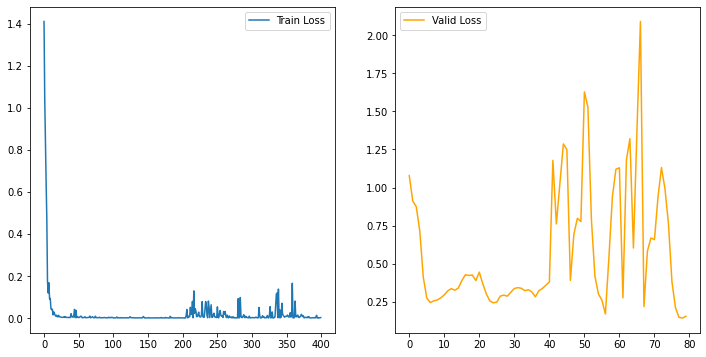

In [ ]:
tl = np.asarray(densenet_201_train_losses).ravel()
vl = np.asarray(densenet_201_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [ ]:
efficientnet_model_b7

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
#EfficientNet
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
weights = EfficientNet_V2_L_Weights.DEFAULT
efficientnet_model_b7 = efficientnet_v2_l(weights=weights)
# efficientnet_b7_model = efficientnet_v2_l()
num_classes = 4
num_ftrs= 1280
efficientnet_model_b7.classifier[1]= nn.Linear(num_ftrs, num_classes)
learning_rate = 2e-5
optimizer = optim.Adam(efficientnet_model_b7.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth


  0%|          | 0.00/455M [00:00<?, ?B/s]

In [ ]:
efficientnet_model_b7 = efficientnet_model_b7.to(device)
epochs = 80
loss_fn = nn.CrossEntropyLoss()
efficientnet_b7_train_losses=[]
efficientnet_b7_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%100==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

efficientnet_b7_model = train(efficientnet_model_b7, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, efficientnet_b7_train_losses, efficientnet_b7_valid_losses, 'drive/Othercomputers/MyPC/R_D/models/efficientnet_b7.pth', lr_decay) 

  1%|▏         | 1/80 [00:01<02:27,  1.87s/it]

Epoch - 1 Train-Loss : 1.5544758796691895
Validation loss decreased (-1.000000 --> 1.627623).  but not saving model (4C test)...
Epoch - 1 Valid-Loss : 1.6276227235794067 Valid-Accuracy : 0.14285714285714285


  2%|▎         | 2/80 [00:03<02:19,  1.79s/it]

Epoch - 2 Train-Loss : 1.2023933410644532
Validation loss decreased (1.627623 --> 1.456288).  but not saving model (4C test)...
Epoch - 2 Valid-Loss : 1.456288456916809 Valid-Accuracy : 0.2857142857142857


  4%|▍         | 3/80 [00:05<02:12,  1.72s/it]

Epoch - 3 Train-Loss : 1.0246450424194335
Validation loss decreased (1.456288 --> 1.321935).  but not saving model (4C test)...
Epoch - 3 Valid-Loss : 1.321934700012207 Valid-Accuracy : 0.2857142857142857


  5%|▌         | 4/80 [00:06<02:08,  1.69s/it]

Epoch - 4 Train-Loss : 0.8711710095405578
Validation loss decreased (1.321935 --> 1.208127).  but not saving model (4C test)...
Epoch - 4 Valid-Loss : 1.2081270217895508 Valid-Accuracy : 0.47619047619047616


  6%|▋         | 5/80 [00:08<02:05,  1.67s/it]

Epoch - 5 Train-Loss : 0.7147186875343323
Validation loss decreased (1.208127 --> 1.022757).  but not saving model (4C test)...
Epoch - 5 Valid-Loss : 1.0227574110031128 Valid-Accuracy : 0.5238095238095238


  8%|▊         | 6/80 [00:10<02:02,  1.66s/it]

Epoch - 6 Train-Loss : 0.6078535676002502
Validation loss decreased (1.022757 --> 0.935988).  but not saving model (4C test)...
Epoch - 6 Valid-Loss : 0.9359877705574036 Valid-Accuracy : 0.6666666666666666


  9%|▉         | 7/80 [00:11<02:01,  1.67s/it]

Epoch - 7 Train-Loss : 0.4946331739425659
Validation loss decreased (0.935988 --> 0.854214).  but not saving model (4C test)...
Epoch - 7 Valid-Loss : 0.8542143702507019 Valid-Accuracy : 0.6666666666666666


 10%|█         | 8/80 [00:13<01:59,  1.66s/it]

Epoch - 8 Train-Loss : 0.4398651897907257
Validation loss decreased (0.854214 --> 0.797783).  but not saving model (4C test)...
Epoch - 8 Valid-Loss : 0.7977825403213501 Valid-Accuracy : 0.7142857142857143


 11%|█▏        | 9/80 [00:15<01:57,  1.65s/it]

Epoch - 9 Train-Loss : 0.3590984344482422
Validation loss decreased (0.797783 --> 0.755257).  but not saving model (4C test)...
Epoch - 9 Valid-Loss : 0.755257248878479 Valid-Accuracy : 0.7142857142857143
Epoch - 10 Train-Loss : 0.3263718128204346
Validation loss decreased (0.755257 --> 0.702539).  but not saving model (4C test)...


 12%|█▎        | 10/80 [00:16<01:58,  1.69s/it]

Epoch - 10 Valid-Loss : 0.7025388479232788 Valid-Accuracy : 0.7619047619047619


 14%|█▍        | 11/80 [00:18<01:56,  1.68s/it]

Epoch - 11 Train-Loss : 0.24423956274986267
Validation loss decreased (0.702539 --> 0.656583).  but not saving model (4C test)...
Epoch - 11 Valid-Loss : 0.6565834283828735 Valid-Accuracy : 0.7619047619047619


 15%|█▌        | 12/80 [00:20<01:53,  1.66s/it]

Epoch - 12 Train-Loss : 0.20271601378917695
Validation loss decreased (0.656583 --> 0.615418).  but not saving model (4C test)...
Epoch - 12 Valid-Loss : 0.6154180765151978 Valid-Accuracy : 0.7619047619047619


 16%|█▋        | 13/80 [00:21<01:51,  1.66s/it]

Epoch - 13 Train-Loss : 0.24301477372646332
Validation loss decreased (0.615418 --> 0.572835).  but not saving model (4C test)...
Epoch - 13 Valid-Loss : 0.5728354454040527 Valid-Accuracy : 0.7142857142857143


 18%|█▊        | 14/80 [00:23<01:49,  1.66s/it]

Epoch - 14 Train-Loss : 0.17060760408639908
Validation loss decreased (0.572835 --> 0.528570).  but not saving model (4C test)...
Epoch - 14 Valid-Loss : 0.5285695195198059 Valid-Accuracy : 0.7142857142857143


 19%|█▉        | 15/80 [00:25<01:47,  1.65s/it]

Epoch - 15 Train-Loss : 0.18972107470035554
Validation loss decreased (0.528570 --> 0.492837).  but not saving model (4C test)...
Epoch - 15 Valid-Loss : 0.49283739924430847 Valid-Accuracy : 0.7619047619047619


 20%|██        | 16/80 [00:26<01:45,  1.65s/it]

Epoch - 16 Train-Loss : 0.13849213272333144
Validation loss decreased (0.492837 --> 0.477904).  but not saving model (4C test)...
Epoch - 16 Valid-Loss : 0.4779044985771179 Valid-Accuracy : 0.7619047619047619


 21%|██▏       | 17/80 [00:28<01:44,  1.65s/it]

Epoch - 17 Train-Loss : 0.11934500932693481
Validation loss decreased (0.477904 --> 0.475267).  but not saving model (4C test)...
Epoch - 17 Valid-Loss : 0.4752671420574188 Valid-Accuracy : 0.7619047619047619


 22%|██▎       | 18/80 [00:30<01:42,  1.65s/it]

Epoch - 18 Train-Loss : 0.10632652193307876
Validation loss decreased (0.475267 --> 0.459649).  but not saving model (4C test)...
Epoch - 18 Valid-Loss : 0.45964932441711426 Valid-Accuracy : 0.7619047619047619


 24%|██▍       | 19/80 [00:31<01:40,  1.65s/it]

Epoch - 19 Train-Loss : 0.10185046046972275
Validation loss decreased (0.459649 --> 0.436077).  but not saving model (4C test)...
Epoch - 19 Valid-Loss : 0.4360771179199219 Valid-Accuracy : 0.7619047619047619


 25%|██▌       | 20/80 [00:33<01:38,  1.64s/it]

Epoch - 20 Train-Loss : 0.07049919664859772
Validation loss decreased (0.436077 --> 0.412353).  but not saving model (4C test)...
Epoch - 20 Valid-Loss : 0.4123527407646179 Valid-Accuracy : 0.7619047619047619


 26%|██▋       | 21/80 [00:34<01:36,  1.64s/it]

Epoch - 21 Train-Loss : 0.06491196155548096
Validation loss decreased (0.412353 --> 0.390941).  but not saving model (4C test)...
Epoch - 21 Valid-Loss : 0.39094066619873047 Valid-Accuracy : 0.7619047619047619


 28%|██▊       | 22/80 [00:36<01:34,  1.64s/it]

Epoch - 22 Train-Loss : 0.07564911022782325
Validation loss decreased (0.390941 --> 0.364443).  but not saving model (4C test)...
Epoch - 22 Valid-Loss : 0.3644433617591858 Valid-Accuracy : 0.8095238095238095


 29%|██▉       | 23/80 [00:38<01:33,  1.63s/it]

Epoch - 23 Train-Loss : 0.051898682862520217
Validation loss decreased (0.364443 --> 0.351383).  but not saving model (4C test)...
Epoch - 23 Valid-Loss : 0.35138261318206787 Valid-Accuracy : 0.8571428571428571


 30%|███       | 24/80 [00:39<01:31,  1.63s/it]

Epoch - 24 Train-Loss : 0.06123324856162071
Validation loss decreased (0.351383 --> 0.336076).  but not saving model (4C test)...
Epoch - 24 Valid-Loss : 0.3360763192176819 Valid-Accuracy : 0.8571428571428571


 31%|███▏      | 25/80 [00:41<01:30,  1.64s/it]

Epoch - 25 Train-Loss : 0.04917854480445385
Validation loss decreased (0.336076 --> 0.335898).  but not saving model (4C test)...
Epoch - 25 Valid-Loss : 0.335897833108902 Valid-Accuracy : 0.8571428571428571


 32%|███▎      | 26/80 [00:43<01:28,  1.64s/it]

Epoch - 26 Train-Loss : 0.050939878821372984
Validation loss decreased (0.335898 --> 0.334573).  but not saving model (4C test)...
Epoch - 26 Valid-Loss : 0.3345727324485779 Valid-Accuracy : 0.8571428571428571


 34%|███▍      | 27/80 [00:44<01:26,  1.64s/it]

Epoch - 27 Train-Loss : 0.0429603710770607
Validation loss decreased (0.334573 --> 0.316164).  but not saving model (4C test)...
Epoch - 27 Valid-Loss : 0.31616440415382385 Valid-Accuracy : 0.9047619047619048


 35%|███▌      | 28/80 [00:46<01:25,  1.64s/it]

Epoch - 28 Train-Loss : 0.03897975608706474
Validation loss decreased (0.316164 --> 0.303665).  but not saving model (4C test)...
Epoch - 28 Valid-Loss : 0.303664892911911 Valid-Accuracy : 0.9047619047619048


 36%|███▋      | 29/80 [00:48<01:23,  1.63s/it]

Epoch - 29 Train-Loss : 0.031520655006170274
Epoch - 29 Valid-Loss : 0.31331929564476013 Valid-Accuracy : 0.8571428571428571


 38%|███▊      | 30/80 [00:49<01:22,  1.64s/it]

Epoch - 30 Train-Loss : 0.03174006305634976
Epoch - 30 Valid-Loss : 0.3091283142566681 Valid-Accuracy : 0.8571428571428571


 39%|███▉      | 31/80 [00:51<01:20,  1.64s/it]

Epoch - 31 Train-Loss : 0.03206203430891037
Epoch - 31 Valid-Loss : 0.3062314987182617 Valid-Accuracy : 0.9047619047619048


 40%|████      | 32/80 [00:52<01:18,  1.64s/it]

Epoch - 32 Train-Loss : 0.02322121858596802
Epoch - 32 Valid-Loss : 0.31268978118896484 Valid-Accuracy : 0.9047619047619048


 41%|████▏     | 33/80 [00:54<01:17,  1.64s/it]

Epoch - 33 Train-Loss : 0.01742815859615803
Validation loss decreased (0.303665 --> 0.301042).  but not saving model (4C test)...
Epoch - 33 Valid-Loss : 0.30104172229766846 Valid-Accuracy : 0.9047619047619048


 42%|████▎     | 34/80 [00:56<01:15,  1.63s/it]

Epoch - 34 Train-Loss : 0.021180389635264873
Validation loss decreased (0.301042 --> 0.295757).  but not saving model (4C test)...
Epoch - 34 Valid-Loss : 0.2957572638988495 Valid-Accuracy : 0.9047619047619048


 44%|████▍     | 35/80 [00:57<01:13,  1.64s/it]

Epoch - 35 Train-Loss : 0.017719667218625546
Epoch - 35 Valid-Loss : 0.3014289438724518 Valid-Accuracy : 0.8571428571428571


 45%|████▌     | 36/80 [00:59<01:12,  1.64s/it]

Epoch - 36 Train-Loss : 0.037548710405826566
Epoch - 36 Valid-Loss : 0.3184110224246979 Valid-Accuracy : 0.8571428571428571


 46%|████▋     | 37/80 [01:01<01:10,  1.64s/it]

Epoch - 37 Train-Loss : 0.02737079616636038
Validation loss decreased (0.295757 --> 0.279966).  but not saving model (4C test)...
Epoch - 37 Valid-Loss : 0.27996623516082764 Valid-Accuracy : 0.9047619047619048


 48%|████▊     | 38/80 [01:02<01:08,  1.64s/it]

Epoch - 38 Train-Loss : 0.036009924858808516
Validation loss decreased (0.279966 --> 0.264863).  but not saving model (4C test)...
Epoch - 38 Valid-Loss : 0.26486316323280334 Valid-Accuracy : 0.9047619047619048


 49%|████▉     | 39/80 [01:04<01:07,  1.64s/it]

Epoch - 39 Train-Loss : 0.016241694428026678
Epoch - 39 Valid-Loss : 0.28081026673316956 Valid-Accuracy : 0.8571428571428571


 50%|█████     | 40/80 [01:06<01:05,  1.64s/it]

Epoch - 40 Train-Loss : 0.02377893552184105
Epoch - 40 Valid-Loss : 0.2868632674217224 Valid-Accuracy : 0.8095238095238095


 51%|█████▏    | 41/80 [01:07<01:03,  1.64s/it]

Epoch - 41 Train-Loss : 0.02695306856185198
Epoch - 41 Valid-Loss : 0.284612774848938 Valid-Accuracy : 0.8095238095238095


 52%|█████▎    | 42/80 [01:09<01:02,  1.64s/it]

Epoch - 42 Train-Loss : 0.02499791756272316
Epoch - 42 Valid-Loss : 0.28055962920188904 Valid-Accuracy : 0.8571428571428571


 54%|█████▍    | 43/80 [01:11<01:00,  1.64s/it]

Epoch - 43 Train-Loss : 0.019628303684294225
Epoch - 43 Valid-Loss : 0.2860676050186157 Valid-Accuracy : 0.8571428571428571


 55%|█████▌    | 44/80 [01:12<00:58,  1.64s/it]

Epoch - 44 Train-Loss : 0.015578401461243629
Epoch - 44 Valid-Loss : 0.2912769913673401 Valid-Accuracy : 0.8571428571428571


 56%|█████▋    | 45/80 [01:14<00:57,  1.64s/it]

Epoch - 45 Train-Loss : 0.012832749541848898
Epoch - 45 Valid-Loss : 0.28459712862968445 Valid-Accuracy : 0.9047619047619048


 57%|█████▊    | 46/80 [01:15<00:55,  1.64s/it]

Epoch - 46 Train-Loss : 0.047979173809289934
Epoch - 46 Valid-Loss : 0.2711605131626129 Valid-Accuracy : 0.9047619047619048


 59%|█████▉    | 47/80 [01:17<00:53,  1.63s/it]

Epoch - 47 Train-Loss : 0.010802647564560175
Epoch - 47 Valid-Loss : 0.2678510248661041 Valid-Accuracy : 0.8571428571428571


 60%|██████    | 48/80 [01:19<00:52,  1.64s/it]

Epoch - 48 Train-Loss : 0.020768717862665653
Epoch - 48 Valid-Loss : 0.28017306327819824 Valid-Accuracy : 0.8571428571428571


 61%|██████▏   | 49/80 [01:20<00:51,  1.67s/it]

Epoch - 49 Train-Loss : 0.015990650095045567
Epoch - 49 Valid-Loss : 0.28860482573509216 Valid-Accuracy : 0.8095238095238095


 62%|██████▎   | 50/80 [01:22<00:50,  1.67s/it]

Epoch - 50 Train-Loss : 0.012833057902753353
Epoch - 50 Valid-Loss : 0.29023081064224243 Valid-Accuracy : 0.8571428571428571


 64%|██████▍   | 51/80 [01:24<00:48,  1.66s/it]

Epoch - 51 Train-Loss : 0.03410722017288208
Epoch - 51 Valid-Loss : 0.27888333797454834 Valid-Accuracy : 0.8095238095238095


 65%|██████▌   | 52/80 [01:25<00:46,  1.66s/it]

Epoch - 52 Train-Loss : 0.03160144556313753
Epoch - 52 Valid-Loss : 0.2679026126861572 Valid-Accuracy : 0.8571428571428571


 66%|██████▋   | 53/80 [01:27<00:44,  1.65s/it]

Epoch - 53 Train-Loss : 0.009816772956401109
Epoch - 53 Valid-Loss : 0.2649241089820862 Valid-Accuracy : 0.8571428571428571


 68%|██████▊   | 54/80 [01:29<00:42,  1.64s/it]

Epoch - 54 Train-Loss : 0.016262139799073337
Validation loss decreased (0.264863 --> 0.247582).  but not saving model (4C test)...
Epoch - 54 Valid-Loss : 0.24758216738700867 Valid-Accuracy : 0.9047619047619048


 69%|██████▉   | 55/80 [01:30<00:41,  1.64s/it]

Epoch - 55 Train-Loss : 0.008203973900526762
Epoch - 55 Valid-Loss : 0.24826110899448395 Valid-Accuracy : 0.9047619047619048


 70%|███████   | 56/80 [01:32<00:39,  1.64s/it]

Epoch - 56 Train-Loss : 0.009988932218402625
Validation loss decreased (0.247582 --> 0.230998).  but not saving model (4C test)...
Epoch - 56 Valid-Loss : 0.2309981733560562 Valid-Accuracy : 0.9047619047619048


 71%|███████▏  | 57/80 [01:34<00:37,  1.64s/it]

Epoch - 57 Train-Loss : 0.012724329344928264
Validation loss decreased (0.230998 --> 0.213267).  but not saving model (4C test)...
Epoch - 57 Valid-Loss : 0.21326668560504913 Valid-Accuracy : 0.9047619047619048


 72%|███████▎  | 58/80 [01:35<00:35,  1.63s/it]

Epoch - 58 Train-Loss : 0.03246474163606763
Validation loss decreased (0.213267 --> 0.196645).  but not saving model (4C test)...
Epoch - 58 Valid-Loss : 0.19664500653743744 Valid-Accuracy : 0.9047619047619048


 74%|███████▍  | 59/80 [01:37<00:34,  1.64s/it]

Epoch - 59 Train-Loss : 0.005980672221630812
Validation loss decreased (0.196645 --> 0.181440).  but not saving model (4C test)...
Epoch - 59 Valid-Loss : 0.18143995106220245 Valid-Accuracy : 0.9047619047619048


 75%|███████▌  | 60/80 [01:38<00:32,  1.63s/it]

Epoch - 60 Train-Loss : 0.008575160522013903
Validation loss decreased (0.181440 --> 0.174815).  but not saving model (4C test)...
Epoch - 60 Valid-Loss : 0.17481505870819092 Valid-Accuracy : 0.9047619047619048


 76%|███████▋  | 61/80 [01:40<00:31,  1.64s/it]

Epoch - 61 Train-Loss : 0.007032071892172098
Epoch - 61 Valid-Loss : 0.18008095026016235 Valid-Accuracy : 0.9047619047619048


 78%|███████▊  | 62/80 [01:42<00:29,  1.64s/it]

Epoch - 62 Train-Loss : 0.014513381849974393
Epoch - 62 Valid-Loss : 0.1832500398159027 Valid-Accuracy : 0.9047619047619048


 79%|███████▉  | 63/80 [01:43<00:27,  1.64s/it]

Epoch - 63 Train-Loss : 0.010619311826303601
Epoch - 63 Valid-Loss : 0.19115595519542694 Valid-Accuracy : 0.9047619047619048


 80%|████████  | 64/80 [01:45<00:26,  1.64s/it]

Epoch - 64 Train-Loss : 0.008171297702938318
Epoch - 64 Valid-Loss : 0.19040414690971375 Valid-Accuracy : 0.9523809523809523


 81%|████████▏ | 65/80 [01:47<00:24,  1.64s/it]

Epoch - 65 Train-Loss : 0.0065005906391888855
Epoch - 65 Valid-Loss : 0.20162130892276764 Valid-Accuracy : 0.9523809523809523


 82%|████████▎ | 66/80 [01:48<00:23,  1.64s/it]

Epoch - 66 Train-Loss : 0.016543226083740592
Epoch - 66 Valid-Loss : 0.2482760101556778 Valid-Accuracy : 0.9047619047619048


 84%|████████▍ | 67/80 [01:50<00:21,  1.64s/it]

Epoch - 67 Train-Loss : 0.004055026266723871
Epoch - 67 Valid-Loss : 0.3171420693397522 Valid-Accuracy : 0.9047619047619048


 85%|████████▌ | 68/80 [01:52<00:19,  1.64s/it]

Epoch - 68 Train-Loss : 0.01222330452874303
Epoch - 68 Valid-Loss : 0.35483136773109436 Valid-Accuracy : 0.8571428571428571


 86%|████████▋ | 69/80 [01:53<00:18,  1.64s/it]

Epoch - 69 Train-Loss : 0.0069765857420861725
Epoch - 69 Valid-Loss : 0.37746328115463257 Valid-Accuracy : 0.8571428571428571


 88%|████████▊ | 70/80 [01:55<00:16,  1.64s/it]

Epoch - 70 Train-Loss : 0.005496186902746558
Epoch - 70 Valid-Loss : 0.3970023989677429 Valid-Accuracy : 0.8095238095238095


 89%|████████▉ | 71/80 [01:57<00:14,  1.63s/it]

Epoch - 71 Train-Loss : 0.008321995800361037
Epoch - 71 Valid-Loss : 0.4066864550113678 Valid-Accuracy : 0.8095238095238095


 90%|█████████ | 72/80 [01:58<00:13,  1.64s/it]

Epoch - 72 Train-Loss : 0.006347987242043019
Epoch - 72 Valid-Loss : 0.3845871090888977 Valid-Accuracy : 0.8571428571428571


 91%|█████████▏| 73/80 [02:00<00:11,  1.64s/it]

Epoch - 73 Train-Loss : 0.010847830399870872
Epoch - 73 Valid-Loss : 0.3472301959991455 Valid-Accuracy : 0.8571428571428571


 92%|█████████▎| 74/80 [02:01<00:09,  1.64s/it]

Epoch - 74 Train-Loss : 0.014125880040228366
Epoch - 74 Valid-Loss : 0.3028169274330139 Valid-Accuracy : 0.8571428571428571


 94%|█████████▍| 75/80 [02:03<00:08,  1.63s/it]

Epoch - 75 Train-Loss : 0.01288463375531137
Epoch - 75 Valid-Loss : 0.2843298316001892 Valid-Accuracy : 0.8571428571428571


 95%|█████████▌| 76/80 [02:05<00:06,  1.63s/it]

Epoch - 76 Train-Loss : 0.017280290089547633
Epoch - 76 Valid-Loss : 0.2580309510231018 Valid-Accuracy : 0.8571428571428571


 96%|█████████▋| 77/80 [02:06<00:04,  1.63s/it]

Epoch - 77 Train-Loss : 0.004730956442654133
Epoch - 77 Valid-Loss : 0.24255669116973877 Valid-Accuracy : 0.8571428571428571


 98%|█████████▊| 78/80 [02:08<00:03,  1.63s/it]

Epoch - 78 Train-Loss : 0.007445016130805016
Epoch - 78 Valid-Loss : 0.24105088412761688 Valid-Accuracy : 0.8571428571428571


 99%|█████████▉| 79/80 [02:10<00:01,  1.64s/it]

Epoch - 79 Train-Loss : 0.0039019891060888766
Epoch - 79 Valid-Loss : 0.23815076053142548 Valid-Accuracy : 0.8571428571428571


100%|██████████| 80/80 [02:11<00:00,  1.65s/it]

Epoch - 80 Train-Loss : 0.006352160219103098
Epoch - 80 Valid-Loss : 0.238023579120636 Valid-Accuracy : 0.9047619047619048


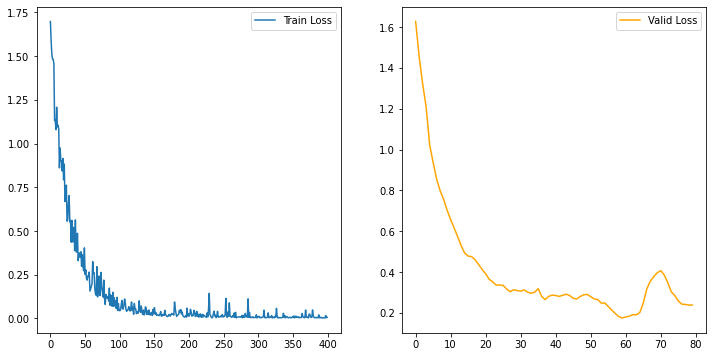

In [ ]:
tl = np.asarray(efficientnet_b7_train_losses).ravel()
vl = np.asarray(efficientnet_b7_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


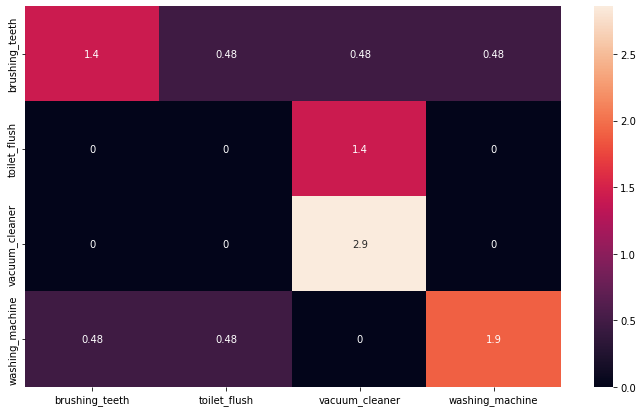

In [ ]:
#for VGG
model_net = vgg_model_19
show_heatmap(valid_loader_3d, model_net)

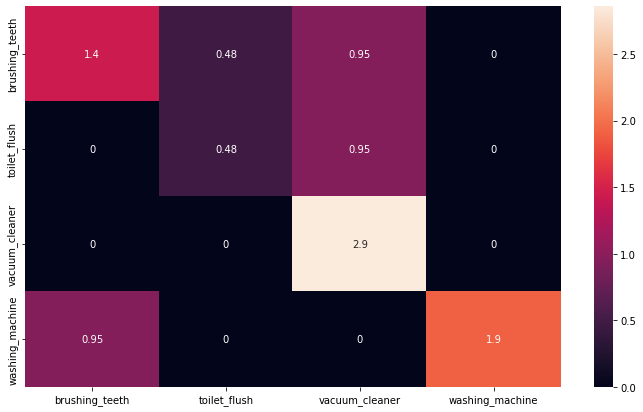

In [ ]:
#for alexnet
model_net = alexnet_model
show_heatmap(valid_loader_3d, model_net)

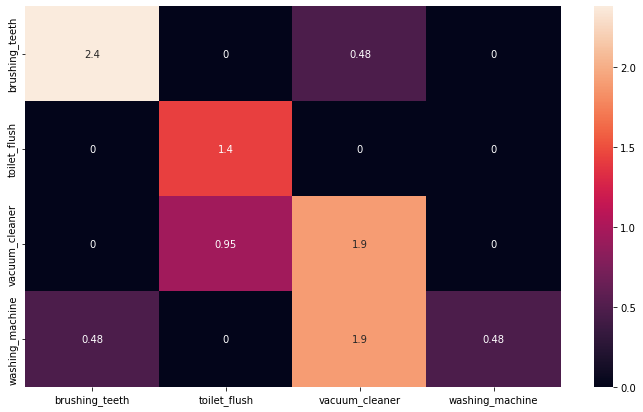

In [ ]:
#for resnet_152
model_net = resnet_model_152
show_heatmap(valid_loader_3d, model_net)

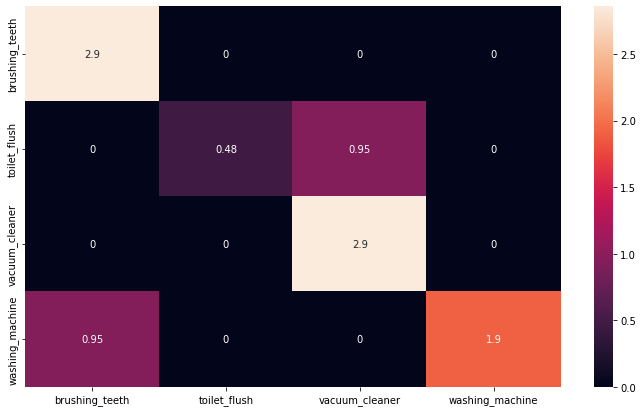

In [ ]:
#for resnet_50
model_net = resnet_model_50
show_heatmap(valid_loader_3d, model_net)

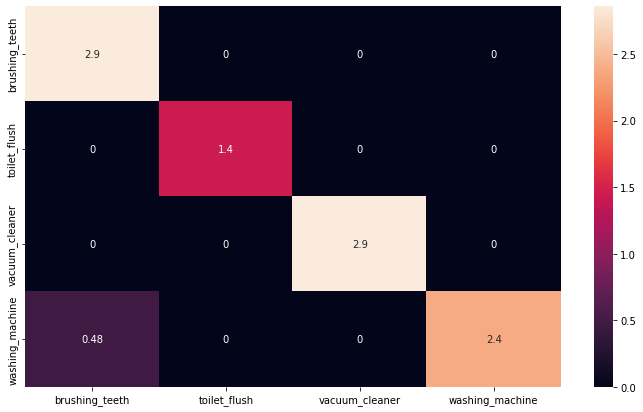

In [ ]:
#for densenet201
model_net = densenet_model_201
show_heatmap(valid_loader_3d, model_net)

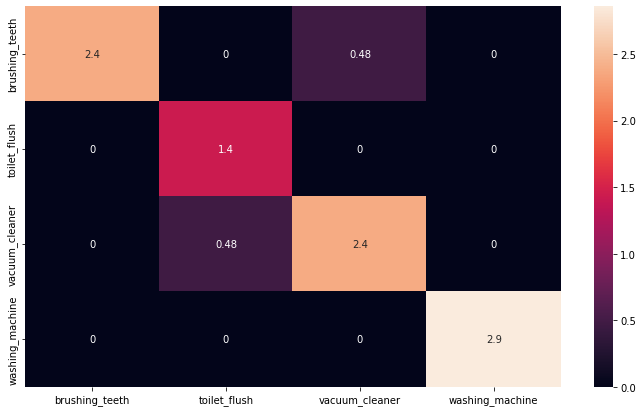

In [ ]:
#for efficientnet_b7
model_net = efficientnet_model_b7
show_heatmap(valid_loader_3d, model_net)

In [ ]:
torch.save(custom_model, './models/custom_model.pth')

In [ ]:
torch.save(resnet_model_152, './models/resnet152.pth')

In [ ]:
torch.save(resnet_model_50, './models/resnet50.pth')

In [ ]:
torch.save(densenet_model_201, './models/densenet201.pth')

In [ ]:
torch.save(efficientnet_b7_model, './models/efficentnet_b7.pth')

In [ ]:
torch.save(vgg_model_19, './models/vgg_19.pth')

In [ ]:
custom_model, optimizer = load_ckp(prefix + './models/custom_model.pth', custom_model, optimizer)
custom_model.eval()

In [ ]:
vgg_model_19, optimizer= load_ckp(prefix + './models/vgg_19.pth', vgg_model_19, optimizer)
vgg_model_19.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
alexnet, optimizer= load_ckp(prefix + './models/alexnet.pth', alexnet_model, optimizer)
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
resnet_model_152, optimizer= load_ckp(prefix + './models/resnet152.pth', resnet_model_152, optimizer)
resnet_model_152.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
resnet_model_50, optimizer= load_ckp(prefix + './models/resnet50.pth', resnet_model_50, optimizer)
resnet_model_50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
densenet_model_201, optimizer= load_ckp(prefix + './models/densenet201.pth', densenet_model_201, optimizer)
densenet_model_201.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
efficientnet_model_b7, optimizer= load_ckp(prefix + './models/efficientnet_b7.pth', efficientnet_model_b7, optimizer)
efficientnet_model_b7.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
def show_heatmap_3d(testloader, net):
    y_pred = []
    y_true = []
    net= net.to(device)
    
    # iterate over test data
    for labels, inputs in enumerate(testloader):
        
            x, y = inputs
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            output = net(x)       

            # output = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
            print (output)
            output= (torch.max(torch.exp(output), 1)[1]).cpu().detach().numpy()
            print (output)
            y_pred.extend(output) # Save Prediction
            labels = valid_data_3d.labels
            y_true.extend(labels) # Save Truth

    print ("Pred: ", output)
    print ("Real: ", valid_data_3d.labels)

    # constant for classes
    classes = ('brushing_teeth', 'toilet_flush', 'vacuum_cleaner', 'washing_machine')
    # classes = ('brushing_teeth', 'toilet_flush', 'vacuum_cleaner')
    
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)

In [ ]:
def show_heatmap(testloader, net):
    trace_yhat = []
    trace_y = []
    net= net.to(device)
    
    # iterate over test data
    for labels, inputs in enumerate(testloader):
        
            x, y = inputs
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = net(x)        

            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy().argmax(axis=1))      
            trace_y = np.concatenate(trace_y)
            trace_yhat = np.concatenate(trace_yhat)

    # constant for classes
    classes = ('brushing_teeth', 'toilet_flush', 'vacuum_cleaner', 'washing_machine')

    # Build confusion matrix
    cf_matrix = confusion_matrix(trace_y, trace_yhat)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)

In [ ]:
categories = sorted(df['category'].unique())
categories

['brushing_teeth', 'toilet_flush', 'vacuum_cleaner', 'washing_machine']

In [ ]:
# with open('indtocat.pkl','rb') as f:
#     indtocat = pickle.load(f)
filename= prefix +'./audio/6-100001-A-1.wav'
spec=spec_to_image_3d(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
print (spec_t.shape)
spec_t= spec_t.permute(2, 0 ,1)
spec_t= spec_t.reshape(1, 3, 128, 431)
print (spec_t.shape)
pr=efficientnet_model_b7.forward(spec_t)
print (pr)
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
# ind = (torch.max(torch.exp(pr), 1)[1]).data.cpu().numpy()
# print(indtocat[ind])
print (ind)
IPython.display.display(IPython.display.Audio(filename=filename))

torch.Size([128, 431, 3])
torch.Size([1, 3, 128, 431])
tensor([[-3.0396,  0.7060,  3.9262, -0.1178, -1.2492]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
2
